In [1]:
import torch
from cuqi.distribution import JointDistribution
from cuqipy_pytorch.distribution import Gaussian, Lognormal, Laplace
from cuqipy_pytorch.sampler import NUTS

/zhome/a6/3/207508/.conda/envs/cuqipytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2024 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Rafael Flock (DTU)
#  Edited by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# UQ for stochastic optical reconstruction microscopy

### Rafael Flock (raff@dtu.dk)

**Notice** You need CUQIpy-PyTorch to run this notebook.

In this case study, we perform uncertainty quantification for stochastic optical reconstruction microscopy (STORM). STORM is a super-resolution microscopy method based on single-molecule stochastic switching, where the goal is to detect molecule positions in live cell imaging. The image is obtained by a microscope detecting the photon count of the (fluorescence) photoactivated molecules. The original problem is solved in [1] by a determistic method. In this notebook, we perform uncertainty quantification in the Bayesian context [2].


In [3]:
import numpy as np
from scipy.stats import lognorm, norm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import cuqi
# from cuqi.distribution import Laplace, Gaussian, JointDistribution
# from cuqi.problem import BayesianProblem

In [4]:
np.random.seed(0)
torch.manual_seed(0)

## 1. Problem description

We start by collecting parameters that we will use later in our experiment in a dictionary.

In [5]:
# parameters
par = \
{'N': 50, # number of molecules
 's_data': 32, # side length of data image
 's_mol': 24, # side length of area in data image where molecules are located
 'R': 4, # super-resolution factor
 'mode': 3000, # mode of lognormal distribution of molecule photon count
 'ph_back': 70, # photon background count
 'noise_std': 30, # standard deviation of noise
 'pad_width': 1, # for boundary conditions of blurring kernel of instrument
 'ext_mode': 'periodic', # boundary condition of blurring kernel
 'lognorm_std': 0.417, # standard deviation of lognormal distribution of photon count
 'ind_mol_seed': 0, # seed for generation of true molecule positions
 'N_pho_seed': 1, # seed for generation of true photon count of molecules
 'noise_seed': 2, # seed for noise
 'delta': 1.275, # rate parameter of Laplace prior
}

We also define two functions that help us to switch between image and vector view of our data.

In [6]:
# ravel/unravel image/vector in column-wise fashion
rav = lambda x: np.ravel(x, order='F')
unrav = lambda x, s: np.reshape(x, newshape=(s,s), order='F')

### Ground truth

Let's break down the process to generate the ground-truth image step by step:

- generate true molecule positions: the exact positions of 50 molecules are first generated by drawing samples from a uniform distribution.

- generate true molecule counts: The exact molecule count/intensity is simulated from a lognormal distribution of given mean and standard deviation.

- place molecules in super-resolution image: the generated molecule counts are then placed in an image of higher resolution.

- add background photon count: a uniform background value is added to the super-resolution image.

In [7]:
# true molecule positions
x_im_truth = np.zeros((par['s_mol']*par['R'], par['s_mol']*par['R'])) # true image of molecules in super-resolution
np.random.seed(par['ind_mol_seed'])
ind_mol_crop = np.random.choice(np.arange(x_im_truth.size), size=par['N'], replace=False) # indices of molecule positions

# true photon counts
lognorm_mean = np.log(par['mode']) + par['lognorm_std']**2 # mean of lognormal distribution based on [1]
np.random.seed(par['N_pho_seed'])
N_pho = lognorm.rvs(loc=0, s=par['lognorm_std'], scale=np.exp(lognorm_mean), size=par['N']) # photons count of molecules

# place photons in super-resolution image
x_im_truth[np.unravel_index(ind_mol_crop, shape=(x_im_truth.shape[0], x_im_truth.shape[1]), order='F')] = N_pho
x_im_truth = np.pad(x_im_truth, (par['s_data']-par['s_mol'])//2*par['R'], mode='constant', constant_values=0) # no molecules in this area
ind_mol = np.nonzero( rav( (x_im_truth > np.zeros((par['s_data']*par['R'], par['s_data']*par['R']))) ) )[0] # indices of molecules in column-stacked vector

# # add background photon count
# x_im_truth += par['ph_back']

### Forward operator and data
We now import the full forward operator from external file. The forward operator is represented by a matrix $A_{\text{mat}}$ that maps the true image of molecules to the data image $y$, so $y_{\text{truth}}=A_{\text{mat}}x$. The synthetic data is then generated by adding Gaussian noise of a specific standard deviation to the data image, so $y = y_{\text{truth}} + \text{noise}$.

In [8]:
import scipy
A_mat = scipy.sparse.load_npz("A_mat.npz")

In [9]:
# A_mat=A_mat.tocsc()
# scipy.sparse.save_npz('A_mat.npz', A_mat)

In [10]:
# # load blurring matrix
# file = open(r'A_4x32_cent', 'rb')
# A_mat = pickle.load(file)
# file.close()

# true data
y_truth = A_mat @ rav(x_im_truth)

# noise
np.random.seed(par['noise_seed'])
N_pho_noise = norm.rvs(scale=par['noise_std'], size=par['s_data']**2)
y = y_truth + N_pho_noise
print(f"SNR={np.linalg.norm(y)/np.sqrt(y.size)/par['noise_std']}") # signal-to-noise-ratio
y = torch.tensor(y, dtype=torch.float32)

SNR=57.79430039788669


We can plot the true image of molecules and the data image.

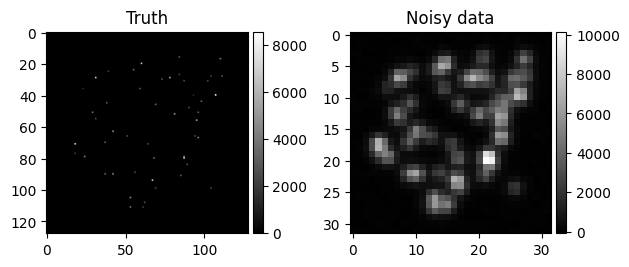

In [11]:
## plot truth and data
fig, ax = plt.subplots(ncols=2)

# truth
im = ax[0].imshow(x_im_truth, cmap='gray')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Truth')
fig.colorbar(im, cax=cax, orientation='vertical')

# data
im = ax[1].imshow(unrav(y, par['s_data']), cmap='gray')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
ax[1].set_title('Noisy data')
fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

## 2. Smoothed Laplace prior

In [12]:
class LaplaceSmoothed(cuqi.distribution.Distribution):
    def __init__(self, location, scale, beta, **kwargs):
        super().__init__(**kwargs)
        self.location = location
        self.scale = scale
        self.beta = beta
  
    def logpdf(self, x):
        if isinstance(x, (float,int)):
            x = torch.tensor([x])
        return torch.sum(torch.log(0.5/self.scale) - torch.sqrt((x-self.location)**2+self.beta)/self.scale)
    
    def gradient(self, x):
        x.requires_grad = True
        x.grad = None
        Q = self.logpdf(x)     # Forward pass
        Q.backward()           # Backward pass
        return x.grad

    def _sample(self,N=1,rng=None):
        return None

## 2. Dimension-reduced likelihood

In [2], we propose a method, the Certified Coordinate Selection, to reduce the dimension of the problem. In brief, we select the components in $x$ that contribute the most to the posterior relatively to the prior. To this end, we employ the coordinate splitting
$$x = (x_{\mathcal{I}}, x_{\mathcal{I}^c}),$$
where $x_{\mathcal{I}}$ are the selected coordinates. Then, we replace the likelihood by a ridge approximation $x_{\mathcal{I}} \mapsto \tilde{\pi}(x_{\mathcal{I}}|y)$ such that the posterior reads $\pi(x|y) \propto \tilde{\pi}(x_{\mathcal{I}}|y) \pi_0(x)$. With a proper choice of the set $\mathcal{I}$, an optimal posterior approximation (with respect to the Hellinger distance) can be constructed on $x_{\mathcal{I}}$. The ridge approximation of the likelihood function reads $\tilde{\pi}(x_{\mathcal{I}}|y) \propto \exp( -\frac{\lambda}{2} \| y - A (x_{\mathcal{I}}, x_{\mathcal{I}^c=0})\|^2)$, where $\lambda$ is the noise precision of the iid Gaussian noise. Note that $x_{\mathcal{I}}$ is not computed in this notebook, but loaded from a file. We refer the reader to [2] for further information.

The selected coordinates $x_{\mathcal{I}}$ are plotted in the following plot as black pixels.

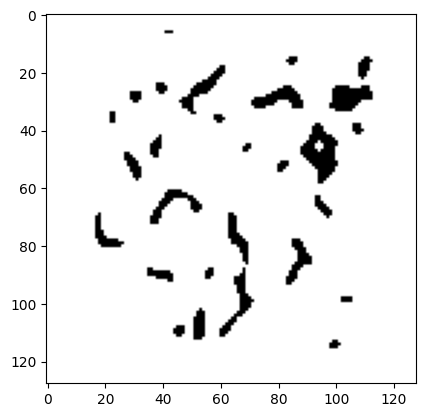

In [13]:
# truth
selected_set = np.load('I.npy')
x_selected_set = np.zeros(x_im_truth.shape)
fig = plt.figure()

temp = rav(x_selected_set)
temp[selected_set] = 1
x_selected_set = unrav(temp, 128)
plt.imshow(x_selected_set, cmap='gray_r')

## 3. Posterior sampling with CUQIpy
With the above description of the smoothed Laplace prior and reduced likelihood, we are now to define them in CUQIpy.

Here we define a `UserDefinedDistribution` by passing by functions `logpdf` and `gradient` from our previous defined `LaplaceSmoothed` object.

In [14]:
# prior
d = len(selected_set) # dimension of the problem after reduction
beta = 1e-5 # smoothing parameter
# X = Gaussian(mean = torch.zeros(d), cov=1/par['delta']**2)
X = LaplaceSmoothed(location = torch.zeros(d), scale=1/par['delta']*torch.ones(d), beta=beta)

The reduced forward solver can be defined by selecting specific columns of the full matrix. 

In [15]:
A_reduced_coo = A_mat[:,selected_set].tocoo()
values = A_reduced_coo.data
indices = np.vstack((A_reduced_coo.row, A_reduced_coo.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = A_reduced_coo.shape

A_reduced_torch = torch.sparse.FloatTensor(i, v, torch.Size(shape))#.to_dense()

/tmp/ipykernel_25871/136685143.py:9: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1716905991019/work/torch/csrc/utils/tensor_new.cpp:621.)
  A_reduced_torch = torch.sparse.FloatTensor(i, v, torch.Size(shape))#.to_dense()


In [16]:
Y = Gaussian(lambda X: torch.matmul(A_reduced_torch, X), cov= par['noise_std']**2*torch.ones(A_reduced_torch.shape[0]))

Then we can define our joint distribution and condition it on the data:

In [17]:
# joint distribution of X and Y
X_Y = JointDistribution(X, Y)
print(X_Y)

# posterior X|Y=y (condition X,Y on data y)
p = X_Y(Y=y)

JointDistribution(
    Equation: 
	p(X,Y) = p(X)p(Y|X)
    Densities: 
	X ~ CUQI LaplaceSmoothed.
	Y ~ CUQI Gaussian. Conditioning variables ['X'].
)


With the posterior object `p` defined, we are ready to draw samples from `p`. As the prior is now equipped with gradient method, we can use gradient-based samplers to draw samplers from the posterior. Here we use the Metroplis-adjusted Langevin algorithm (MALA).

In [18]:
torch.manual_seed(0)
nuts_sampler = NUTS(p) #4, 8 not working after 15 minutes

In [19]:
# nuts_samples = nuts_sampler.sample(10000, 5000)
# nuts_samples = nuts_sampler.sample(5000, 1000)
nuts_samples = nuts_sampler.sample(5000, 1000)

Warmup:   0%|          | 0/6000 [00:00, ?it/s]

Warmup:   0%|          | 1/6000 [00:00,  7.18it/s, step size=1.87e+01, acc. prob=0.000]

Warmup:   0%|          | 4/6000 [00:00, 18.68it/s, step size=2.59e+00, acc. prob=0.500]

Warmup:   0%|          | 7/6000 [00:00, 20.68it/s, step size=1.26e+00, acc. prob=0.610]

Warmup:   0%|          | 10/6000 [00:05,  1.21it/s, step size=2.47e-02, acc. prob=0.544]

Warmup:   0%|          | 12/6000 [00:12,  1.54s/it, step size=7.55e-02, acc. prob=0.616]

Warmup:   0%|          | 13/6000 [00:14,  1.65s/it, step size=7.03e-02, acc. prob=0.627]

Warmup:   0%|          | 14/6000 [00:23,  3.05s/it, step size=7.21e-02, acc. prob=0.639]

Warmup:   0%|          | 15/6000 [00:25,  2.86s/it, step size=2.47e-02, acc. prob=0.626]

Warmup:   0%|          | 16/6000 [00:34,  4.27s/it, step size=3.46e-02, acc. prob=0.643]

Warmup:   0%|          | 17/6000 [00:42,  5.41s/it, step size=5.85e-02, acc. prob=0.661]

Warmup:   0%|          | 18/6000 [00:51,  6.29s/it, step size=1.02e-01, acc. prob=0.678]

Warmup:   0%|          | 19/6000 [01:00,  6.97s/it, step size=1.19e-02, acc. prob=0.646]

Warmup:   0%|          | 20/6000 [01:09,  7.47s/it, step size=2.14e-02, acc. prob=0.662]

Warmup:   0%|          | 21/6000 [01:17,  7.83s/it, step size=3.40e-02, acc. prob=0.675]

Warmup:   0%|          | 22/6000 [01:26,  8.12s/it, step size=3.05e-02, acc. prob=0.678]

Warmup:   0%|          | 23/6000 [01:35,  8.32s/it, step size=4.17e-02, acc. prob=0.687]

Warmup:   0%|          | 24/6000 [01:44,  8.44s/it, step size=2.17e-02, acc. prob=0.681]

Warmup:   0%|          | 25/6000 [01:53,  8.55s/it, step size=3.42e-02, acc. prob=0.691]

Warmup:   0%|          | 26/6000 [02:01,  8.64s/it, step size=6.03e-02, acc. prob=0.702]

Warmup:   0%|          | 27/6000 [02:10,  8.71s/it, step size=7.32e-02, acc. prob=0.708]

Warmup:   0%|          | 28/6000 [02:19,  8.76s/it, step size=1.23e-02, acc. prob=0.687]

Warmup:   0%|          | 29/6000 [02:28,  8.79s/it, step size=2.08e-02, acc. prob=0.697]

Warmup:   0%|          | 30/6000 [02:37,  8.82s/it, step size=2.71e-02, acc. prob=0.703]

Warmup:   1%|          | 31/6000 [02:46,  8.84s/it, step size=4.87e-02, acc. prob=0.712]

Warmup:   1%|          | 32/6000 [02:55,  8.86s/it, step size=1.26e-02, acc. prob=0.698]

Warmup:   1%|          | 33/6000 [03:04,  8.87s/it, step size=2.30e-02, acc. prob=0.708]

Warmup:   1%|          | 34/6000 [03:13,  8.88s/it, step size=2.77e-02, acc. prob=0.712]

Warmup:   1%|          | 35/6000 [03:21,  8.90s/it, step size=4.28e-02, acc. prob=0.718]

Warmup:   1%|          | 36/6000 [03:30,  8.91s/it, step size=2.89e-02, acc. prob=0.716]

Warmup:   1%|          | 37/6000 [03:39,  8.92s/it, step size=2.36e-02, acc. prob=0.715]

Warmup:   1%|          | 38/6000 [03:48,  8.94s/it, step size=3.09e-02, acc. prob=0.719]

Warmup:   1%|          | 39/6000 [03:57,  8.95s/it, step size=2.69e-02, acc. prob=0.720]

Warmup:   1%|          | 40/6000 [04:06,  8.95s/it, step size=2.65e-02, acc. prob=0.721]

Warmup:   1%|          | 41/6000 [04:15,  8.96s/it, step size=3.74e-02, acc. prob=0.726]

Warmup:   1%|          | 42/6000 [04:24,  8.95s/it, step size=1.84e-02, acc. prob=0.720]

Warmup:   1%|          | 43/6000 [04:33,  8.93s/it, step size=3.20e-02, acc. prob=0.726]

Warmup:   1%|          | 44/6000 [04:42,  8.92s/it, step size=4.10e-02, acc. prob=0.730]

Warmup:   1%|          | 45/6000 [04:51,  8.90s/it, step size=1.73e-02, acc. prob=0.723]

Warmup:   1%|          | 46/6000 [05:00,  8.89s/it, step size=1.56e-02, acc. prob=0.723]

Warmup:   1%|          | 47/6000 [05:09,  8.89s/it, step size=2.33e-02, acc. prob=0.728]

Warmup:   1%|          | 48/6000 [05:17,  8.90s/it, step size=1.68e-02, acc. prob=0.726]

Warmup:   1%|          | 49/6000 [05:26,  8.92s/it, step size=1.72e-02, acc. prob=0.727]

Warmup:   1%|          | 50/6000 [05:35,  8.90s/it, step size=2.45e-02, acc. prob=0.731]

Warmup:   1%|          | 51/6000 [05:44,  8.91s/it, step size=1.60e-02, acc. prob=0.729]

Warmup:   1%|          | 52/6000 [05:53,  8.90s/it, step size=2.33e-02, acc. prob=0.733]

Warmup:   1%|          | 53/6000 [06:02,  8.90s/it, step size=3.48e-02, acc. prob=0.737]

Warmup:   1%|          | 54/6000 [06:11,  8.92s/it, step size=2.66e-02, acc. prob=0.735]

Warmup:   1%|          | 55/6000 [06:20,  8.92s/it, step size=3.29e-02, acc. prob=0.738]

Warmup:   1%|          | 56/6000 [06:29,  8.92s/it, step size=3.20e-02, acc. prob=0.738]

Warmup:   1%|          | 57/6000 [06:38,  8.92s/it, step size=4.22e-02, acc. prob=0.741]

Warmup:   1%|          | 58/6000 [06:47,  8.92s/it, step size=5.03e-02, acc. prob=0.743]

Warmup:   1%|          | 59/6000 [06:56,  8.92s/it, step size=1.27e-02, acc. prob=0.733]

Warmup:   1%|          | 60/6000 [07:04,  8.92s/it, step size=1.93e-02, acc. prob=0.737]

Warmup:   1%|          | 61/6000 [07:13,  8.92s/it, step size=2.60e-02, acc. prob=0.740]

Warmup:   1%|          | 62/6000 [07:22,  8.92s/it, step size=2.48e-02, acc. prob=0.740]

Warmup:   1%|          | 63/6000 [07:31,  8.91s/it, step size=3.95e-02, acc. prob=0.744]

Warmup:   1%|          | 64/6000 [07:40,  8.90s/it, step size=1.66e-02, acc. prob=0.739]

Warmup:   1%|          | 65/6000 [07:49,  8.88s/it, step size=2.66e-02, acc. prob=0.743]

Warmup:   1%|          | 66/6000 [07:58,  8.88s/it, step size=3.35e-02, acc. prob=0.745]

Warmup:   1%|          | 67/6000 [08:07,  8.87s/it, step size=4.78e-02, acc. prob=0.748]

Warmup:   1%|          | 68/6000 [08:15,  8.87s/it, step size=2.84e-02, acc. prob=0.745]

Warmup:   1%|          | 69/6000 [08:24,  8.87s/it, step size=3.65e-02, acc. prob=0.747]

Warmup:   1%|          | 70/6000 [08:33,  8.87s/it, step size=3.00e-02, acc. prob=0.746]

Warmup:   1%|          | 71/6000 [08:42,  8.88s/it, step size=2.27e-02, acc. prob=0.745]

Warmup:   1%|          | 72/6000 [08:51,  8.91s/it, step size=3.51e-02, acc. prob=0.748]

Warmup:   1%|          | 73/6000 [09:00,  8.91s/it, step size=4.97e-02, acc. prob=0.751]

Warmup:   1%|          | 74/6000 [09:09,  8.91s/it, step size=4.47e-02, acc. prob=0.751]

Warmup:   1%|▏         | 75/6000 [09:18,  8.91s/it, step size=1.81e-02, acc. prob=0.745]

Warmup:   1%|▏         | 76/6000 [09:27,  8.92s/it, step size=1.85e-02, acc. prob=0.746]

Warmup:   1%|▏         | 77/6000 [09:36,  8.91s/it, step size=2.85e-02, acc. prob=0.749]

Warmup:   1%|▏         | 78/6000 [09:45,  8.91s/it, step size=4.03e-02, acc. prob=0.751]

Warmup:   1%|▏         | 79/6000 [09:53,  8.91s/it, step size=3.17e-02, acc. prob=0.750]

Warmup:   1%|▏         | 80/6000 [10:02,  8.92s/it, step size=3.03e-02, acc. prob=0.750]

Warmup:   1%|▏         | 81/6000 [10:11,  8.92s/it, step size=1.75e-02, acc. prob=0.747]

Warmup:   1%|▏         | 82/6000 [10:20,  8.93s/it, step size=2.26e-02, acc. prob=0.749]

Warmup:   1%|▏         | 83/6000 [10:29,  8.93s/it, step size=2.08e-02, acc. prob=0.749]

Warmup:   1%|▏         | 84/6000 [10:38,  8.93s/it, step size=1.55e-02, acc. prob=0.748]

Warmup:   1%|▏         | 85/6000 [10:47,  8.93s/it, step size=2.37e-02, acc. prob=0.751]

Warmup:   1%|▏         | 86/6000 [10:56,  8.96s/it, step size=1.89e-02, acc. prob=0.750]

Warmup:   1%|▏         | 87/6000 [11:05,  8.95s/it, step size=2.81e-02, acc. prob=0.752]

Warmup:   1%|▏         | 88/6000 [11:14,  8.95s/it, step size=3.09e-02, acc. prob=0.753]

Warmup:   1%|▏         | 89/6000 [11:23,  8.93s/it, step size=2.85e-02, acc. prob=0.753]

Warmup:   2%|▏         | 90/6000 [11:32,  8.89s/it, step size=2.15e-02, acc. prob=0.752]

Warmup:   2%|▏         | 91/6000 [11:41,  8.89s/it, step size=3.18e-02, acc. prob=0.754]

Warmup:   2%|▏         | 92/6000 [11:49,  8.86s/it, step size=3.94e-02, acc. prob=0.756]

Warmup:   2%|▏         | 93/6000 [11:58,  8.83s/it, step size=5.12e-02, acc. prob=0.758]

Warmup:   2%|▏         | 94/6000 [12:07,  8.80s/it, step size=2.18e-02, acc. prob=0.753]

Warmup:   2%|▏         | 95/6000 [12:16,  8.80s/it, step size=2.38e-02, acc. prob=0.754]

Warmup:   2%|▏         | 96/6000 [12:24,  8.78s/it, step size=3.52e-02, acc. prob=0.756]

Warmup:   2%|▏         | 97/6000 [12:33,  8.77s/it, step size=3.08e-02, acc. prob=0.756]

Warmup:   2%|▏         | 98/6000 [12:42,  8.76s/it, step size=2.86e-02, acc. prob=0.756]

Warmup:   2%|▏         | 99/6000 [12:51,  8.76s/it, step size=4.91e-02, acc. prob=0.755]

Warmup:   2%|▏         | 100/6000 [12:53,  6.78s/it, step size=1.17e-01, acc. prob=0.748]

Warmup:   2%|▏         | 101/6000 [12:53,  4.79s/it, step size=1.16e-02, acc. prob=0.740]

Warmup:   2%|▏         | 102/6000 [13:02,  5.96s/it, step size=8.69e-04, acc. prob=0.733]

Warmup:   2%|▏         | 103/6000 [13:10,  6.79s/it, step size=8.62e-04, acc. prob=0.735]

Warmup:   2%|▏         | 104/6000 [13:19,  7.35s/it, step size=1.17e-03, acc. prob=0.738]

Warmup:   2%|▏         | 105/6000 [13:28,  7.75s/it, step size=1.37e-03, acc. prob=0.740]

Warmup:   2%|▏         | 106/6000 [13:36,  8.03s/it, step size=1.89e-03, acc. prob=0.741]

Warmup:   2%|▏         | 107/6000 [13:45,  8.21s/it, step size=1.93e-03, acc. prob=0.742]

Warmup:   2%|▏         | 108/6000 [13:54,  8.33s/it, step size=2.32e-03, acc. prob=0.743]

Warmup:   2%|▏         | 109/6000 [14:02,  8.41s/it, step size=4.33e-03, acc. prob=0.746]

Warmup:   2%|▏         | 110/6000 [14:11,  8.48s/it, step size=3.92e-03, acc. prob=0.746]

Warmup:   2%|▏         | 111/6000 [14:20,  8.53s/it, step size=1.11e-03, acc. prob=0.743]

Warmup:   2%|▏         | 112/6000 [14:28,  8.57s/it, step size=1.77e-03, acc. prob=0.744]

Warmup:   2%|▏         | 113/6000 [14:37,  8.59s/it, step size=1.46e-03, acc. prob=0.744]

Warmup:   2%|▏         | 114/6000 [14:45,  8.60s/it, step size=2.21e-03, acc. prob=0.746]

Warmup:   2%|▏         | 115/6000 [14:54,  8.62s/it, step size=3.01e-03, acc. prob=0.747]

Warmup:   2%|▏         | 116/6000 [15:03,  8.64s/it, step size=1.39e-03, acc. prob=0.745]

Warmup:   2%|▏         | 117/6000 [15:11,  8.66s/it, step size=1.78e-03, acc. prob=0.746]

Warmup:   2%|▏         | 118/6000 [15:20,  8.67s/it, step size=1.34e-03, acc. prob=0.746]

Warmup:   2%|▏         | 119/6000 [15:29,  8.68s/it, step size=1.74e-03, acc. prob=0.747]

Warmup:   2%|▏         | 120/6000 [15:38,  8.69s/it, step size=3.07e-03, acc. prob=0.749]

Warmup:   2%|▏         | 121/6000 [15:46,  8.70s/it, step size=1.02e-03, acc. prob=0.746]

Warmup:   2%|▏         | 122/6000 [15:55,  8.72s/it, step size=1.57e-03, acc. prob=0.747]

Warmup:   2%|▏         | 123/6000 [16:04,  8.74s/it, step size=1.13e-03, acc. prob=0.747]

Warmup:   2%|▏         | 124/6000 [16:13,  8.74s/it, step size=1.47e-03, acc. prob=0.748]

Warmup:   2%|▏         | 125/6000 [16:21,  8.74s/it, step size=2.65e-03, acc. prob=0.750]

Warmup:   2%|▏         | 126/6000 [16:30,  8.75s/it, step size=3.77e-03, acc. prob=0.751]

Warmup:   2%|▏         | 127/6000 [16:39,  8.75s/it, step size=1.15e-03, acc. prob=0.748]

Warmup:   2%|▏         | 128/6000 [16:48,  8.75s/it, step size=1.88e-03, acc. prob=0.750]

Warmup:   2%|▏         | 129/6000 [16:56,  8.76s/it, step size=2.75e-03, acc. prob=0.751]

Warmup:   2%|▏         | 130/6000 [17:05,  8.76s/it, step size=3.35e-03, acc. prob=0.752]

Warmup:   2%|▏         | 131/6000 [17:14,  8.76s/it, step size=2.15e-03, acc. prob=0.751]

Warmup:   2%|▏         | 132/6000 [17:23,  8.76s/it, step size=2.37e-03, acc. prob=0.751]

Warmup:   2%|▏         | 133/6000 [17:31,  8.77s/it, step size=2.78e-03, acc. prob=0.752]

Warmup:   2%|▏         | 134/6000 [17:40,  8.77s/it, step size=8.10e-04, acc. prob=0.749]

Warmup:   2%|▏         | 135/6000 [17:49,  8.77s/it, step size=1.38e-03, acc. prob=0.751]

Warmup:   2%|▏         | 136/6000 [17:58,  8.78s/it, step size=2.38e-03, acc. prob=0.752]

Warmup:   2%|▏         | 137/6000 [18:07,  8.79s/it, step size=3.36e-03, acc. prob=0.753]

Warmup:   2%|▏         | 138/6000 [18:15,  8.80s/it, step size=2.92e-03, acc. prob=0.753]

Warmup:   2%|▏         | 139/6000 [18:24,  8.81s/it, step size=3.75e-03, acc. prob=0.754]

Warmup:   2%|▏         | 140/6000 [18:33,  8.82s/it, step size=4.59e-03, acc. prob=0.755]

Warmup:   2%|▏         | 141/6000 [18:42,  8.83s/it, step size=3.37e-03, acc. prob=0.754]

Warmup:   2%|▏         | 142/6000 [18:51,  8.84s/it, step size=4.47e-03, acc. prob=0.755]

Warmup:   2%|▏         | 143/6000 [19:00,  8.85s/it, step size=1.51e-03, acc. prob=0.753]

Warmup:   2%|▏         | 144/6000 [19:09,  8.84s/it, step size=1.59e-03, acc. prob=0.753]

Warmup:   2%|▏         | 145/6000 [19:17,  8.84s/it, step size=2.63e-03, acc. prob=0.755]

Warmup:   2%|▏         | 146/6000 [19:26,  8.85s/it, step size=2.80e-03, acc. prob=0.755]

Warmup:   2%|▏         | 147/6000 [19:35,  8.85s/it, step size=1.14e-03, acc. prob=0.753]

Warmup:   2%|▏         | 148/6000 [19:44,  8.83s/it, step size=1.55e-03, acc. prob=0.754]

Warmup:   2%|▏         | 149/6000 [19:53,  8.83s/it, step size=1.56e-02, acc. prob=0.755]

Warmup:   2%|▎         | 150/6000 [19:57,  7.42s/it, step size=3.66e-02, acc. prob=0.750]

Warmup:   3%|▎         | 151/6000 [19:57,  5.31s/it, step size=3.62e-03, acc. prob=0.745]

Warmup:   3%|▎         | 152/6000 [20:06,  6.33s/it, step size=3.04e-04, acc. prob=0.740]

Warmup:   3%|▎         | 153/6000 [20:15,  7.04s/it, step size=2.84e-04, acc. prob=0.741]

Warmup:   3%|▎         | 154/6000 [20:23,  7.54s/it, step size=3.81e-04, acc. prob=0.743]

Warmup:   3%|▎         | 155/6000 [20:32,  7.89s/it, step size=5.61e-04, acc. prob=0.744]

Warmup:   3%|▎         | 156/6000 [20:41,  8.14s/it, step size=9.51e-04, acc. prob=0.746]

Warmup:   3%|▎         | 157/6000 [20:49,  8.31s/it, step size=3.02e-04, acc. prob=0.744]

Warmup:   3%|▎         | 158/6000 [20:58,  8.43s/it, step size=4.34e-04, acc. prob=0.745]

Warmup:   3%|▎         | 159/6000 [21:07,  8.52s/it, step size=7.98e-04, acc. prob=0.747]

Warmup:   3%|▎         | 160/6000 [21:16,  8.57s/it, step size=7.09e-04, acc. prob=0.747]

Warmup:   3%|▎         | 161/6000 [21:24,  8.61s/it, step size=1.16e-03, acc. prob=0.748]

Warmup:   3%|▎         | 162/6000 [21:33,  8.63s/it, step size=2.00e-03, acc. prob=0.750]

Warmup:   3%|▎         | 163/6000 [21:42,  8.65s/it, step size=6.59e-04, acc. prob=0.748]

Warmup:   3%|▎         | 164/6000 [21:50,  8.67s/it, step size=1.06e-03, acc. prob=0.749]

Warmup:   3%|▎         | 165/6000 [21:59,  8.67s/it, step size=5.01e-04, acc. prob=0.748]

Warmup:   3%|▎         | 166/6000 [22:08,  8.68s/it, step size=6.23e-04, acc. prob=0.748]

Warmup:   3%|▎         | 167/6000 [22:16,  8.68s/it, step size=6.19e-04, acc. prob=0.748]

Warmup:   3%|▎         | 168/6000 [22:25,  8.69s/it, step size=8.28e-04, acc. prob=0.749]

Warmup:   3%|▎         | 169/6000 [22:34,  8.70s/it, step size=5.84e-04, acc. prob=0.749]

Warmup:   3%|▎         | 170/6000 [22:43,  8.70s/it, step size=2.49e-04, acc. prob=0.747]

Warmup:   3%|▎         | 171/6000 [22:51,  8.70s/it, step size=4.70e-04, acc. prob=0.749]

Warmup:   3%|▎         | 172/6000 [23:00,  8.71s/it, step size=7.77e-04, acc. prob=0.750]

Warmup:   3%|▎         | 173/6000 [23:09,  8.72s/it, step size=1.04e-03, acc. prob=0.751]

Warmup:   3%|▎         | 174/6000 [23:18,  8.73s/it, step size=1.84e-03, acc. prob=0.752]

Warmup:   3%|▎         | 175/6000 [23:26,  8.73s/it, step size=1.10e-03, acc. prob=0.751]

Warmup:   3%|▎         | 176/6000 [23:35,  8.73s/it, step size=3.36e-04, acc. prob=0.749]

Warmup:   3%|▎         | 177/6000 [23:44,  8.73s/it, step size=3.61e-04, acc. prob=0.749]

Warmup:   3%|▎         | 178/6000 [23:52,  8.72s/it, step size=6.37e-04, acc. prob=0.751]

Warmup:   3%|▎         | 179/6000 [24:01,  8.71s/it, step size=1.07e-03, acc. prob=0.752]

Warmup:   3%|▎         | 180/6000 [24:10,  8.70s/it, step size=6.62e-04, acc. prob=0.751]

Warmup:   3%|▎         | 181/6000 [24:18,  8.70s/it, step size=8.79e-04, acc. prob=0.752]

Warmup:   3%|▎         | 182/6000 [24:27,  8.70s/it, step size=1.52e-03, acc. prob=0.753]

Warmup:   3%|▎         | 183/6000 [24:36,  8.70s/it, step size=3.64e-04, acc. prob=0.750]

Warmup:   3%|▎         | 184/6000 [24:45,  8.70s/it, step size=6.44e-04, acc. prob=0.752]

Warmup:   3%|▎         | 185/6000 [24:53,  8.70s/it, step size=8.15e-04, acc. prob=0.752]

Warmup:   3%|▎         | 186/6000 [25:02,  8.70s/it, step size=8.90e-04, acc. prob=0.753]

Warmup:   3%|▎         | 187/6000 [25:11,  8.70s/it, step size=1.27e-03, acc. prob=0.754]

Warmup:   3%|▎         | 188/6000 [25:19,  8.70s/it, step size=1.54e-03, acc. prob=0.754]

Warmup:   3%|▎         | 189/6000 [25:28,  8.71s/it, step size=6.42e-04, acc. prob=0.753]

Warmup:   3%|▎         | 190/6000 [25:37,  8.72s/it, step size=8.42e-04, acc. prob=0.753]

Warmup:   3%|▎         | 191/6000 [25:46,  8.74s/it, step size=1.22e-03, acc. prob=0.754]

Warmup:   3%|▎         | 192/6000 [25:54,  8.75s/it, step size=5.07e-04, acc. prob=0.753]

Warmup:   3%|▎         | 193/6000 [26:03,  8.77s/it, step size=8.58e-04, acc. prob=0.754]

Warmup:   3%|▎         | 194/6000 [26:12,  8.78s/it, step size=1.17e-03, acc. prob=0.755]

Warmup:   3%|▎         | 195/6000 [26:21,  8.80s/it, step size=1.66e-03, acc. prob=0.756]

Warmup:   3%|▎         | 196/6000 [26:30,  8.81s/it, step size=4.01e-04, acc. prob=0.753]

Warmup:   3%|▎         | 197/6000 [26:39,  8.81s/it, step size=6.69e-04, acc. prob=0.754]

Warmup:   3%|▎         | 198/6000 [26:47,  8.81s/it, step size=7.58e-04, acc. prob=0.754]

Warmup:   3%|▎         | 199/6000 [26:56,  8.81s/it, step size=1.21e-03, acc. prob=0.756]

Warmup:   3%|▎         | 200/6000 [27:05,  8.81s/it, step size=5.51e-04, acc. prob=0.754]

Warmup:   3%|▎         | 201/6000 [27:14,  8.81s/it, step size=5.91e-04, acc. prob=0.754]

Warmup:   3%|▎         | 202/6000 [27:23,  8.81s/it, step size=9.22e-04, acc. prob=0.755]

Warmup:   3%|▎         | 203/6000 [27:31,  8.81s/it, step size=1.07e-03, acc. prob=0.756]

Warmup:   3%|▎         | 204/6000 [27:40,  8.80s/it, step size=1.29e-03, acc. prob=0.756]

Warmup:   3%|▎         | 205/6000 [27:49,  8.78s/it, step size=6.34e-04, acc. prob=0.755]

Warmup:   3%|▎         | 206/6000 [27:58,  8.76s/it, step size=6.17e-04, acc. prob=0.755]

Warmup:   3%|▎         | 207/6000 [28:06,  8.75s/it, step size=9.84e-04, acc. prob=0.756]

Warmup:   3%|▎         | 208/6000 [28:15,  8.74s/it, step size=4.23e-04, acc. prob=0.755]

Warmup:   3%|▎         | 209/6000 [28:24,  8.74s/it, step size=6.78e-04, acc. prob=0.756]

Warmup:   4%|▎         | 210/6000 [28:33,  8.73s/it, step size=6.45e-04, acc. prob=0.756]

Warmup:   4%|▎         | 211/6000 [28:41,  8.73s/it, step size=7.59e-04, acc. prob=0.756]

Warmup:   4%|▎         | 212/6000 [28:50,  8.73s/it, step size=3.14e-04, acc. prob=0.755]

Warmup:   4%|▎         | 213/6000 [28:59,  8.72s/it, step size=5.01e-04, acc. prob=0.756]

Warmup:   4%|▎         | 214/6000 [29:07,  8.72s/it, step size=5.80e-04, acc. prob=0.756]

Warmup:   4%|▎         | 215/6000 [29:16,  8.72s/it, step size=9.10e-04, acc. prob=0.757]

Warmup:   4%|▎         | 216/6000 [29:25,  8.73s/it, step size=1.20e-03, acc. prob=0.758]

Warmup:   4%|▎         | 217/6000 [29:34,  8.73s/it, step size=4.59e-04, acc. prob=0.756]

Warmup:   4%|▎         | 218/6000 [29:42,  8.72s/it, step size=5.25e-04, acc. prob=0.756]

Warmup:   4%|▎         | 219/6000 [29:51,  8.72s/it, step size=7.24e-04, acc. prob=0.757]

Warmup:   4%|▎         | 220/6000 [30:00,  8.72s/it, step size=9.69e-04, acc. prob=0.758]

Warmup:   4%|▎         | 221/6000 [30:08,  8.72s/it, step size=1.08e-03, acc. prob=0.758]

Warmup:   4%|▎         | 222/6000 [30:17,  8.72s/it, step size=4.59e-04, acc. prob=0.757]

Warmup:   4%|▎         | 223/6000 [30:26,  8.72s/it, step size=6.85e-04, acc. prob=0.758]

Warmup:   4%|▎         | 224/6000 [30:35,  8.72s/it, step size=5.26e-04, acc. prob=0.757]

Warmup:   4%|▍         | 225/6000 [30:43,  8.72s/it, step size=3.72e-04, acc. prob=0.757]

Warmup:   4%|▍         | 226/6000 [30:52,  8.72s/it, step size=4.44e-04, acc. prob=0.757]

Warmup:   4%|▍         | 227/6000 [31:01,  8.73s/it, step size=5.70e-04, acc. prob=0.758]

Warmup:   4%|▍         | 228/6000 [31:10,  8.72s/it, step size=6.23e-04, acc. prob=0.758]

Warmup:   4%|▍         | 229/6000 [31:18,  8.73s/it, step size=4.67e-04, acc. prob=0.758]

Warmup:   4%|▍         | 230/6000 [31:27,  8.74s/it, step size=5.01e-04, acc. prob=0.758]

Warmup:   4%|▍         | 231/6000 [31:36,  8.76s/it, step size=7.63e-04, acc. prob=0.759]

Warmup:   4%|▍         | 232/6000 [31:45,  8.77s/it, step size=6.48e-04, acc. prob=0.759]

Warmup:   4%|▍         | 233/6000 [31:53,  8.78s/it, step size=5.59e-04, acc. prob=0.759]

Warmup:   4%|▍         | 234/6000 [32:02,  8.79s/it, step size=3.37e-04, acc. prob=0.758]

Warmup:   4%|▍         | 235/6000 [32:11,  8.79s/it, step size=5.00e-04, acc. prob=0.759]

Warmup:   4%|▍         | 236/6000 [32:20,  8.79s/it, step size=7.02e-04, acc. prob=0.759]

Warmup:   4%|▍         | 237/6000 [32:29,  8.79s/it, step size=1.05e-03, acc. prob=0.760]

Warmup:   4%|▍         | 238/6000 [32:37,  8.78s/it, step size=1.28e-03, acc. prob=0.761]

Warmup:   4%|▍         | 239/6000 [32:46,  8.77s/it, step size=3.76e-04, acc. prob=0.758]

Warmup:   4%|▍         | 240/6000 [32:55,  8.76s/it, step size=5.48e-04, acc. prob=0.759]

Warmup:   4%|▍         | 241/6000 [33:04,  8.76s/it, step size=7.47e-04, acc. prob=0.760]

Warmup:   4%|▍         | 242/6000 [33:12,  8.77s/it, step size=7.13e-04, acc. prob=0.760]

Warmup:   4%|▍         | 243/6000 [33:21,  8.77s/it, step size=7.10e-04, acc. prob=0.760]

Warmup:   4%|▍         | 244/6000 [33:30,  8.77s/it, step size=4.89e-04, acc. prob=0.760]

Warmup:   4%|▍         | 245/6000 [33:39,  8.76s/it, step size=4.88e-04, acc. prob=0.760]

Warmup:   4%|▍         | 246/6000 [33:47,  8.76s/it, step size=7.09e-04, acc. prob=0.761]

Warmup:   4%|▍         | 247/6000 [33:56,  8.77s/it, step size=9.22e-04, acc. prob=0.761]

Warmup:   4%|▍         | 248/6000 [34:05,  8.78s/it, step size=1.09e-03, acc. prob=0.762]

Warmup:   4%|▍         | 249/6000 [34:14,  8.83s/it, step size=1.90e-02, acc. prob=0.762]

Warmup:   4%|▍         | 250/6000 [34:17,  7.17s/it, step size=4.45e-02, acc. prob=0.759]

Warmup:   4%|▍         | 252/6000 [34:26,  5.90s/it, step size=3.81e-04, acc. prob=0.753]

Warmup:   4%|▍         | 253/6000 [34:35,  6.62s/it, step size=4.01e-04, acc. prob=0.754]

Warmup:   4%|▍         | 254/6000 [34:44,  7.19s/it, step size=4.75e-04, acc. prob=0.755]

Warmup:   4%|▍         | 255/6000 [34:53,  7.63s/it, step size=4.50e-04, acc. prob=0.755]

Warmup:   4%|▍         | 256/6000 [35:01,  7.96s/it, step size=7.52e-04, acc. prob=0.756]

Warmup:   4%|▍         | 257/6000 [35:10,  8.20s/it, step size=1.14e-03, acc. prob=0.757]

Warmup:   4%|▍         | 258/6000 [35:19,  8.38s/it, step size=1.56e-03, acc. prob=0.757]

Warmup:   4%|▍         | 259/6000 [35:28,  8.50s/it, step size=2.93e-04, acc. prob=0.756]

Warmup:   4%|▍         | 260/6000 [35:37,  8.59s/it, step size=5.51e-04, acc. prob=0.757]

Warmup:   4%|▍         | 261/6000 [35:45,  8.66s/it, step size=6.28e-04, acc. prob=0.757]

Warmup:   4%|▍         | 262/6000 [35:54,  8.71s/it, step size=1.00e-03, acc. prob=0.758]

Warmup:   4%|▍         | 263/6000 [36:03,  8.74s/it, step size=9.97e-04, acc. prob=0.758]

Warmup:   4%|▍         | 264/6000 [36:12,  8.76s/it, step size=3.16e-04, acc. prob=0.756]

Warmup:   4%|▍         | 265/6000 [36:21,  8.77s/it, step size=5.86e-04, acc. prob=0.757]

Warmup:   4%|▍         | 266/6000 [36:29,  8.77s/it, step size=7.09e-04, acc. prob=0.758]

Warmup:   4%|▍         | 267/6000 [36:38,  8.77s/it, step size=1.26e-03, acc. prob=0.758]

Warmup:   4%|▍         | 268/6000 [36:47,  8.76s/it, step size=1.00e-03, acc. prob=0.758]

Warmup:   4%|▍         | 269/6000 [36:56,  8.76s/it, step size=1.64e-03, acc. prob=0.759]

Warmup:   4%|▍         | 270/6000 [37:04,  8.76s/it, step size=9.02e-04, acc. prob=0.758]

Warmup:   5%|▍         | 271/6000 [37:13,  8.75s/it, step size=1.63e-03, acc. prob=0.759]

Warmup:   5%|▍         | 272/6000 [37:22,  8.76s/it, step size=6.29e-04, acc. prob=0.758]

Warmup:   5%|▍         | 273/6000 [37:31,  8.75s/it, step size=7.51e-04, acc. prob=0.758]

Warmup:   5%|▍         | 274/6000 [37:39,  8.75s/it, step size=6.29e-04, acc. prob=0.758]

Warmup:   5%|▍         | 275/6000 [37:48,  8.75s/it, step size=4.51e-04, acc. prob=0.758]

Warmup:   5%|▍         | 276/6000 [37:57,  8.75s/it, step size=5.83e-04, acc. prob=0.758]

Warmup:   5%|▍         | 277/6000 [38:06,  8.74s/it, step size=6.69e-04, acc. prob=0.759]

Warmup:   5%|▍         | 278/6000 [38:14,  8.75s/it, step size=1.05e-03, acc. prob=0.759]

Warmup:   5%|▍         | 279/6000 [38:23,  8.76s/it, step size=3.90e-04, acc. prob=0.758]

Warmup:   5%|▍         | 280/6000 [38:32,  8.77s/it, step size=6.60e-04, acc. prob=0.759]

Warmup:   5%|▍         | 281/6000 [38:41,  8.78s/it, step size=9.43e-04, acc. prob=0.759]

Warmup:   5%|▍         | 282/6000 [38:50,  8.78s/it, step size=6.19e-04, acc. prob=0.759]

Warmup:   5%|▍         | 283/6000 [38:58,  8.78s/it, step size=6.99e-04, acc. prob=0.759]

Warmup:   5%|▍         | 284/6000 [39:07,  8.78s/it, step size=8.17e-04, acc. prob=0.759]

Warmup:   5%|▍         | 285/6000 [39:16,  8.78s/it, step size=1.20e-03, acc. prob=0.760]

Warmup:   5%|▍         | 286/6000 [39:25,  8.78s/it, step size=6.84e-04, acc. prob=0.759]

Warmup:   5%|▍         | 287/6000 [39:34,  8.78s/it, step size=7.27e-04, acc. prob=0.759]

Warmup:   5%|▍         | 288/6000 [39:42,  8.79s/it, step size=1.23e-03, acc. prob=0.760]

Warmup:   5%|▍         | 289/6000 [39:51,  8.79s/it, step size=2.94e-04, acc. prob=0.758]

Warmup:   5%|▍         | 290/6000 [40:00,  8.78s/it, step size=4.85e-04, acc. prob=0.759]

Warmup:   5%|▍         | 291/6000 [40:09,  8.78s/it, step size=4.37e-04, acc. prob=0.759]

Warmup:   5%|▍         | 292/6000 [40:17,  8.78s/it, step size=6.55e-04, acc. prob=0.760]

Warmup:   5%|▍         | 293/6000 [40:26,  8.78s/it, step size=1.11e-03, acc. prob=0.761]

Warmup:   5%|▍         | 294/6000 [40:35,  8.78s/it, step size=1.02e-03, acc. prob=0.761]

Warmup:   5%|▍         | 295/6000 [40:44,  8.78s/it, step size=5.92e-04, acc. prob=0.760]

Warmup:   5%|▍         | 296/6000 [40:53,  8.79s/it, step size=9.89e-04, acc. prob=0.761]

Warmup:   5%|▍         | 297/6000 [41:01,  8.79s/it, step size=1.38e-03, acc. prob=0.761]

Warmup:   5%|▍         | 298/6000 [41:10,  8.79s/it, step size=8.19e-04, acc. prob=0.761]

Warmup:   5%|▍         | 299/6000 [41:19,  8.79s/it, step size=9.80e-04, acc. prob=0.761]

Warmup:   5%|▌         | 300/6000 [41:28,  8.79s/it, step size=1.61e-03, acc. prob=0.762]

Warmup:   5%|▌         | 301/6000 [41:37,  8.80s/it, step size=4.39e-04, acc. prob=0.760]

Warmup:   5%|▌         | 302/6000 [41:45,  8.80s/it, step size=7.12e-04, acc. prob=0.761]

Warmup:   5%|▌         | 303/6000 [41:54,  8.80s/it, step size=1.10e-03, acc. prob=0.761]

Warmup:   5%|▌         | 304/6000 [42:03,  8.80s/it, step size=1.14e-03, acc. prob=0.762]

Warmup:   5%|▌         | 305/6000 [42:12,  8.79s/it, step size=5.40e-04, acc. prob=0.761]

Warmup:   5%|▌         | 306/6000 [42:21,  8.79s/it, step size=6.54e-04, acc. prob=0.761]

Warmup:   5%|▌         | 307/6000 [42:29,  8.79s/it, step size=8.49e-04, acc. prob=0.761]

Warmup:   5%|▌         | 308/6000 [42:38,  8.80s/it, step size=7.52e-04, acc. prob=0.761]

Warmup:   5%|▌         | 309/6000 [42:47,  8.80s/it, step size=1.07e-03, acc. prob=0.762]

Warmup:   5%|▌         | 310/6000 [42:56,  8.80s/it, step size=5.50e-04, acc. prob=0.761]

Warmup:   5%|▌         | 311/6000 [43:05,  8.80s/it, step size=8.52e-04, acc. prob=0.762]

Warmup:   5%|▌         | 312/6000 [43:13,  8.80s/it, step size=6.48e-04, acc. prob=0.761]

Warmup:   5%|▌         | 313/6000 [43:22,  8.80s/it, step size=8.61e-04, acc. prob=0.762]

Warmup:   5%|▌         | 314/6000 [43:31,  8.81s/it, step size=1.12e-03, acc. prob=0.762]

Warmup:   5%|▌         | 315/6000 [43:40,  8.81s/it, step size=8.25e-04, acc. prob=0.762]

Warmup:   5%|▌         | 316/6000 [43:49,  8.82s/it, step size=1.22e-03, acc. prob=0.763]

Warmup:   5%|▌         | 317/6000 [43:57,  8.81s/it, step size=5.15e-04, acc. prob=0.761]

Warmup:   5%|▌         | 318/6000 [44:06,  8.83s/it, step size=7.49e-04, acc. prob=0.762]

Warmup:   5%|▌         | 319/6000 [44:15,  8.83s/it, step size=9.65e-04, acc. prob=0.762]

Warmup:   5%|▌         | 320/6000 [44:24,  8.84s/it, step size=3.72e-04, acc. prob=0.761]

Warmup:   5%|▌         | 321/6000 [44:33,  8.84s/it, step size=4.94e-04, acc. prob=0.762]

Warmup:   5%|▌         | 322/6000 [44:42,  8.84s/it, step size=5.30e-04, acc. prob=0.762]

Warmup:   5%|▌         | 323/6000 [44:50,  8.84s/it, step size=6.79e-04, acc. prob=0.762]

Warmup:   5%|▌         | 324/6000 [44:59,  8.85s/it, step size=6.74e-04, acc. prob=0.762]

Warmup:   5%|▌         | 325/6000 [45:08,  8.84s/it, step size=5.07e-04, acc. prob=0.762]

Warmup:   5%|▌         | 326/6000 [45:17,  8.83s/it, step size=7.02e-04, acc. prob=0.762]

Warmup:   5%|▌         | 327/6000 [45:26,  8.83s/it, step size=8.07e-04, acc. prob=0.763]

Warmup:   5%|▌         | 328/6000 [45:35,  8.82s/it, step size=1.01e-03, acc. prob=0.763]

Warmup:   5%|▌         | 329/6000 [45:43,  8.82s/it, step size=1.32e-03, acc. prob=0.764]

Warmup:   6%|▌         | 330/6000 [45:52,  8.82s/it, step size=4.64e-04, acc. prob=0.762]

Warmup:   6%|▌         | 331/6000 [46:01,  8.82s/it, step size=6.12e-04, acc. prob=0.763]

Warmup:   6%|▌         | 332/6000 [46:10,  8.82s/it, step size=8.10e-04, acc. prob=0.763]

Warmup:   6%|▌         | 333/6000 [46:19,  8.81s/it, step size=1.22e-03, acc. prob=0.764]

Warmup:   6%|▌         | 334/6000 [46:27,  8.80s/it, step size=3.87e-04, acc. prob=0.762]

Warmup:   6%|▌         | 335/6000 [46:36,  8.81s/it, step size=5.02e-04, acc. prob=0.763]

Warmup:   6%|▌         | 336/6000 [46:45,  8.80s/it, step size=4.30e-04, acc. prob=0.762]

Warmup:   6%|▌         | 337/6000 [46:54,  8.80s/it, step size=5.28e-04, acc. prob=0.763]

Warmup:   6%|▌         | 338/6000 [47:03,  8.80s/it, step size=7.85e-04, acc. prob=0.763]

Warmup:   6%|▌         | 339/6000 [47:11,  8.80s/it, step size=6.96e-04, acc. prob=0.763]

Warmup:   6%|▌         | 340/6000 [47:20,  8.80s/it, step size=6.40e-04, acc. prob=0.763]

Warmup:   6%|▌         | 341/6000 [47:29,  8.80s/it, step size=7.78e-04, acc. prob=0.764]

Warmup:   6%|▌         | 342/6000 [47:38,  8.79s/it, step size=1.11e-03, acc. prob=0.764]

Warmup:   6%|▌         | 343/6000 [47:47,  8.79s/it, step size=1.25e-03, acc. prob=0.765]

Warmup:   6%|▌         | 344/6000 [47:55,  8.79s/it, step size=5.29e-04, acc. prob=0.763]

Warmup:   6%|▌         | 345/6000 [48:04,  8.79s/it, step size=5.50e-04, acc. prob=0.763]

Warmup:   6%|▌         | 346/6000 [48:13,  8.79s/it, step size=7.89e-04, acc. prob=0.764]

Warmup:   6%|▌         | 347/6000 [48:22,  8.79s/it, step size=5.61e-04, acc. prob=0.764]

Warmup:   6%|▌         | 348/6000 [48:31,  8.79s/it, step size=6.63e-04, acc. prob=0.764]

Warmup:   6%|▌         | 349/6000 [48:39,  8.79s/it, step size=9.67e-04, acc. prob=0.765]

Warmup:   6%|▌         | 350/6000 [48:48,  8.79s/it, step size=1.08e-03, acc. prob=0.765]

Warmup:   6%|▌         | 351/6000 [48:57,  8.79s/it, step size=1.35e-03, acc. prob=0.765]

Warmup:   6%|▌         | 352/6000 [49:06,  8.79s/it, step size=4.89e-04, acc. prob=0.764]

Warmup:   6%|▌         | 353/6000 [49:15,  8.79s/it, step size=6.94e-04, acc. prob=0.764]

Warmup:   6%|▌         | 354/6000 [49:23,  8.79s/it, step size=8.73e-04, acc. prob=0.765]

Warmup:   6%|▌         | 355/6000 [49:32,  8.79s/it, step size=1.09e-03, acc. prob=0.765]

Warmup:   6%|▌         | 356/6000 [49:41,  8.78s/it, step size=1.00e-03, acc. prob=0.765]

Warmup:   6%|▌         | 357/6000 [49:50,  8.78s/it, step size=1.42e-03, acc. prob=0.766]

Warmup:   6%|▌         | 358/6000 [49:58,  8.78s/it, step size=9.00e-04, acc. prob=0.765]

Warmup:   6%|▌         | 359/6000 [50:07,  8.79s/it, step size=8.67e-04, acc. prob=0.765]

Warmup:   6%|▌         | 360/6000 [50:16,  8.78s/it, step size=8.31e-04, acc. prob=0.765]

Warmup:   6%|▌         | 361/6000 [50:25,  8.78s/it, step size=1.20e-03, acc. prob=0.766]

Warmup:   6%|▌         | 362/6000 [50:34,  8.80s/it, step size=6.16e-04, acc. prob=0.765]

Warmup:   6%|▌         | 363/6000 [50:42,  8.81s/it, step size=8.47e-04, acc. prob=0.765]

Warmup:   6%|▌         | 364/6000 [50:51,  8.82s/it, step size=1.08e-03, acc. prob=0.766]

Warmup:   6%|▌         | 365/6000 [51:00,  8.83s/it, step size=6.89e-04, acc. prob=0.765]

Warmup:   6%|▌         | 366/6000 [51:09,  8.84s/it, step size=6.36e-04, acc. prob=0.765]

Warmup:   6%|▌         | 367/6000 [51:18,  8.85s/it, step size=8.48e-04, acc. prob=0.766]

Warmup:   6%|▌         | 368/6000 [51:27,  8.85s/it, step size=9.28e-04, acc. prob=0.766]

Warmup:   6%|▌         | 369/6000 [51:36,  8.84s/it, step size=8.43e-04, acc. prob=0.766]

Warmup:   6%|▌         | 370/6000 [51:44,  8.83s/it, step size=5.76e-04, acc. prob=0.765]

Warmup:   6%|▌         | 371/6000 [51:53,  8.83s/it, step size=5.33e-04, acc. prob=0.765]

Warmup:   6%|▌         | 372/6000 [52:02,  8.81s/it, step size=5.36e-04, acc. prob=0.765]

Warmup:   6%|▌         | 373/6000 [52:11,  8.80s/it, step size=5.21e-04, acc. prob=0.765]

Warmup:   6%|▌         | 374/6000 [52:20,  8.80s/it, step size=6.58e-04, acc. prob=0.766]

Warmup:   6%|▋         | 375/6000 [52:28,  8.81s/it, step size=5.68e-04, acc. prob=0.765]

Warmup:   6%|▋         | 376/6000 [52:37,  8.81s/it, step size=7.27e-04, acc. prob=0.766]

Warmup:   6%|▋         | 377/6000 [52:46,  8.81s/it, step size=6.67e-04, acc. prob=0.766]

Warmup:   6%|▋         | 378/6000 [52:55,  8.81s/it, step size=7.61e-04, acc. prob=0.766]

Warmup:   6%|▋         | 379/6000 [53:04,  8.81s/it, step size=5.68e-04, acc. prob=0.766]

Warmup:   6%|▋         | 380/6000 [53:12,  8.82s/it, step size=5.91e-04, acc. prob=0.766]

Warmup:   6%|▋         | 381/6000 [53:21,  8.82s/it, step size=7.43e-04, acc. prob=0.766]

Warmup:   6%|▋         | 382/6000 [53:30,  8.82s/it, step size=5.47e-04, acc. prob=0.766]

Warmup:   6%|▋         | 383/6000 [53:39,  8.83s/it, step size=5.07e-04, acc. prob=0.766]

Warmup:   6%|▋         | 384/6000 [53:48,  8.83s/it, step size=7.05e-04, acc. prob=0.766]

Warmup:   6%|▋         | 385/6000 [53:57,  8.81s/it, step size=9.74e-04, acc. prob=0.767]

Warmup:   6%|▋         | 386/6000 [54:05,  8.81s/it, step size=7.56e-04, acc. prob=0.767]

Warmup:   6%|▋         | 387/6000 [54:14,  8.81s/it, step size=1.05e-03, acc. prob=0.767]

Warmup:   6%|▋         | 388/6000 [54:23,  8.81s/it, step size=6.93e-04, acc. prob=0.766]

Warmup:   6%|▋         | 389/6000 [54:32,  8.82s/it, step size=7.26e-04, acc. prob=0.767]

Warmup:   6%|▋         | 390/6000 [54:41,  8.83s/it, step size=7.15e-04, acc. prob=0.767]

Warmup:   7%|▋         | 391/6000 [54:49,  8.83s/it, step size=8.51e-04, acc. prob=0.767]

Warmup:   7%|▋         | 392/6000 [54:58,  8.84s/it, step size=9.40e-04, acc. prob=0.767]

Warmup:   7%|▋         | 393/6000 [55:07,  8.84s/it, step size=7.23e-04, acc. prob=0.767]

Warmup:   7%|▋         | 394/6000 [55:16,  8.82s/it, step size=5.70e-04, acc. prob=0.767]

Warmup:   7%|▋         | 395/6000 [55:25,  8.81s/it, step size=4.68e-04, acc. prob=0.766]

Warmup:   7%|▋         | 396/6000 [55:34,  8.80s/it, step size=5.44e-04, acc. prob=0.767]

Warmup:   7%|▋         | 397/6000 [55:42,  8.80s/it, step size=7.12e-04, acc. prob=0.767]

Warmup:   7%|▋         | 398/6000 [55:51,  8.80s/it, step size=7.71e-04, acc. prob=0.767]

Warmup:   7%|▋         | 399/6000 [56:00,  8.81s/it, step size=7.99e-04, acc. prob=0.767]

Warmup:   7%|▋         | 400/6000 [56:09,  8.82s/it, step size=4.67e-04, acc. prob=0.767]

Warmup:   7%|▋         | 401/6000 [56:18,  8.82s/it, step size=4.30e-04, acc. prob=0.766]

Warmup:   7%|▋         | 402/6000 [56:26,  8.83s/it, step size=5.00e-04, acc. prob=0.767]

Warmup:   7%|▋         | 403/6000 [56:35,  8.83s/it, step size=4.69e-04, acc. prob=0.767]

Warmup:   7%|▋         | 404/6000 [56:44,  8.81s/it, step size=5.52e-04, acc. prob=0.767]

Warmup:   7%|▋         | 405/6000 [56:53,  8.81s/it, step size=6.66e-04, acc. prob=0.767]

Warmup:   7%|▋         | 406/6000 [57:02,  8.81s/it, step size=4.58e-04, acc. prob=0.767]

Warmup:   7%|▋         | 407/6000 [57:10,  8.81s/it, step size=6.26e-04, acc. prob=0.767]

Warmup:   7%|▋         | 408/6000 [57:19,  8.80s/it, step size=5.66e-04, acc. prob=0.767]

Warmup:   7%|▋         | 409/6000 [57:28,  8.80s/it, step size=7.71e-04, acc. prob=0.768]

Warmup:   7%|▋         | 410/6000 [57:37,  8.80s/it, step size=6.49e-04, acc. prob=0.768]

Warmup:   7%|▋         | 411/6000 [57:46,  8.80s/it, step size=3.85e-04, acc. prob=0.767]

Warmup:   7%|▋         | 412/6000 [57:54,  8.79s/it, step size=5.23e-04, acc. prob=0.767]

Warmup:   7%|▋         | 413/6000 [58:03,  8.80s/it, step size=6.02e-04, acc. prob=0.768]

Warmup:   7%|▋         | 414/6000 [58:12,  8.80s/it, step size=6.98e-04, acc. prob=0.768]

Warmup:   7%|▋         | 415/6000 [58:21,  8.79s/it, step size=9.23e-04, acc. prob=0.768]

Warmup:   7%|▋         | 416/6000 [58:30,  8.79s/it, step size=1.19e-03, acc. prob=0.769]

Warmup:   7%|▋         | 417/6000 [58:38,  8.80s/it, step size=1.34e-03, acc. prob=0.769]

Warmup:   7%|▋         | 418/6000 [58:47,  8.80s/it, step size=1.81e-03, acc. prob=0.770]

Warmup:   7%|▋         | 419/6000 [58:56,  8.80s/it, step size=7.72e-04, acc. prob=0.768]

Warmup:   7%|▋         | 420/6000 [59:05,  8.80s/it, step size=1.03e-03, acc. prob=0.769]

Warmup:   7%|▋         | 421/6000 [59:14,  8.79s/it, step size=1.06e-03, acc. prob=0.769]

Warmup:   7%|▋         | 422/6000 [59:22,  8.79s/it, step size=5.18e-04, acc. prob=0.768]

Warmup:   7%|▋         | 423/6000 [59:31,  8.79s/it, step size=4.52e-04, acc. prob=0.768]

Warmup:   7%|▋         | 424/6000 [59:40,  8.79s/it, step size=5.97e-04, acc. prob=0.768]

Warmup:   7%|▋         | 425/6000 [59:49,  8.79s/it, step size=7.05e-04, acc. prob=0.769]

Warmup:   7%|▋         | 426/6000 [59:58,  8.80s/it, step size=4.70e-04, acc. prob=0.768]

Warmup:   7%|▋         | 427/6000 [1:00:06,  8.81s/it, step size=5.79e-04, acc. prob=0.768]

Warmup:   7%|▋         | 428/6000 [1:00:15,  8.81s/it, step size=7.69e-04, acc. prob=0.769]

Warmup:   7%|▋         | 429/6000 [1:00:24,  8.81s/it, step size=4.95e-04, acc. prob=0.768]

Warmup:   7%|▋         | 430/6000 [1:00:33,  8.80s/it, step size=6.54e-04, acc. prob=0.769]

Warmup:   7%|▋         | 431/6000 [1:00:42,  8.80s/it, step size=8.40e-04, acc. prob=0.769]

Warmup:   7%|▋         | 432/6000 [1:00:50,  8.80s/it, step size=7.46e-04, acc. prob=0.769]

Warmup:   7%|▋         | 433/6000 [1:00:59,  8.80s/it, step size=9.94e-04, acc. prob=0.769]

Warmup:   7%|▋         | 434/6000 [1:01:08,  8.80s/it, step size=9.16e-04, acc. prob=0.769]

Warmup:   7%|▋         | 435/6000 [1:01:17,  8.80s/it, step size=1.08e-03, acc. prob=0.770]

Warmup:   7%|▋         | 436/6000 [1:01:26,  8.82s/it, step size=1.07e-03, acc. prob=0.770]

Warmup:   7%|▋         | 437/6000 [1:01:35,  8.86s/it, step size=8.70e-04, acc. prob=0.769]

Warmup:   7%|▋         | 438/6000 [1:01:43,  8.85s/it, step size=5.49e-04, acc. prob=0.769]

Warmup:   7%|▋         | 439/6000 [1:01:52,  8.83s/it, step size=5.66e-04, acc. prob=0.769]

Warmup:   7%|▋         | 440/6000 [1:02:01,  8.81s/it, step size=5.07e-04, acc. prob=0.769]

Warmup:   7%|▋         | 441/6000 [1:02:10,  8.80s/it, step size=5.82e-04, acc. prob=0.769]

Warmup:   7%|▋         | 442/6000 [1:02:19,  8.78s/it, step size=7.33e-04, acc. prob=0.769]

Warmup:   7%|▋         | 443/6000 [1:02:27,  8.78s/it, step size=7.32e-04, acc. prob=0.769]

Warmup:   7%|▋         | 444/6000 [1:02:36,  8.78s/it, step size=6.61e-04, acc. prob=0.769]

Warmup:   7%|▋         | 445/6000 [1:02:45,  8.78s/it, step size=6.91e-04, acc. prob=0.769]

Warmup:   7%|▋         | 446/6000 [1:02:54,  8.77s/it, step size=7.95e-04, acc. prob=0.770]

Warmup:   7%|▋         | 447/6000 [1:03:02,  8.77s/it, step size=7.74e-04, acc. prob=0.770]

Warmup:   7%|▋         | 448/6000 [1:03:11,  8.77s/it, step size=7.12e-04, acc. prob=0.770]

Warmup:   7%|▋         | 449/6000 [1:03:20,  8.79s/it, step size=1.03e-02, acc. prob=0.770]

Warmup:   8%|▊         | 450/6000 [1:03:27,  8.40s/it, step size=2.41e-02, acc. prob=0.768]

Warmup:   8%|▊         | 451/6000 [1:03:28,  5.95s/it, step size=2.38e-03, acc. prob=0.766]

Warmup:   8%|▊         | 452/6000 [1:03:36,  6.79s/it, step size=2.44e-04, acc. prob=0.765]

Warmup:   8%|▊         | 453/6000 [1:03:45,  7.38s/it, step size=2.79e-04, acc. prob=0.765]

Warmup:   8%|▊         | 454/6000 [1:03:54,  7.80s/it, step size=3.18e-04, acc. prob=0.766]

Warmup:   8%|▊         | 455/6000 [1:04:03,  8.09s/it, step size=3.50e-04, acc. prob=0.766]

Warmup:   8%|▊         | 456/6000 [1:04:11,  8.29s/it, step size=4.80e-04, acc. prob=0.766]

Warmup:   8%|▊         | 457/6000 [1:04:20,  8.43s/it, step size=5.43e-04, acc. prob=0.766]

Warmup:   8%|▊         | 458/6000 [1:04:29,  8.53s/it, step size=5.25e-04, acc. prob=0.766]

Warmup:   8%|▊         | 459/6000 [1:04:38,  8.60s/it, step size=9.49e-04, acc. prob=0.767]

Warmup:   8%|▊         | 460/6000 [1:04:47,  8.65s/it, step size=1.40e-03, acc. prob=0.767]

Warmup:   8%|▊         | 461/6000 [1:04:55,  8.69s/it, step size=3.46e-04, acc. prob=0.766]

Warmup:   8%|▊         | 462/6000 [1:05:04,  8.71s/it, step size=5.71e-04, acc. prob=0.767]

Warmup:   8%|▊         | 463/6000 [1:05:13,  8.73s/it, step size=1.04e-03, acc. prob=0.767]

Warmup:   8%|▊         | 464/6000 [1:05:22,  8.75s/it, step size=1.74e-03, acc. prob=0.768]

Warmup:   8%|▊         | 465/6000 [1:05:30,  8.76s/it, step size=2.20e-04, acc. prob=0.766]

Warmup:   8%|▊         | 466/6000 [1:05:39,  8.78s/it, step size=4.10e-04, acc. prob=0.767]

Warmup:   8%|▊         | 467/6000 [1:05:48,  8.79s/it, step size=5.69e-04, acc. prob=0.767]

Warmup:   8%|▊         | 468/6000 [1:05:57,  8.79s/it, step size=7.45e-04, acc. prob=0.767]

Warmup:   8%|▊         | 469/6000 [1:06:06,  8.79s/it, step size=1.04e-03, acc. prob=0.768]

Warmup:   8%|▊         | 470/6000 [1:06:14,  8.79s/it, step size=8.58e-04, acc. prob=0.767]

Warmup:   8%|▊         | 471/6000 [1:06:23,  8.79s/it, step size=1.06e-03, acc. prob=0.768]

Warmup:   8%|▊         | 472/6000 [1:06:32,  8.81s/it, step size=1.38e-03, acc. prob=0.768]

Warmup:   8%|▊         | 473/6000 [1:06:41,  8.82s/it, step size=1.57e-03, acc. prob=0.768]

Warmup:   8%|▊         | 474/6000 [1:06:50,  8.84s/it, step size=2.31e-04, acc. prob=0.767]

Warmup:   8%|▊         | 475/6000 [1:06:59,  8.85s/it, step size=3.69e-04, acc. prob=0.767]

Warmup:   8%|▊         | 476/6000 [1:07:08,  8.84s/it, step size=4.86e-04, acc. prob=0.767]

Warmup:   8%|▊         | 477/6000 [1:07:16,  8.84s/it, step size=8.33e-04, acc. prob=0.768]

Warmup:   8%|▊         | 478/6000 [1:07:25,  8.84s/it, step size=1.08e-03, acc. prob=0.768]

Warmup:   8%|▊         | 479/6000 [1:07:34,  8.81s/it, step size=3.65e-04, acc. prob=0.767]

Warmup:   8%|▊         | 480/6000 [1:07:43,  8.79s/it, step size=4.17e-04, acc. prob=0.767]

Warmup:   8%|▊         | 481/6000 [1:07:51,  8.78s/it, step size=7.41e-04, acc. prob=0.768]

Warmup:   8%|▊         | 482/6000 [1:08:00,  8.78s/it, step size=4.59e-04, acc. prob=0.767]

Warmup:   8%|▊         | 483/6000 [1:08:09,  8.78s/it, step size=6.50e-04, acc. prob=0.768]

Warmup:   8%|▊         | 484/6000 [1:08:18,  8.78s/it, step size=8.77e-04, acc. prob=0.768]

Warmup:   8%|▊         | 485/6000 [1:08:27,  8.77s/it, step size=3.47e-04, acc. prob=0.767]

Warmup:   8%|▊         | 486/6000 [1:08:35,  8.76s/it, step size=4.01e-04, acc. prob=0.767]

Warmup:   8%|▊         | 487/6000 [1:08:44,  8.76s/it, step size=6.87e-04, acc. prob=0.768]

Warmup:   8%|▊         | 488/6000 [1:08:53,  8.76s/it, step size=8.26e-04, acc. prob=0.768]

Warmup:   8%|▊         | 489/6000 [1:09:02,  8.75s/it, step size=7.63e-04, acc. prob=0.768]

Warmup:   8%|▊         | 490/6000 [1:09:10,  8.75s/it, step size=4.17e-04, acc. prob=0.768]

Warmup:   8%|▊         | 491/6000 [1:09:19,  8.74s/it, step size=4.22e-04, acc. prob=0.768]

Warmup:   8%|▊         | 492/6000 [1:09:28,  8.74s/it, step size=7.21e-04, acc. prob=0.768]

Warmup:   8%|▊         | 493/6000 [1:09:36,  8.75s/it, step size=7.82e-04, acc. prob=0.768]

Warmup:   8%|▊         | 494/6000 [1:09:45,  8.74s/it, step size=9.73e-04, acc. prob=0.768]

Warmup:   8%|▊         | 495/6000 [1:09:54,  8.74s/it, step size=1.32e-03, acc. prob=0.769]

Warmup:   8%|▊         | 496/6000 [1:10:03,  8.74s/it, step size=9.91e-04, acc. prob=0.769]

Warmup:   8%|▊         | 497/6000 [1:10:11,  8.74s/it, step size=7.31e-04, acc. prob=0.768]

Warmup:   8%|▊         | 498/6000 [1:10:20,  8.73s/it, step size=1.16e-03, acc. prob=0.769]

Warmup:   8%|▊         | 499/6000 [1:10:29,  8.73s/it, step size=3.84e-04, acc. prob=0.768]

Warmup:   8%|▊         | 500/6000 [1:10:38,  8.73s/it, step size=5.88e-04, acc. prob=0.768]

Warmup:   8%|▊         | 501/6000 [1:10:46,  8.74s/it, step size=8.67e-04, acc. prob=0.769]

Warmup:   8%|▊         | 502/6000 [1:10:55,  8.74s/it, step size=6.11e-04, acc. prob=0.768]

Warmup:   8%|▊         | 503/6000 [1:11:04,  8.74s/it, step size=8.25e-04, acc. prob=0.769]

Warmup:   8%|▊         | 504/6000 [1:11:13,  8.74s/it, step size=1.34e-03, acc. prob=0.769]

Warmup:   8%|▊         | 505/6000 [1:11:21,  8.74s/it, step size=3.45e-04, acc. prob=0.768]

Warmup:   8%|▊         | 506/6000 [1:11:30,  8.75s/it, step size=5.54e-04, acc. prob=0.768]

Warmup:   8%|▊         | 507/6000 [1:11:39,  8.75s/it, step size=4.62e-04, acc. prob=0.768]

Warmup:   8%|▊         | 508/6000 [1:11:48,  8.74s/it, step size=6.91e-04, acc. prob=0.769]

Warmup:   8%|▊         | 509/6000 [1:11:56,  8.75s/it, step size=5.78e-04, acc. prob=0.769]

Warmup:   8%|▊         | 510/6000 [1:12:05,  8.75s/it, step size=7.60e-04, acc. prob=0.769]

Warmup:   9%|▊         | 511/6000 [1:12:14,  8.75s/it, step size=1.13e-03, acc. prob=0.769]

Warmup:   9%|▊         | 512/6000 [1:12:23,  8.75s/it, step size=1.38e-03, acc. prob=0.769]

Warmup:   9%|▊         | 513/6000 [1:12:31,  8.74s/it, step size=1.58e-03, acc. prob=0.770]

Warmup:   9%|▊         | 514/6000 [1:12:40,  8.74s/it, step size=4.36e-04, acc. prob=0.768]

Warmup:   9%|▊         | 515/6000 [1:12:49,  8.74s/it, step size=6.81e-04, acc. prob=0.769]

Warmup:   9%|▊         | 516/6000 [1:12:58,  8.75s/it, step size=8.38e-04, acc. prob=0.769]

Warmup:   9%|▊         | 517/6000 [1:13:06,  8.75s/it, step size=1.31e-03, acc. prob=0.770]

Warmup:   9%|▊         | 518/6000 [1:13:15,  8.75s/it, step size=7.80e-04, acc. prob=0.769]

Warmup:   9%|▊         | 519/6000 [1:13:24,  8.75s/it, step size=1.20e-03, acc. prob=0.770]

Warmup:   9%|▊         | 520/6000 [1:13:33,  8.75s/it, step size=4.26e-04, acc. prob=0.769]

Warmup:   9%|▊         | 521/6000 [1:13:41,  8.76s/it, step size=5.10e-04, acc. prob=0.769]

Warmup:   9%|▊         | 522/6000 [1:13:50,  8.77s/it, step size=7.61e-04, acc. prob=0.769]

Warmup:   9%|▊         | 523/6000 [1:13:59,  8.80s/it, step size=9.47e-04, acc. prob=0.769]

Warmup:   9%|▊         | 524/6000 [1:14:08,  8.80s/it, step size=5.79e-04, acc. prob=0.769]

Warmup:   9%|▉         | 525/6000 [1:14:17,  8.81s/it, step size=4.88e-04, acc. prob=0.769]

Warmup:   9%|▉         | 526/6000 [1:14:25,  8.81s/it, step size=6.08e-04, acc. prob=0.769]

Warmup:   9%|▉         | 527/6000 [1:14:34,  8.80s/it, step size=7.13e-04, acc. prob=0.769]

Warmup:   9%|▉         | 528/6000 [1:14:43,  8.80s/it, step size=5.96e-04, acc. prob=0.769]

Warmup:   9%|▉         | 529/6000 [1:14:52,  8.80s/it, step size=8.37e-04, acc. prob=0.770]

Warmup:   9%|▉         | 530/6000 [1:15:01,  8.80s/it, step size=5.17e-04, acc. prob=0.769]

Warmup:   9%|▉         | 531/6000 [1:15:09,  8.80s/it, step size=7.07e-04, acc. prob=0.769]

Warmup:   9%|▉         | 532/6000 [1:15:18,  8.80s/it, step size=5.40e-04, acc. prob=0.769]

Warmup:   9%|▉         | 533/6000 [1:15:27,  8.80s/it, step size=8.16e-04, acc. prob=0.770]

Warmup:   9%|▉         | 534/6000 [1:15:36,  8.78s/it, step size=4.51e-04, acc. prob=0.769]

Warmup:   9%|▉         | 535/6000 [1:15:44,  8.76s/it, step size=6.76e-04, acc. prob=0.770]

Warmup:   9%|▉         | 536/6000 [1:15:53,  8.76s/it, step size=9.96e-04, acc. prob=0.770]

Warmup:   9%|▉         | 537/6000 [1:16:02,  8.75s/it, step size=1.29e-03, acc. prob=0.770]

Warmup:   9%|▉         | 538/6000 [1:16:11,  8.74s/it, step size=3.91e-04, acc. prob=0.769]

Warmup:   9%|▉         | 539/6000 [1:16:19,  8.74s/it, step size=3.95e-04, acc. prob=0.769]

Warmup:   9%|▉         | 540/6000 [1:16:28,  8.73s/it, step size=5.53e-04, acc. prob=0.770]

Warmup:   9%|▉         | 541/6000 [1:16:37,  8.73s/it, step size=8.19e-04, acc. prob=0.770]

Warmup:   9%|▉         | 542/6000 [1:16:46,  8.73s/it, step size=8.52e-04, acc. prob=0.770]

Warmup:   9%|▉         | 543/6000 [1:16:54,  8.73s/it, step size=1.13e-03, acc. prob=0.770]

Warmup:   9%|▉         | 544/6000 [1:17:03,  8.73s/it, step size=5.65e-04, acc. prob=0.770]

Warmup:   9%|▉         | 545/6000 [1:17:12,  8.73s/it, step size=8.33e-04, acc. prob=0.770]

Warmup:   9%|▉         | 546/6000 [1:17:21,  8.73s/it, step size=1.08e-03, acc. prob=0.770]

Warmup:   9%|▉         | 547/6000 [1:17:29,  8.73s/it, step size=1.38e-03, acc. prob=0.771]

Warmup:   9%|▉         | 548/6000 [1:17:38,  8.74s/it, step size=6.99e-04, acc. prob=0.770]

Warmup:   9%|▉         | 549/6000 [1:17:47,  8.74s/it, step size=7.81e-04, acc. prob=0.770]

Warmup:   9%|▉         | 550/6000 [1:17:55,  8.74s/it, step size=1.10e-03, acc. prob=0.771]

Warmup:   9%|▉         | 551/6000 [1:18:04,  8.74s/it, step size=9.60e-04, acc. prob=0.770]

Warmup:   9%|▉         | 552/6000 [1:18:13,  8.74s/it, step size=5.69e-04, acc. prob=0.770]

Warmup:   9%|▉         | 553/6000 [1:18:22,  8.74s/it, step size=6.01e-04, acc. prob=0.770]

Warmup:   9%|▉         | 554/6000 [1:18:30,  8.75s/it, step size=4.67e-04, acc. prob=0.770]

Warmup:   9%|▉         | 555/6000 [1:18:39,  8.76s/it, step size=4.45e-04, acc. prob=0.770]

Warmup:   9%|▉         | 556/6000 [1:18:48,  8.78s/it, step size=5.52e-04, acc. prob=0.770]

Warmup:   9%|▉         | 557/6000 [1:18:57,  8.80s/it, step size=5.51e-04, acc. prob=0.770]

Warmup:   9%|▉         | 558/6000 [1:19:06,  8.81s/it, step size=5.17e-04, acc. prob=0.770]

Warmup:   9%|▉         | 559/6000 [1:19:15,  8.80s/it, step size=6.68e-04, acc. prob=0.770]

Warmup:   9%|▉         | 560/6000 [1:19:23,  8.79s/it, step size=9.64e-04, acc. prob=0.771]

Warmup:   9%|▉         | 561/6000 [1:19:32,  8.79s/it, step size=1.05e-03, acc. prob=0.771]

Warmup:   9%|▉         | 562/6000 [1:19:41,  8.79s/it, step size=9.64e-04, acc. prob=0.771]

Warmup:   9%|▉         | 563/6000 [1:19:50,  8.79s/it, step size=9.67e-04, acc. prob=0.771]

Warmup:   9%|▉         | 564/6000 [1:19:58,  8.78s/it, step size=5.45e-04, acc. prob=0.770]

Warmup:   9%|▉         | 565/6000 [1:20:07,  8.77s/it, step size=5.09e-04, acc. prob=0.770]

Warmup:   9%|▉         | 566/6000 [1:20:16,  8.77s/it, step size=3.73e-04, acc. prob=0.770]

Warmup:   9%|▉         | 567/6000 [1:20:25,  8.77s/it, step size=4.44e-04, acc. prob=0.770]

Warmup:   9%|▉         | 568/6000 [1:20:33,  8.77s/it, step size=6.29e-04, acc. prob=0.771]

Warmup:   9%|▉         | 569/6000 [1:20:42,  8.77s/it, step size=7.36e-04, acc. prob=0.771]

Warmup:  10%|▉         | 570/6000 [1:20:51,  8.77s/it, step size=4.83e-04, acc. prob=0.770]

Warmup:  10%|▉         | 571/6000 [1:21:00,  8.78s/it, step size=5.47e-04, acc. prob=0.771]

Warmup:  10%|▉         | 572/6000 [1:21:09,  8.78s/it, step size=6.84e-04, acc. prob=0.771]

Warmup:  10%|▉         | 573/6000 [1:21:17,  8.79s/it, step size=9.45e-04, acc. prob=0.771]

Warmup:  10%|▉         | 574/6000 [1:21:26,  8.79s/it, step size=6.29e-04, acc. prob=0.771]

Warmup:  10%|▉         | 575/6000 [1:21:35,  8.79s/it, step size=5.18e-04, acc. prob=0.771]

Warmup:  10%|▉         | 576/6000 [1:21:44,  8.79s/it, step size=7.08e-04, acc. prob=0.771]

Warmup:  10%|▉         | 577/6000 [1:21:53,  8.79s/it, step size=6.00e-04, acc. prob=0.771]

Warmup:  10%|▉         | 578/6000 [1:22:01,  8.80s/it, step size=4.32e-04, acc. prob=0.771]

Warmup:  10%|▉         | 579/6000 [1:22:10,  8.80s/it, step size=4.31e-04, acc. prob=0.771]

Warmup:  10%|▉         | 580/6000 [1:22:19,  8.80s/it, step size=5.11e-04, acc. prob=0.771]

Warmup:  10%|▉         | 581/6000 [1:22:28,  8.81s/it, step size=5.25e-04, acc. prob=0.771]

Warmup:  10%|▉         | 582/6000 [1:22:37,  8.82s/it, step size=5.21e-04, acc. prob=0.771]

Warmup:  10%|▉         | 583/6000 [1:22:46,  8.82s/it, step size=5.61e-04, acc. prob=0.771]

Warmup:  10%|▉         | 584/6000 [1:22:54,  8.83s/it, step size=6.22e-04, acc. prob=0.771]

Warmup:  10%|▉         | 585/6000 [1:23:03,  8.83s/it, step size=8.38e-04, acc. prob=0.771]

Warmup:  10%|▉         | 586/6000 [1:23:12,  8.82s/it, step size=6.77e-04, acc. prob=0.771]

Warmup:  10%|▉         | 587/6000 [1:23:21,  8.81s/it, step size=7.88e-04, acc. prob=0.771]

Warmup:  10%|▉         | 588/6000 [1:23:29,  8.78s/it, step size=1.03e-03, acc. prob=0.772]

Warmup:  10%|▉         | 589/6000 [1:23:38,  8.77s/it, step size=8.37e-04, acc. prob=0.772]

Warmup:  10%|▉         | 590/6000 [1:23:47,  8.76s/it, step size=7.23e-04, acc. prob=0.771]

Warmup:  10%|▉         | 591/6000 [1:23:56,  8.75s/it, step size=6.94e-04, acc. prob=0.771]

Warmup:  10%|▉         | 592/6000 [1:24:04,  8.75s/it, step size=9.33e-04, acc. prob=0.772]

Warmup:  10%|▉         | 593/6000 [1:24:13,  8.74s/it, step size=5.41e-04, acc. prob=0.771]

Warmup:  10%|▉         | 594/6000 [1:24:22,  8.74s/it, step size=7.45e-04, acc. prob=0.772]

Warmup:  10%|▉         | 595/6000 [1:24:31,  8.74s/it, step size=6.63e-04, acc. prob=0.772]

Warmup:  10%|▉         | 596/6000 [1:24:39,  8.75s/it, step size=6.80e-04, acc. prob=0.772]

Warmup:  10%|▉         | 597/6000 [1:24:48,  8.75s/it, step size=6.90e-04, acc. prob=0.772]

Warmup:  10%|▉         | 598/6000 [1:24:57,  8.75s/it, step size=8.95e-04, acc. prob=0.772]

Warmup:  10%|▉         | 599/6000 [1:25:06,  8.75s/it, step size=8.62e-04, acc. prob=0.772]

Warmup:  10%|█         | 600/6000 [1:25:14,  8.76s/it, step size=7.12e-04, acc. prob=0.772]

Warmup:  10%|█         | 601/6000 [1:25:23,  8.76s/it, step size=5.97e-04, acc. prob=0.772]

Warmup:  10%|█         | 602/6000 [1:25:32,  8.77s/it, step size=4.00e-04, acc. prob=0.771]

Warmup:  10%|█         | 603/6000 [1:25:41,  8.77s/it, step size=4.89e-04, acc. prob=0.771]

Warmup:  10%|█         | 604/6000 [1:25:50,  8.77s/it, step size=4.95e-04, acc. prob=0.771]

Warmup:  10%|█         | 605/6000 [1:25:58,  8.77s/it, step size=5.84e-04, acc. prob=0.772]

Warmup:  10%|█         | 606/6000 [1:26:07,  8.77s/it, step size=5.42e-04, acc. prob=0.772]

Warmup:  10%|█         | 607/6000 [1:26:16,  8.76s/it, step size=7.08e-04, acc. prob=0.772]

Warmup:  10%|█         | 608/6000 [1:26:25,  8.77s/it, step size=7.77e-04, acc. prob=0.772]

Warmup:  10%|█         | 609/6000 [1:26:33,  8.79s/it, step size=1.06e-03, acc. prob=0.772]

Warmup:  10%|█         | 610/6000 [1:26:42,  8.80s/it, step size=6.43e-04, acc. prob=0.772]

Warmup:  10%|█         | 611/6000 [1:26:51,  8.81s/it, step size=8.02e-04, acc. prob=0.772]

Warmup:  10%|█         | 612/6000 [1:27:00,  8.82s/it, step size=1.08e-03, acc. prob=0.773]

Warmup:  10%|█         | 613/6000 [1:27:09,  8.81s/it, step size=1.33e-03, acc. prob=0.773]

Warmup:  10%|█         | 614/6000 [1:27:18,  8.80s/it, step size=1.05e-03, acc. prob=0.773]

Warmup:  10%|█         | 615/6000 [1:27:26,  8.79s/it, step size=7.32e-04, acc. prob=0.772]

Warmup:  10%|█         | 616/6000 [1:27:35,  8.77s/it, step size=8.48e-04, acc. prob=0.772]

Warmup:  10%|█         | 617/6000 [1:27:44,  8.77s/it, step size=1.14e-03, acc. prob=0.773]

Warmup:  10%|█         | 618/6000 [1:27:53,  8.77s/it, step size=5.74e-04, acc. prob=0.772]

Warmup:  10%|█         | 619/6000 [1:28:01,  8.76s/it, step size=7.24e-04, acc. prob=0.772]

Warmup:  10%|█         | 620/6000 [1:28:10,  8.77s/it, step size=4.13e-04, acc. prob=0.772]

Warmup:  10%|█         | 621/6000 [1:28:19,  8.77s/it, step size=5.54e-04, acc. prob=0.772]

Warmup:  10%|█         | 622/6000 [1:28:28,  8.77s/it, step size=7.18e-04, acc. prob=0.772]

Warmup:  10%|█         | 623/6000 [1:28:36,  8.77s/it, step size=6.71e-04, acc. prob=0.772]

Warmup:  10%|█         | 624/6000 [1:28:45,  8.77s/it, step size=8.01e-04, acc. prob=0.773]

Warmup:  10%|█         | 625/6000 [1:28:54,  8.77s/it, step size=5.76e-04, acc. prob=0.772]

Warmup:  10%|█         | 626/6000 [1:29:03,  8.77s/it, step size=7.74e-04, acc. prob=0.773]

Warmup:  10%|█         | 627/6000 [1:29:11,  8.77s/it, step size=1.03e-03, acc. prob=0.773]

Warmup:  10%|█         | 628/6000 [1:29:20,  8.78s/it, step size=6.59e-04, acc. prob=0.773]

Warmup:  10%|█         | 629/6000 [1:29:29,  8.78s/it, step size=7.89e-04, acc. prob=0.773]

Warmup:  10%|█         | 630/6000 [1:29:38,  8.79s/it, step size=6.98e-04, acc. prob=0.773]

Warmup:  11%|█         | 631/6000 [1:29:47,  8.79s/it, step size=7.40e-04, acc. prob=0.773]

Warmup:  11%|█         | 632/6000 [1:29:55,  8.79s/it, step size=8.16e-04, acc. prob=0.773]

Warmup:  11%|█         | 633/6000 [1:30:04,  8.81s/it, step size=5.55e-04, acc. prob=0.772]

Warmup:  11%|█         | 634/6000 [1:30:13,  8.82s/it, step size=3.68e-04, acc. prob=0.772]

Warmup:  11%|█         | 635/6000 [1:30:22,  8.82s/it, step size=4.93e-04, acc. prob=0.772]

Warmup:  11%|█         | 636/6000 [1:30:31,  8.82s/it, step size=6.46e-04, acc. prob=0.773]

Warmup:  11%|█         | 637/6000 [1:30:40,  8.82s/it, step size=7.16e-04, acc. prob=0.773]

Warmup:  11%|█         | 638/6000 [1:30:48,  8.82s/it, step size=4.63e-04, acc. prob=0.772]

Warmup:  11%|█         | 639/6000 [1:30:57,  8.81s/it, step size=5.90e-04, acc. prob=0.773]

Warmup:  11%|█         | 640/6000 [1:31:06,  8.82s/it, step size=6.68e-04, acc. prob=0.773]

Warmup:  11%|█         | 641/6000 [1:31:15,  8.79s/it, step size=8.69e-04, acc. prob=0.773]

Warmup:  11%|█         | 642/6000 [1:31:23,  8.77s/it, step size=9.03e-04, acc. prob=0.773]

Warmup:  11%|█         | 643/6000 [1:31:32,  8.76s/it, step size=1.05e-03, acc. prob=0.773]

Warmup:  11%|█         | 644/6000 [1:31:41,  8.76s/it, step size=1.34e-03, acc. prob=0.774]

Warmup:  11%|█         | 645/6000 [1:31:50,  8.74s/it, step size=9.44e-04, acc. prob=0.773]

Warmup:  11%|█         | 646/6000 [1:31:58,  8.73s/it, step size=1.06e-03, acc. prob=0.774]

Warmup:  11%|█         | 647/6000 [1:32:07,  8.73s/it, step size=5.88e-04, acc. prob=0.773]

Warmup:  11%|█         | 648/6000 [1:32:16,  8.73s/it, step size=6.64e-04, acc. prob=0.773]

Warmup:  11%|█         | 649/6000 [1:32:25,  8.73s/it, step size=8.70e-04, acc. prob=0.773]

Warmup:  11%|█         | 650/6000 [1:32:33,  8.73s/it, step size=5.73e-04, acc. prob=0.773]

Warmup:  11%|█         | 651/6000 [1:32:42,  8.73s/it, step size=4.87e-04, acc. prob=0.773]

Warmup:  11%|█         | 652/6000 [1:32:51,  8.73s/it, step size=5.70e-04, acc. prob=0.773]

Warmup:  11%|█         | 653/6000 [1:33:00,  8.75s/it, step size=7.36e-04, acc. prob=0.773]

Warmup:  11%|█         | 654/6000 [1:33:08,  8.76s/it, step size=7.06e-04, acc. prob=0.773]

Warmup:  11%|█         | 655/6000 [1:33:17,  8.77s/it, step size=8.23e-04, acc. prob=0.774]

Warmup:  11%|█         | 656/6000 [1:33:26,  8.78s/it, step size=6.67e-04, acc. prob=0.773]

Warmup:  11%|█         | 657/6000 [1:33:35,  8.78s/it, step size=6.36e-04, acc. prob=0.773]

Warmup:  11%|█         | 658/6000 [1:33:43,  8.77s/it, step size=8.17e-04, acc. prob=0.774]

Warmup:  11%|█         | 659/6000 [1:33:52,  8.76s/it, step size=6.56e-04, acc. prob=0.773]

Warmup:  11%|█         | 660/6000 [1:34:01,  8.76s/it, step size=8.12e-04, acc. prob=0.774]

Warmup:  11%|█         | 661/6000 [1:34:10,  8.76s/it, step size=9.15e-04, acc. prob=0.774]

Warmup:  11%|█         | 662/6000 [1:34:19,  8.77s/it, step size=1.20e-03, acc. prob=0.774]

Warmup:  11%|█         | 663/6000 [1:34:27,  8.76s/it, step size=1.56e-03, acc. prob=0.775]

Warmup:  11%|█         | 664/6000 [1:34:36,  8.77s/it, step size=9.23e-04, acc. prob=0.774]

Warmup:  11%|█         | 665/6000 [1:34:45,  8.77s/it, step size=9.22e-04, acc. prob=0.774]

Warmup:  11%|█         | 666/6000 [1:34:54,  8.77s/it, step size=1.09e-03, acc. prob=0.774]

Warmup:  11%|█         | 667/6000 [1:35:02,  8.78s/it, step size=1.25e-03, acc. prob=0.774]

Warmup:  11%|█         | 668/6000 [1:35:11,  8.78s/it, step size=1.02e-03, acc. prob=0.774]

Warmup:  11%|█         | 669/6000 [1:35:20,  8.78s/it, step size=1.05e-03, acc. prob=0.774]

Warmup:  11%|█         | 670/6000 [1:35:29,  8.77s/it, step size=1.34e-03, acc. prob=0.775]

Warmup:  11%|█         | 671/6000 [1:35:37,  8.77s/it, step size=5.37e-04, acc. prob=0.774]

Warmup:  11%|█         | 672/6000 [1:35:46,  8.78s/it, step size=6.57e-04, acc. prob=0.774]

Warmup:  11%|█         | 673/6000 [1:35:55,  8.79s/it, step size=7.69e-04, acc. prob=0.774]

Warmup:  11%|█         | 674/6000 [1:36:04,  8.79s/it, step size=7.51e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 675/6000 [1:36:13,  8.78s/it, step size=8.88e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 676/6000 [1:36:21,  8.78s/it, step size=5.27e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 677/6000 [1:36:30,  8.78s/it, step size=5.88e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 678/6000 [1:36:39,  8.78s/it, step size=7.57e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 679/6000 [1:36:48,  8.78s/it, step size=5.83e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 680/6000 [1:36:57,  8.79s/it, step size=3.78e-04, acc. prob=0.773]

Warmup:  11%|█▏        | 681/6000 [1:37:05,  8.79s/it, step size=3.25e-04, acc. prob=0.773]

Warmup:  11%|█▏        | 682/6000 [1:37:14,  8.80s/it, step size=4.15e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 683/6000 [1:37:23,  8.81s/it, step size=4.32e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 684/6000 [1:37:32,  8.81s/it, step size=5.08e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 685/6000 [1:37:41,  8.80s/it, step size=6.42e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 686/6000 [1:37:49,  8.80s/it, step size=8.09e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 687/6000 [1:37:58,  8.80s/it, step size=3.85e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 688/6000 [1:38:07,  8.80s/it, step size=4.19e-04, acc. prob=0.774]

Warmup:  11%|█▏        | 689/6000 [1:38:16,  8.80s/it, step size=5.40e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 690/6000 [1:38:25,  8.80s/it, step size=4.90e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 691/6000 [1:38:33,  8.79s/it, step size=5.08e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 692/6000 [1:38:42,  8.76s/it, step size=4.08e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 693/6000 [1:38:51,  8.75s/it, step size=4.96e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 694/6000 [1:38:59,  8.74s/it, step size=5.31e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 695/6000 [1:39:08,  8.72s/it, step size=5.27e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 696/6000 [1:39:17,  8.72s/it, step size=5.63e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 697/6000 [1:39:26,  8.72s/it, step size=6.13e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 698/6000 [1:39:34,  8.72s/it, step size=7.08e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 699/6000 [1:39:43,  8.71s/it, step size=8.97e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 700/6000 [1:39:52,  8.71s/it, step size=4.98e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 701/6000 [1:40:00,  8.72s/it, step size=5.36e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 702/6000 [1:40:09,  8.72s/it, step size=6.83e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 703/6000 [1:40:18,  8.73s/it, step size=5.11e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 704/6000 [1:40:27,  8.73s/it, step size=5.24e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 705/6000 [1:40:35,  8.73s/it, step size=4.57e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 706/6000 [1:40:44,  8.73s/it, step size=5.19e-04, acc. prob=0.774]

Warmup:  12%|█▏        | 707/6000 [1:40:53,  8.72s/it, step size=6.17e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 708/6000 [1:41:02,  8.72s/it, step size=7.90e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 709/6000 [1:41:10,  8.72s/it, step size=6.58e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 710/6000 [1:41:19,  8.72s/it, step size=7.33e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 711/6000 [1:41:28,  8.70s/it, step size=9.10e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 712/6000 [1:41:36,  8.72s/it, step size=6.54e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 713/6000 [1:41:45,  8.72s/it, step size=5.67e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 714/6000 [1:41:54,  8.73s/it, step size=6.82e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 715/6000 [1:42:03,  8.73s/it, step size=7.05e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 716/6000 [1:42:11,  8.73s/it, step size=8.77e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 717/6000 [1:42:20,  8.73s/it, step size=6.91e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 718/6000 [1:42:29,  8.73s/it, step size=6.01e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 719/6000 [1:42:38,  8.74s/it, step size=6.76e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 720/6000 [1:42:46,  8.73s/it, step size=6.85e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 721/6000 [1:42:55,  8.72s/it, step size=8.08e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 722/6000 [1:43:04,  8.70s/it, step size=9.95e-04, acc. prob=0.776]

Warmup:  12%|█▏        | 723/6000 [1:43:12,  8.68s/it, step size=9.46e-04, acc. prob=0.776]

Warmup:  12%|█▏        | 724/6000 [1:43:21,  8.68s/it, step size=1.20e-03, acc. prob=0.776]

Warmup:  12%|█▏        | 725/6000 [1:43:30,  8.68s/it, step size=7.16e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 726/6000 [1:43:38,  8.71s/it, step size=7.96e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 727/6000 [1:43:47,  8.73s/it, step size=5.99e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 728/6000 [1:43:56,  8.74s/it, step size=5.56e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 729/6000 [1:44:05,  8.74s/it, step size=5.95e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 730/6000 [1:44:13,  8.74s/it, step size=6.29e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 731/6000 [1:44:22,  8.75s/it, step size=5.67e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 732/6000 [1:44:31,  8.75s/it, step size=5.44e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 733/6000 [1:44:40,  8.76s/it, step size=3.72e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 734/6000 [1:44:49,  8.76s/it, step size=3.85e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 735/6000 [1:44:57,  8.76s/it, step size=4.39e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 736/6000 [1:45:06,  8.77s/it, step size=4.48e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 737/6000 [1:45:15,  8.77s/it, step size=5.55e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 738/6000 [1:45:24,  8.77s/it, step size=4.43e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 739/6000 [1:45:32,  8.76s/it, step size=5.19e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 740/6000 [1:45:41,  8.76s/it, step size=4.19e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 741/6000 [1:45:50,  8.78s/it, step size=5.27e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 742/6000 [1:45:59,  8.79s/it, step size=5.16e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 743/6000 [1:46:08,  8.80s/it, step size=5.41e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 744/6000 [1:46:16,  8.81s/it, step size=6.25e-04, acc. prob=0.776]

Warmup:  12%|█▏        | 745/6000 [1:46:25,  8.81s/it, step size=6.69e-04, acc. prob=0.776]

Warmup:  12%|█▏        | 746/6000 [1:46:34,  8.81s/it, step size=4.29e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 747/6000 [1:46:43,  8.80s/it, step size=4.67e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 748/6000 [1:46:52,  8.79s/it, step size=4.70e-04, acc. prob=0.775]

Warmup:  12%|█▏        | 749/6000 [1:47:00,  8.78s/it, step size=5.84e-04, acc. prob=0.776]

Warmup:  12%|█▎        | 750/6000 [1:47:09,  8.77s/it, step size=6.02e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 751/6000 [1:47:18,  8.77s/it, step size=6.50e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 752/6000 [1:47:27,  8.77s/it, step size=8.01e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 753/6000 [1:47:35,  8.77s/it, step size=4.43e-04, acc. prob=0.775]

Warmup:  13%|█▎        | 754/6000 [1:47:44,  8.77s/it, step size=4.61e-04, acc. prob=0.775]

Warmup:  13%|█▎        | 755/6000 [1:47:53,  8.77s/it, step size=5.62e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 756/6000 [1:48:02,  8.76s/it, step size=5.37e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 757/6000 [1:48:10,  8.76s/it, step size=5.41e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 758/6000 [1:48:19,  8.76s/it, step size=4.81e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 759/6000 [1:48:28,  8.76s/it, step size=5.83e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 760/6000 [1:48:37,  8.76s/it, step size=7.23e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 761/6000 [1:48:45,  8.75s/it, step size=6.88e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 762/6000 [1:48:54,  8.75s/it, step size=6.33e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 763/6000 [1:49:03,  8.75s/it, step size=6.96e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 764/6000 [1:49:12,  8.76s/it, step size=4.75e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 765/6000 [1:49:20,  8.76s/it, step size=5.69e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 766/6000 [1:49:29,  8.76s/it, step size=6.71e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 767/6000 [1:49:38,  8.76s/it, step size=5.96e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 768/6000 [1:49:47,  8.76s/it, step size=4.77e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 769/6000 [1:49:55,  8.75s/it, step size=4.93e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 770/6000 [1:50:04,  8.75s/it, step size=5.43e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 771/6000 [1:50:13,  8.75s/it, step size=6.71e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 772/6000 [1:50:22,  8.75s/it, step size=8.30e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 773/6000 [1:50:30,  8.75s/it, step size=7.44e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 774/6000 [1:50:39,  8.75s/it, step size=5.44e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 775/6000 [1:50:48,  8.75s/it, step size=6.08e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 776/6000 [1:50:57,  8.75s/it, step size=6.12e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 777/6000 [1:51:05,  8.75s/it, step size=7.61e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 778/6000 [1:51:14,  8.75s/it, step size=8.30e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 779/6000 [1:51:23,  8.75s/it, step size=9.80e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 780/6000 [1:51:32,  8.75s/it, step size=9.64e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 781/6000 [1:51:40,  8.76s/it, step size=8.27e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 782/6000 [1:51:49,  8.76s/it, step size=7.30e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 783/6000 [1:51:58,  8.76s/it, step size=5.74e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 784/6000 [1:52:07,  8.76s/it, step size=4.54e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 785/6000 [1:52:16,  8.76s/it, step size=4.81e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 786/6000 [1:52:24,  8.75s/it, step size=4.73e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 787/6000 [1:52:33,  8.75s/it, step size=5.03e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 788/6000 [1:52:42,  8.75s/it, step size=5.67e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 789/6000 [1:52:51,  8.76s/it, step size=6.24e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 790/6000 [1:52:59,  8.76s/it, step size=7.70e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 791/6000 [1:53:08,  8.76s/it, step size=9.31e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 792/6000 [1:53:17,  8.76s/it, step size=1.09e-03, acc. prob=0.777]

Warmup:  13%|█▎        | 793/6000 [1:53:26,  8.76s/it, step size=8.27e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 794/6000 [1:53:34,  8.75s/it, step size=8.53e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 795/6000 [1:53:43,  8.76s/it, step size=5.44e-04, acc. prob=0.776]

Warmup:  13%|█▎        | 796/6000 [1:53:52,  8.76s/it, step size=5.59e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 797/6000 [1:54:01,  8.76s/it, step size=5.82e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 798/6000 [1:54:09,  8.76s/it, step size=6.54e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 799/6000 [1:54:18,  8.76s/it, step size=7.80e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 800/6000 [1:54:27,  8.76s/it, step size=6.09e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 801/6000 [1:54:36,  8.76s/it, step size=5.95e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 802/6000 [1:54:44,  8.76s/it, step size=5.69e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 803/6000 [1:54:53,  8.76s/it, step size=6.85e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 804/6000 [1:55:02,  8.76s/it, step size=5.47e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 805/6000 [1:55:11,  8.76s/it, step size=4.71e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 806/6000 [1:55:19,  8.76s/it, step size=5.79e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 807/6000 [1:55:28,  8.76s/it, step size=6.96e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 808/6000 [1:55:37,  8.78s/it, step size=7.49e-04, acc. prob=0.777]

Warmup:  13%|█▎        | 809/6000 [1:55:46,  8.79s/it, step size=8.90e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 810/6000 [1:55:55,  8.79s/it, step size=8.81e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 811/6000 [1:56:03,  8.79s/it, step size=9.41e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 812/6000 [1:56:12,  8.79s/it, step size=5.64e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 813/6000 [1:56:21,  8.79s/it, step size=6.57e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 814/6000 [1:56:30,  8.79s/it, step size=7.61e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 815/6000 [1:56:39,  8.79s/it, step size=6.29e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 816/6000 [1:56:47,  8.79s/it, step size=7.01e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 817/6000 [1:56:56,  8.80s/it, step size=6.56e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 818/6000 [1:57:05,  8.81s/it, step size=7.08e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 819/6000 [1:57:14,  8.81s/it, step size=8.23e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 820/6000 [1:57:23,  8.81s/it, step size=9.40e-04, acc. prob=0.778]

Warmup:  14%|█▎        | 821/6000 [1:57:31,  8.81s/it, step size=8.87e-04, acc. prob=0.778]

Warmup:  14%|█▎        | 822/6000 [1:57:40,  8.81s/it, step size=8.09e-04, acc. prob=0.778]

Warmup:  14%|█▎        | 823/6000 [1:57:49,  8.80s/it, step size=5.41e-04, acc. prob=0.777]

Warmup:  14%|█▎        | 824/6000 [1:57:58,  8.80s/it, step size=5.77e-04, acc. prob=0.777]

Warmup:  14%|█▍        | 825/6000 [1:58:07,  8.80s/it, step size=6.73e-04, acc. prob=0.777]

Warmup:  14%|█▍        | 826/6000 [1:58:15,  8.80s/it, step size=7.82e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 827/6000 [1:58:24,  8.81s/it, step size=6.35e-04, acc. prob=0.777]

Warmup:  14%|█▍        | 828/6000 [1:58:33,  8.80s/it, step size=6.55e-04, acc. prob=0.777]

Warmup:  14%|█▍        | 829/6000 [1:58:42,  8.80s/it, step size=7.53e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 830/6000 [1:58:51,  8.80s/it, step size=5.77e-04, acc. prob=0.777]

Warmup:  14%|█▍        | 831/6000 [1:58:59,  8.79s/it, step size=6.78e-04, acc. prob=0.777]

Warmup:  14%|█▍        | 832/6000 [1:59:08,  8.78s/it, step size=8.30e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 833/6000 [1:59:17,  8.78s/it, step size=8.87e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 834/6000 [1:59:26,  8.78s/it, step size=6.37e-04, acc. prob=0.777]

Warmup:  14%|█▍        | 835/6000 [1:59:35,  8.78s/it, step size=5.57e-04, acc. prob=0.777]

Warmup:  14%|█▍        | 836/6000 [1:59:43,  8.77s/it, step size=6.81e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 837/6000 [1:59:52,  8.77s/it, step size=7.52e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 838/6000 [2:00:01,  8.76s/it, step size=5.65e-04, acc. prob=0.777]

Warmup:  14%|█▍        | 839/6000 [2:00:10,  8.77s/it, step size=6.83e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 840/6000 [2:00:18,  8.76s/it, step size=6.17e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 841/6000 [2:00:27,  8.76s/it, step size=7.40e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 842/6000 [2:00:36,  8.76s/it, step size=6.67e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 843/6000 [2:00:45,  8.76s/it, step size=7.47e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 844/6000 [2:00:53,  8.76s/it, step size=7.19e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 845/6000 [2:01:02,  8.76s/it, step size=6.21e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 846/6000 [2:01:11,  8.77s/it, step size=7.39e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 847/6000 [2:01:20,  8.77s/it, step size=5.88e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 848/6000 [2:01:29,  8.78s/it, step size=6.52e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 849/6000 [2:01:37,  8.78s/it, step size=7.39e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 850/6000 [2:01:46,  8.78s/it, step size=7.67e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 851/6000 [2:01:55,  8.78s/it, step size=6.49e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 852/6000 [2:02:04,  8.78s/it, step size=7.67e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 853/6000 [2:02:12,  8.78s/it, step size=7.05e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 854/6000 [2:02:21,  8.77s/it, step size=6.88e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 855/6000 [2:02:30,  8.77s/it, step size=7.76e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 856/6000 [2:02:39,  8.77s/it, step size=6.05e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 857/6000 [2:02:47,  8.77s/it, step size=6.75e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 858/6000 [2:02:56,  8.77s/it, step size=6.53e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 859/6000 [2:03:05,  8.77s/it, step size=6.77e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 860/6000 [2:03:14,  8.77s/it, step size=6.92e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 861/6000 [2:03:23,  8.77s/it, step size=6.96e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 862/6000 [2:03:31,  8.76s/it, step size=8.36e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 863/6000 [2:03:40,  8.76s/it, step size=8.05e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 864/6000 [2:03:49,  8.76s/it, step size=8.82e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 865/6000 [2:03:58,  8.76s/it, step size=6.91e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 866/6000 [2:04:06,  8.76s/it, step size=7.36e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 867/6000 [2:04:15,  8.79s/it, step size=8.50e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 868/6000 [2:04:24,  8.80s/it, step size=8.68e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 869/6000 [2:04:33,  8.81s/it, step size=8.58e-04, acc. prob=0.778]

Warmup:  14%|█▍        | 870/6000 [2:04:42,  8.81s/it, step size=9.67e-04, acc. prob=0.779]

Warmup:  15%|█▍        | 871/6000 [2:04:50,  8.82s/it, step size=8.54e-04, acc. prob=0.779]

Warmup:  15%|█▍        | 872/6000 [2:04:59,  8.82s/it, step size=6.41e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 873/6000 [2:05:08,  8.82s/it, step size=5.42e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 874/6000 [2:05:17,  8.81s/it, step size=5.73e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 875/6000 [2:05:26,  8.81s/it, step size=5.14e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 876/6000 [2:05:34,  8.80s/it, step size=5.31e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 877/6000 [2:05:43,  8.80s/it, step size=5.87e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 878/6000 [2:05:52,  8.80s/it, step size=5.80e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 879/6000 [2:06:01,  8.80s/it, step size=4.80e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 880/6000 [2:06:10,  8.80s/it, step size=5.82e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 881/6000 [2:06:19,  8.80s/it, step size=6.78e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 882/6000 [2:06:27,  8.80s/it, step size=5.58e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 883/6000 [2:06:36,  8.80s/it, step size=5.86e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 884/6000 [2:06:45,  8.81s/it, step size=5.17e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 885/6000 [2:06:54,  8.79s/it, step size=5.81e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 886/6000 [2:07:03,  8.81s/it, step size=4.66e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 887/6000 [2:07:11,  8.83s/it, step size=5.12e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 888/6000 [2:07:20,  8.85s/it, step size=4.94e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 889/6000 [2:07:29,  8.86s/it, step size=5.62e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 890/6000 [2:07:38,  8.86s/it, step size=6.78e-04, acc. prob=0.779]

Warmup:  15%|█▍        | 891/6000 [2:07:47,  8.87s/it, step size=5.06e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 892/6000 [2:07:56,  8.88s/it, step size=4.54e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 893/6000 [2:08:05,  8.88s/it, step size=5.43e-04, acc. prob=0.778]

Warmup:  15%|█▍        | 894/6000 [2:08:14,  8.88s/it, step size=6.50e-04, acc. prob=0.779]

Warmup:  15%|█▍        | 895/6000 [2:08:22,  8.86s/it, step size=6.11e-04, acc. prob=0.779]

Warmup:  15%|█▍        | 896/6000 [2:08:31,  8.85s/it, step size=6.02e-04, acc. prob=0.779]

Warmup:  15%|█▍        | 897/6000 [2:08:40,  8.84s/it, step size=5.89e-04, acc. prob=0.779]

Warmup:  15%|█▍        | 898/6000 [2:08:49,  8.83s/it, step size=6.17e-04, acc. prob=0.779]

Warmup:  15%|█▍        | 899/6000 [2:08:58,  8.83s/it, step size=5.49e-04, acc. prob=0.778]

Warmup:  15%|█▌        | 900/6000 [2:09:07,  8.82s/it, step size=6.14e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 901/6000 [2:09:15,  8.79s/it, step size=3.72e-04, acc. prob=0.778]

Warmup:  15%|█▌        | 902/6000 [2:09:24,  8.79s/it, step size=4.14e-04, acc. prob=0.778]

Warmup:  15%|█▌        | 903/6000 [2:09:33,  8.78s/it, step size=3.89e-04, acc. prob=0.778]

Warmup:  15%|█▌        | 904/6000 [2:09:42,  8.77s/it, step size=4.35e-04, acc. prob=0.778]

Warmup:  15%|█▌        | 905/6000 [2:09:50,  8.77s/it, step size=5.19e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 906/6000 [2:09:59,  8.76s/it, step size=4.94e-04, acc. prob=0.778]

Warmup:  15%|█▌        | 907/6000 [2:10:08,  8.76s/it, step size=5.31e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 908/6000 [2:10:17,  8.76s/it, step size=5.47e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 909/6000 [2:10:25,  8.76s/it, step size=6.48e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 910/6000 [2:10:34,  8.76s/it, step size=7.26e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 911/6000 [2:10:43,  8.76s/it, step size=7.69e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 912/6000 [2:10:52,  8.75s/it, step size=9.27e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 913/6000 [2:11:00,  8.75s/it, step size=1.08e-03, acc. prob=0.780]

Warmup:  15%|█▌        | 914/6000 [2:11:09,  8.75s/it, step size=9.78e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 915/6000 [2:11:18,  8.75s/it, step size=8.41e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 916/6000 [2:11:27,  8.74s/it, step size=5.68e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 917/6000 [2:11:35,  8.74s/it, step size=6.22e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 918/6000 [2:11:44,  8.75s/it, step size=7.06e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 919/6000 [2:11:53,  8.75s/it, step size=8.40e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 920/6000 [2:12:02,  8.75s/it, step size=8.75e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 921/6000 [2:12:10,  8.75s/it, step size=9.11e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 922/6000 [2:12:19,  8.75s/it, step size=1.00e-03, acc. prob=0.780]

Warmup:  15%|█▌        | 923/6000 [2:12:28,  8.75s/it, step size=9.44e-04, acc. prob=0.780]

Warmup:  15%|█▌        | 924/6000 [2:12:36,  8.74s/it, step size=8.81e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 925/6000 [2:12:45,  8.74s/it, step size=1.06e-03, acc. prob=0.780]

Warmup:  15%|█▌        | 926/6000 [2:12:54,  8.74s/it, step size=1.19e-03, acc. prob=0.780]

Warmup:  15%|█▌        | 927/6000 [2:13:03,  8.74s/it, step size=8.95e-04, acc. prob=0.780]

Warmup:  15%|█▌        | 928/6000 [2:13:11,  8.74s/it, step size=8.07e-04, acc. prob=0.779]

Warmup:  15%|█▌        | 929/6000 [2:13:20,  8.75s/it, step size=8.90e-04, acc. prob=0.780]

Warmup:  16%|█▌        | 930/6000 [2:13:29,  8.76s/it, step size=7.23e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 931/6000 [2:13:38,  8.75s/it, step size=7.48e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 932/6000 [2:13:46,  8.75s/it, step size=7.97e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 933/6000 [2:13:55,  8.76s/it, step size=6.03e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 934/6000 [2:14:04,  8.76s/it, step size=5.87e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 935/6000 [2:14:13,  8.76s/it, step size=6.06e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 936/6000 [2:14:22,  8.76s/it, step size=6.35e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 937/6000 [2:14:30,  8.76s/it, step size=4.76e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 938/6000 [2:14:39,  8.75s/it, step size=5.58e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 939/6000 [2:14:48,  8.75s/it, step size=5.47e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 940/6000 [2:14:57,  8.76s/it, step size=6.36e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 941/6000 [2:15:05,  8.76s/it, step size=6.15e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 942/6000 [2:15:14,  8.77s/it, step size=6.59e-04, acc. prob=0.779]

Warmup:  16%|█▌        | 943/6000 [2:15:23,  8.77s/it, step size=7.63e-04, acc. prob=0.780]

Warmup:  16%|█▌        | 944/6000 [2:15:32,  8.77s/it, step size=8.36e-04, acc. prob=0.780]

Warmup:  16%|█▌        | 945/6000 [2:15:40,  8.77s/it, step size=8.13e-04, acc. prob=0.780]

Warmup:  16%|█▌        | 946/6000 [2:15:49,  8.77s/it, step size=7.29e-04, acc. prob=0.780]

Warmup:  16%|█▌        | 947/6000 [2:15:58,  8.77s/it, step size=7.99e-04, acc. prob=0.780]

Warmup:  16%|█▌        | 948/6000 [2:16:07,  8.76s/it, step size=8.05e-04, acc. prob=0.780]

Warmup:  16%|█▌        | 949/6000 [2:16:16,  8.80s/it, step size=2.23e-02, acc. prob=0.780]

Warmup:  16%|█▌        | 950/6000 [2:16:16,  6.32s/it, step size=5.37e-02, acc. prob=0.779]

Warmup:  16%|█▌        | 952/6000 [2:16:25,  5.46s/it, step size=4.51e-04, acc. prob=0.777]

Warmup:  16%|█▌        | 953/6000 [2:16:34,  6.30s/it, step size=1.95e-04, acc. prob=0.777]

Warmup:  16%|█▌        | 954/6000 [2:16:43,  6.95s/it, step size=2.59e-04, acc. prob=0.777]

Warmup:  16%|█▌        | 955/6000 [2:16:51,  7.45s/it, step size=3.82e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 956/6000 [2:17:00,  7.83s/it, step size=5.56e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 957/6000 [2:17:09,  8.11s/it, step size=3.30e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 958/6000 [2:17:18,  8.31s/it, step size=5.90e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 959/6000 [2:17:27,  8.46s/it, step size=4.38e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 960/6000 [2:17:35,  8.56s/it, step size=7.38e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 961/6000 [2:17:44,  8.64s/it, step size=1.29e-03, acc. prob=0.778]

Warmup:  16%|█▌        | 962/6000 [2:17:53,  8.69s/it, step size=2.21e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 963/6000 [2:18:02,  8.73s/it, step size=2.90e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 964/6000 [2:18:11,  8.74s/it, step size=3.75e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 965/6000 [2:18:19,  8.74s/it, step size=7.25e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 966/6000 [2:18:28,  8.75s/it, step size=6.42e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 967/6000 [2:18:37,  8.75s/it, step size=9.13e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 968/6000 [2:18:46,  8.75s/it, step size=1.48e-03, acc. prob=0.778]

Warmup:  16%|█▌        | 969/6000 [2:18:54,  8.74s/it, step size=3.78e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 970/6000 [2:19:03,  8.74s/it, step size=6.43e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 971/6000 [2:19:12,  8.74s/it, step size=9.68e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 972/6000 [2:19:21,  8.74s/it, step size=4.22e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 973/6000 [2:19:29,  8.75s/it, step size=5.37e-04, acc. prob=0.778]

Warmup:  16%|█▌        | 974/6000 [2:19:38,  8.75s/it, step size=9.67e-04, acc. prob=0.778]

Warmup:  16%|█▋        | 975/6000 [2:19:47,  8.75s/it, step size=8.88e-04, acc. prob=0.778]

Warmup:  16%|█▋        | 976/6000 [2:19:56,  8.76s/it, step size=7.96e-04, acc. prob=0.778]

Warmup:  16%|█▋        | 977/6000 [2:20:04,  8.76s/it, step size=8.30e-04, acc. prob=0.778]

Warmup:  16%|█▋        | 978/6000 [2:20:13,  8.75s/it, step size=1.37e-03, acc. prob=0.778]

Warmup:  16%|█▋        | 979/6000 [2:20:22,  8.75s/it, step size=7.40e-04, acc. prob=0.778]

Warmup:  16%|█▋        | 980/6000 [2:20:31,  8.74s/it, step size=5.61e-04, acc. prob=0.778]

Warmup:  16%|█▋        | 981/6000 [2:20:39,  8.74s/it, step size=3.97e-04, acc. prob=0.778]

Warmup:  16%|█▋        | 982/6000 [2:20:48,  8.74s/it, step size=7.12e-04, acc. prob=0.778]

Warmup:  16%|█▋        | 983/6000 [2:20:57,  8.75s/it, step size=1.09e-03, acc. prob=0.778]

Warmup:  16%|█▋        | 984/6000 [2:21:06,  8.77s/it, step size=1.91e-03, acc. prob=0.778]

Warmup:  16%|█▋        | 985/6000 [2:21:14,  8.76s/it, step size=4.55e-04, acc. prob=0.778]

Warmup:  16%|█▋        | 986/6000 [2:21:23,  8.75s/it, step size=7.88e-04, acc. prob=0.778]

Warmup:  16%|█▋        | 987/6000 [2:21:32,  8.75s/it, step size=7.08e-04, acc. prob=0.778]

Warmup:  16%|█▋        | 988/6000 [2:21:41,  8.75s/it, step size=1.21e-03, acc. prob=0.778]

Warmup:  16%|█▋        | 989/6000 [2:21:49,  8.75s/it, step size=1.47e-03, acc. prob=0.778]

Warmup:  16%|█▋        | 990/6000 [2:21:58,  8.76s/it, step size=1.63e-03, acc. prob=0.778]

Warmup:  17%|█▋        | 991/6000 [2:22:07,  8.75s/it, step size=1.72e-03, acc. prob=0.778]

Warmup:  17%|█▋        | 992/6000 [2:22:16,  8.75s/it, step size=6.79e-04, acc. prob=0.778]

Warmup:  17%|█▋        | 993/6000 [2:22:24,  8.74s/it, step size=7.22e-04, acc. prob=0.778]

Warmup:  17%|█▋        | 994/6000 [2:22:33,  8.75s/it, step size=1.22e-03, acc. prob=0.778]

Warmup:  17%|█▋        | 995/6000 [2:22:42,  8.75s/it, step size=7.56e-04, acc. prob=0.778]

Warmup:  17%|█▋        | 996/6000 [2:22:51,  8.75s/it, step size=7.60e-04, acc. prob=0.778]

Warmup:  17%|█▋        | 997/6000 [2:22:59,  8.75s/it, step size=5.82e-04, acc. prob=0.778]

Warmup:  17%|█▋        | 998/6000 [2:23:08,  8.75s/it, step size=8.55e-04, acc. prob=0.778]

Warmup:  17%|█▋        | 999/6000 [2:23:17,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Warmup:  17%|█▋        | 1000/6000 [2:23:26,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Warmup:  17%|█▋        | 1001/6000 [2:23:34,  8.76s/it, step size=8.17e-04, acc. prob=0.999]

Sample:  17%|█▋        | 1002/6000 [2:23:43,  8.76s/it, step size=8.17e-04, acc. prob=0.880]

Sample:  17%|█▋        | 1003/6000 [2:23:52,  8.76s/it, step size=8.17e-04, acc. prob=0.916]

Sample:  17%|█▋        | 1004/6000 [2:24:01,  8.76s/it, step size=8.17e-04, acc. prob=0.903]

Sample:  17%|█▋        | 1005/6000 [2:24:10,  8.76s/it, step size=8.17e-04, acc. prob=0.820]

Sample:  17%|█▋        | 1006/6000 [2:24:18,  8.75s/it, step size=8.17e-04, acc. prob=0.806]

Sample:  17%|█▋        | 1007/6000 [2:24:27,  8.75s/it, step size=8.17e-04, acc. prob=0.781]

Sample:  17%|█▋        | 1008/6000 [2:24:36,  8.76s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  17%|█▋        | 1009/6000 [2:24:45,  8.77s/it, step size=8.17e-04, acc. prob=0.783]

Sample:  17%|█▋        | 1010/6000 [2:24:53,  8.77s/it, step size=8.17e-04, acc. prob=0.786]

Sample:  17%|█▋        | 1011/6000 [2:25:02,  8.78s/it, step size=8.17e-04, acc. prob=0.806]

Sample:  17%|█▋        | 1012/6000 [2:25:11,  8.80s/it, step size=8.17e-04, acc. prob=0.808]

Sample:  17%|█▋        | 1013/6000 [2:25:20,  8.80s/it, step size=8.17e-04, acc. prob=0.790]

Sample:  17%|█▋        | 1014/6000 [2:25:29,  8.80s/it, step size=8.17e-04, acc. prob=0.756]

Sample:  17%|█▋        | 1015/6000 [2:25:37,  8.80s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  17%|█▋        | 1016/6000 [2:25:46,  8.79s/it, step size=8.17e-04, acc. prob=0.746]

Sample:  17%|█▋        | 1017/6000 [2:25:55,  8.79s/it, step size=8.17e-04, acc. prob=0.741]

Sample:  17%|█▋        | 1018/6000 [2:26:04,  8.80s/it, step size=8.17e-04, acc. prob=0.753]

Sample:  17%|█▋        | 1019/6000 [2:26:13,  8.80s/it, step size=8.17e-04, acc. prob=0.758]

Sample:  17%|█▋        | 1020/6000 [2:26:21,  8.80s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  17%|█▋        | 1021/6000 [2:26:30,  8.80s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  17%|█▋        | 1022/6000 [2:26:39,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  17%|█▋        | 1023/6000 [2:26:48,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  17%|█▋        | 1024/6000 [2:26:56,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  17%|█▋        | 1025/6000 [2:27:05,  8.76s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  17%|█▋        | 1026/6000 [2:27:14,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  17%|█▋        | 1027/6000 [2:27:23,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  17%|█▋        | 1028/6000 [2:27:31,  8.75s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  17%|█▋        | 1029/6000 [2:27:40,  8.74s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  17%|█▋        | 1030/6000 [2:27:49,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  17%|█▋        | 1031/6000 [2:27:58,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  17%|█▋        | 1032/6000 [2:28:06,  8.75s/it, step size=8.17e-04, acc. prob=0.784]

Sample:  17%|█▋        | 1033/6000 [2:28:15,  8.75s/it, step size=8.17e-04, acc. prob=0.789]

Sample:  17%|█▋        | 1034/6000 [2:28:24,  8.75s/it, step size=8.17e-04, acc. prob=0.790]

Sample:  17%|█▋        | 1035/6000 [2:28:33,  8.74s/it, step size=8.17e-04, acc. prob=0.792]

Sample:  17%|█▋        | 1036/6000 [2:28:41,  8.74s/it, step size=8.17e-04, acc. prob=0.791]

Sample:  17%|█▋        | 1037/6000 [2:28:50,  8.74s/it, step size=8.17e-04, acc. prob=0.797]

Sample:  17%|█▋        | 1038/6000 [2:28:59,  8.74s/it, step size=8.17e-04, acc. prob=0.795]

Sample:  17%|█▋        | 1039/6000 [2:29:08,  8.74s/it, step size=8.17e-04, acc. prob=0.792]

Sample:  17%|█▋        | 1040/6000 [2:29:16,  8.74s/it, step size=8.17e-04, acc. prob=0.794]

Sample:  17%|█▋        | 1041/6000 [2:29:25,  8.74s/it, step size=8.17e-04, acc. prob=0.794]

Sample:  17%|█▋        | 1042/6000 [2:29:34,  8.74s/it, step size=8.17e-04, acc. prob=0.784]

Sample:  17%|█▋        | 1043/6000 [2:29:43,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  17%|█▋        | 1044/6000 [2:29:51,  8.77s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  17%|█▋        | 1045/6000 [2:30:00,  8.79s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  17%|█▋        | 1046/6000 [2:30:09,  8.80s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  17%|█▋        | 1047/6000 [2:30:18,  8.79s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  17%|█▋        | 1048/6000 [2:30:27,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  17%|█▋        | 1049/6000 [2:30:35,  8.76s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  18%|█▊        | 1050/6000 [2:30:44,  8.76s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  18%|█▊        | 1051/6000 [2:30:53,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  18%|█▊        | 1052/6000 [2:31:02,  8.75s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  18%|█▊        | 1053/6000 [2:31:10,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  18%|█▊        | 1054/6000 [2:31:19,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  18%|█▊        | 1055/6000 [2:31:28,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  18%|█▊        | 1056/6000 [2:31:37,  8.75s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  18%|█▊        | 1057/6000 [2:31:45,  8.76s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  18%|█▊        | 1058/6000 [2:31:54,  8.76s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  18%|█▊        | 1059/6000 [2:32:03,  8.76s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  18%|█▊        | 1060/6000 [2:32:12,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  18%|█▊        | 1061/6000 [2:32:20,  8.78s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  18%|█▊        | 1062/6000 [2:32:29,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  18%|█▊        | 1063/6000 [2:32:38,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  18%|█▊        | 1064/6000 [2:32:47,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  18%|█▊        | 1065/6000 [2:32:56,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  18%|█▊        | 1066/6000 [2:33:04,  8.79s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  18%|█▊        | 1067/6000 [2:33:13,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  18%|█▊        | 1068/6000 [2:33:22,  8.79s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  18%|█▊        | 1069/6000 [2:33:31,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  18%|█▊        | 1070/6000 [2:33:40,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  18%|█▊        | 1071/6000 [2:33:48,  8.78s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  18%|█▊        | 1072/6000 [2:33:57,  8.79s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  18%|█▊        | 1073/6000 [2:34:06,  8.79s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  18%|█▊        | 1074/6000 [2:34:15,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  18%|█▊        | 1075/6000 [2:34:23,  8.78s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  18%|█▊        | 1076/6000 [2:34:32,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  18%|█▊        | 1077/6000 [2:34:41,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  18%|█▊        | 1078/6000 [2:34:50,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  18%|█▊        | 1079/6000 [2:34:59,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  18%|█▊        | 1080/6000 [2:35:07,  8.80s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  18%|█▊        | 1081/6000 [2:35:16,  8.80s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  18%|█▊        | 1082/6000 [2:35:25,  8.81s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  18%|█▊        | 1083/6000 [2:35:34,  8.81s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  18%|█▊        | 1084/6000 [2:35:43,  8.81s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  18%|█▊        | 1085/6000 [2:35:52,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  18%|█▊        | 1086/6000 [2:36:00,  8.82s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  18%|█▊        | 1087/6000 [2:36:09,  8.83s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  18%|█▊        | 1088/6000 [2:36:18,  8.83s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  18%|█▊        | 1089/6000 [2:36:27,  8.82s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  18%|█▊        | 1090/6000 [2:36:36,  8.78s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  18%|█▊        | 1091/6000 [2:36:44,  8.77s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  18%|█▊        | 1092/6000 [2:36:53,  8.76s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  18%|█▊        | 1093/6000 [2:37:02,  8.75s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  18%|█▊        | 1094/6000 [2:37:11,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  18%|█▊        | 1095/6000 [2:37:19,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  18%|█▊        | 1096/6000 [2:37:28,  8.74s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  18%|█▊        | 1097/6000 [2:37:37,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  18%|█▊        | 1098/6000 [2:37:45,  8.74s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  18%|█▊        | 1099/6000 [2:37:54,  8.74s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  18%|█▊        | 1100/6000 [2:38:03,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  18%|█▊        | 1101/6000 [2:38:12,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  18%|█▊        | 1102/6000 [2:38:20,  8.74s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  18%|█▊        | 1103/6000 [2:38:29,  8.74s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  18%|█▊        | 1104/6000 [2:38:38,  8.74s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  18%|█▊        | 1105/6000 [2:38:47,  8.75s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  18%|█▊        | 1106/6000 [2:38:55,  8.74s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  18%|█▊        | 1107/6000 [2:39:04,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  18%|█▊        | 1108/6000 [2:39:13,  8.74s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  18%|█▊        | 1109/6000 [2:39:22,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  18%|█▊        | 1110/6000 [2:39:30,  8.74s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  19%|█▊        | 1111/6000 [2:39:39,  8.73s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  19%|█▊        | 1112/6000 [2:39:48,  8.72s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  19%|█▊        | 1113/6000 [2:39:56,  8.73s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  19%|█▊        | 1114/6000 [2:40:05,  8.74s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  19%|█▊        | 1115/6000 [2:40:14,  8.74s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  19%|█▊        | 1116/6000 [2:40:23,  8.73s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  19%|█▊        | 1117/6000 [2:40:31,  8.73s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  19%|█▊        | 1118/6000 [2:40:40,  8.71s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  19%|█▊        | 1119/6000 [2:40:49,  8.71s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  19%|█▊        | 1120/6000 [2:40:58,  8.71s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  19%|█▊        | 1121/6000 [2:41:06,  8.71s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  19%|█▊        | 1122/6000 [2:41:15,  8.73s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  19%|█▊        | 1123/6000 [2:41:24,  8.74s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  19%|█▊        | 1124/6000 [2:41:33,  8.75s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  19%|█▉        | 1125/6000 [2:41:41,  8.75s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  19%|█▉        | 1126/6000 [2:41:50,  8.75s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  19%|█▉        | 1127/6000 [2:41:59,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  19%|█▉        | 1128/6000 [2:42:08,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1129/6000 [2:42:16,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  19%|█▉        | 1130/6000 [2:42:25,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  19%|█▉        | 1131/6000 [2:42:34,  8.78s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  19%|█▉        | 1132/6000 [2:42:43,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  19%|█▉        | 1133/6000 [2:42:52,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  19%|█▉        | 1134/6000 [2:43:00,  8.75s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  19%|█▉        | 1135/6000 [2:43:09,  8.71s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  19%|█▉        | 1136/6000 [2:43:18,  8.72s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  19%|█▉        | 1137/6000 [2:43:26,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1138/6000 [2:43:35,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1139/6000 [2:43:44,  8.74s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  19%|█▉        | 1140/6000 [2:43:53,  8.73s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  19%|█▉        | 1141/6000 [2:44:01,  8.74s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  19%|█▉        | 1142/6000 [2:44:10,  8.75s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  19%|█▉        | 1143/6000 [2:44:19,  8.75s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  19%|█▉        | 1144/6000 [2:44:28,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1145/6000 [2:44:36,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1146/6000 [2:44:45,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  19%|█▉        | 1147/6000 [2:44:54,  8.76s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  19%|█▉        | 1148/6000 [2:45:03,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  19%|█▉        | 1149/6000 [2:45:11,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1150/6000 [2:45:20,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  19%|█▉        | 1151/6000 [2:45:29,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  19%|█▉        | 1152/6000 [2:45:38,  8.81s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  19%|█▉        | 1153/6000 [2:45:47,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  19%|█▉        | 1154/6000 [2:45:56,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1155/6000 [2:46:04,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  19%|█▉        | 1156/6000 [2:46:13,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  19%|█▉        | 1157/6000 [2:46:22,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  19%|█▉        | 1158/6000 [2:46:31,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  19%|█▉        | 1159/6000 [2:46:40,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1160/6000 [2:46:48,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  19%|█▉        | 1161/6000 [2:46:57,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1162/6000 [2:47:06,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1163/6000 [2:47:15,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1164/6000 [2:47:24,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  19%|█▉        | 1165/6000 [2:47:32,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1166/6000 [2:47:41,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  19%|█▉        | 1167/6000 [2:47:50,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  19%|█▉        | 1168/6000 [2:47:59,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  19%|█▉        | 1169/6000 [2:48:07,  8.78s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  20%|█▉        | 1170/6000 [2:48:16,  8.80s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  20%|█▉        | 1171/6000 [2:48:25,  8.82s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  20%|█▉        | 1172/6000 [2:48:34,  8.83s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  20%|█▉        | 1173/6000 [2:48:43,  8.82s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  20%|█▉        | 1174/6000 [2:48:52,  8.83s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  20%|█▉        | 1175/6000 [2:49:00,  8.83s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  20%|█▉        | 1176/6000 [2:49:09,  8.84s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  20%|█▉        | 1177/6000 [2:49:18,  8.84s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  20%|█▉        | 1178/6000 [2:49:27,  8.83s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  20%|█▉        | 1179/6000 [2:49:36,  8.84s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  20%|█▉        | 1180/6000 [2:49:45,  8.84s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  20%|█▉        | 1181/6000 [2:49:53,  8.83s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  20%|█▉        | 1182/6000 [2:50:02,  8.82s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  20%|█▉        | 1183/6000 [2:50:11,  8.81s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  20%|█▉        | 1184/6000 [2:50:20,  8.80s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  20%|█▉        | 1185/6000 [2:50:29,  8.81s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  20%|█▉        | 1186/6000 [2:50:38,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  20%|█▉        | 1187/6000 [2:50:46,  8.83s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  20%|█▉        | 1188/6000 [2:50:55,  8.83s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  20%|█▉        | 1189/6000 [2:51:04,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  20%|█▉        | 1190/6000 [2:51:13,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  20%|█▉        | 1191/6000 [2:51:21,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  20%|█▉        | 1192/6000 [2:51:30,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  20%|█▉        | 1193/6000 [2:51:39,  8.78s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  20%|█▉        | 1194/6000 [2:51:48,  8.77s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  20%|█▉        | 1195/6000 [2:51:57,  8.77s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  20%|█▉        | 1196/6000 [2:52:05,  8.77s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  20%|█▉        | 1197/6000 [2:52:14,  8.78s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  20%|█▉        | 1198/6000 [2:52:23,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  20%|█▉        | 1199/6000 [2:52:32,  8.81s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  20%|██        | 1200/6000 [2:52:41,  8.82s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  20%|██        | 1201/6000 [2:52:49,  8.83s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  20%|██        | 1202/6000 [2:52:58,  8.84s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  20%|██        | 1203/6000 [2:53:07,  8.84s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  20%|██        | 1204/6000 [2:53:16,  8.84s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  20%|██        | 1205/6000 [2:53:25,  8.84s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  20%|██        | 1206/6000 [2:53:34,  8.84s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  20%|██        | 1207/6000 [2:53:42,  8.82s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  20%|██        | 1208/6000 [2:53:51,  8.80s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  20%|██        | 1209/6000 [2:54:00,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  20%|██        | 1210/6000 [2:54:09,  8.81s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  20%|██        | 1211/6000 [2:54:18,  8.82s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  20%|██        | 1212/6000 [2:54:27,  8.83s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  20%|██        | 1213/6000 [2:54:35,  8.83s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  20%|██        | 1214/6000 [2:54:44,  8.84s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  20%|██        | 1215/6000 [2:54:53,  8.84s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  20%|██        | 1216/6000 [2:55:02,  8.84s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  20%|██        | 1217/6000 [2:55:11,  8.84s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  20%|██        | 1218/6000 [2:55:20,  8.83s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  20%|██        | 1219/6000 [2:55:28,  8.84s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  20%|██        | 1220/6000 [2:55:37,  8.83s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  20%|██        | 1221/6000 [2:55:46,  8.83s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  20%|██        | 1222/6000 [2:55:55,  8.83s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  20%|██        | 1223/6000 [2:56:04,  8.84s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  20%|██        | 1224/6000 [2:56:13,  8.84s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  20%|██        | 1225/6000 [2:56:21,  8.84s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  20%|██        | 1226/6000 [2:56:30,  8.84s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  20%|██        | 1227/6000 [2:56:39,  8.84s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  20%|██        | 1228/6000 [2:56:48,  8.84s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  20%|██        | 1229/6000 [2:56:57,  8.84s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  20%|██        | 1230/6000 [2:57:06,  8.84s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  21%|██        | 1231/6000 [2:57:14,  8.83s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  21%|██        | 1232/6000 [2:57:23,  8.84s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  21%|██        | 1233/6000 [2:57:32,  8.84s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  21%|██        | 1234/6000 [2:57:41,  8.84s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1235/6000 [2:57:50,  8.85s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  21%|██        | 1236/6000 [2:57:59,  8.85s/it, step size=8.17e-04, acc. prob=0.759]

Sample:  21%|██        | 1237/6000 [2:58:08,  8.86s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  21%|██        | 1238/6000 [2:58:16,  8.86s/it, step size=8.17e-04, acc. prob=0.759]

Sample:  21%|██        | 1239/6000 [2:58:25,  8.86s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  21%|██        | 1240/6000 [2:58:34,  8.86s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1241/6000 [2:58:43,  8.87s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1242/6000 [2:58:52,  8.87s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1243/6000 [2:59:01,  8.85s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1244/6000 [2:59:10,  8.83s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1245/6000 [2:59:18,  8.82s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1246/6000 [2:59:27,  8.83s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1247/6000 [2:59:36,  8.82s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1248/6000 [2:59:45,  8.82s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1249/6000 [2:59:54,  8.82s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1250/6000 [3:00:02,  8.82s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1251/6000 [3:00:11,  8.81s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1252/6000 [3:00:20,  8.82s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1253/6000 [3:00:29,  8.82s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  21%|██        | 1254/6000 [3:00:38,  8.81s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1255/6000 [3:00:46,  8.81s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1256/6000 [3:00:55,  8.82s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1257/6000 [3:01:04,  8.82s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1258/6000 [3:01:13,  8.82s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1259/6000 [3:01:22,  8.80s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1260/6000 [3:01:30,  8.79s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1261/6000 [3:01:39,  8.78s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1262/6000 [3:01:48,  8.78s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1263/6000 [3:01:57,  8.78s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1264/6000 [3:02:06,  8.78s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1265/6000 [3:02:14,  8.77s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██        | 1266/6000 [3:02:23,  8.77s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1267/6000 [3:02:32,  8.77s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  21%|██        | 1268/6000 [3:02:41,  8.77s/it, step size=8.17e-04, acc. prob=0.759]

Sample:  21%|██        | 1269/6000 [3:02:49,  8.77s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  21%|██        | 1270/6000 [3:02:58,  8.77s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  21%|██        | 1271/6000 [3:03:07,  8.76s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1272/6000 [3:03:16,  8.76s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  21%|██        | 1273/6000 [3:03:24,  8.76s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██        | 1274/6000 [3:03:33,  8.76s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██▏       | 1275/6000 [3:03:42,  8.76s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  21%|██▏       | 1276/6000 [3:03:51,  8.76s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  21%|██▏       | 1277/6000 [3:04:00,  8.76s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██▏       | 1278/6000 [3:04:08,  8.77s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██▏       | 1279/6000 [3:04:17,  8.77s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██▏       | 1280/6000 [3:04:26,  8.77s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██▏       | 1281/6000 [3:04:35,  8.77s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██▏       | 1282/6000 [3:04:43,  8.77s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  21%|██▏       | 1283/6000 [3:04:52,  8.77s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██▏       | 1284/6000 [3:05:01,  8.76s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██▏       | 1285/6000 [3:05:10,  8.77s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  21%|██▏       | 1286/6000 [3:05:18,  8.77s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  21%|██▏       | 1287/6000 [3:05:27,  8.77s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  21%|██▏       | 1288/6000 [3:05:36,  8.76s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  21%|██▏       | 1289/6000 [3:05:45,  8.77s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1290/6000 [3:05:53,  8.77s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  22%|██▏       | 1291/6000 [3:06:02,  8.77s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1292/6000 [3:06:11,  8.77s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1293/6000 [3:06:20,  8.76s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1294/6000 [3:06:29,  8.76s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1295/6000 [3:06:37,  8.76s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1296/6000 [3:06:46,  8.76s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  22%|██▏       | 1297/6000 [3:06:55,  8.77s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  22%|██▏       | 1298/6000 [3:07:04,  8.77s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1299/6000 [3:07:12,  8.77s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1300/6000 [3:07:21,  8.76s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1301/6000 [3:07:30,  8.75s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  22%|██▏       | 1302/6000 [3:07:39,  8.74s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  22%|██▏       | 1303/6000 [3:07:47,  8.75s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  22%|██▏       | 1304/6000 [3:07:56,  8.75s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  22%|██▏       | 1305/6000 [3:08:05,  8.75s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1306/6000 [3:08:14,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1307/6000 [3:08:22,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1308/6000 [3:08:31,  8.75s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  22%|██▏       | 1309/6000 [3:08:40,  8.76s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1310/6000 [3:08:49,  8.76s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1311/6000 [3:08:57,  8.76s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  22%|██▏       | 1312/6000 [3:09:06,  8.77s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  22%|██▏       | 1313/6000 [3:09:15,  8.77s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  22%|██▏       | 1314/6000 [3:09:24,  8.76s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  22%|██▏       | 1315/6000 [3:09:32,  8.77s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1316/6000 [3:09:41,  8.76s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  22%|██▏       | 1317/6000 [3:09:50,  8.75s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  22%|██▏       | 1318/6000 [3:09:59,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1319/6000 [3:10:07,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1320/6000 [3:10:16,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  22%|██▏       | 1321/6000 [3:10:25,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  22%|██▏       | 1322/6000 [3:10:34,  8.73s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1323/6000 [3:10:42,  8.71s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1324/6000 [3:10:51,  8.69s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1325/6000 [3:11:00,  8.70s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1326/6000 [3:11:08,  8.70s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1327/6000 [3:11:17,  8.71s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1328/6000 [3:11:26,  8.71s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1329/6000 [3:11:34,  8.71s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1330/6000 [3:11:43,  8.72s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1331/6000 [3:11:52,  8.72s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1332/6000 [3:12:01,  8.72s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1333/6000 [3:12:09,  8.70s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1334/6000 [3:12:18,  8.71s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1335/6000 [3:12:27,  8.72s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1336/6000 [3:12:36,  8.73s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1337/6000 [3:12:44,  8.75s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  22%|██▏       | 1338/6000 [3:12:53,  8.76s/it, step size=8.17e-04, acc. prob=0.760]

Sample:  22%|██▏       | 1339/6000 [3:13:02,  8.77s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1340/6000 [3:13:11,  8.78s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1341/6000 [3:13:19,  8.77s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1342/6000 [3:13:28,  8.77s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1343/6000 [3:13:37,  8.78s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1344/6000 [3:13:46,  8.78s/it, step size=8.17e-04, acc. prob=0.761]

Sample:  22%|██▏       | 1345/6000 [3:13:55,  8.78s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1346/6000 [3:14:03,  8.78s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1347/6000 [3:14:12,  8.79s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  22%|██▏       | 1348/6000 [3:14:21,  8.78s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  22%|██▏       | 1349/6000 [3:14:30,  8.79s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  22%|██▎       | 1350/6000 [3:14:39,  8.80s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1351/6000 [3:14:47,  8.81s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1352/6000 [3:14:56,  8.80s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1353/6000 [3:15:05,  8.79s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1354/6000 [3:15:14,  8.79s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1355/6000 [3:15:22,  8.78s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1356/6000 [3:15:31,  8.76s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  23%|██▎       | 1357/6000 [3:15:40,  8.75s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1358/6000 [3:15:49,  8.75s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  23%|██▎       | 1359/6000 [3:15:57,  8.75s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  23%|██▎       | 1360/6000 [3:16:06,  8.75s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1361/6000 [3:16:15,  8.73s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  23%|██▎       | 1362/6000 [3:16:24,  8.72s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1363/6000 [3:16:32,  8.73s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1364/6000 [3:16:41,  8.73s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1365/6000 [3:16:50,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1366/6000 [3:16:59,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1367/6000 [3:17:07,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1368/6000 [3:17:16,  8.75s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1369/6000 [3:17:25,  8.75s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  23%|██▎       | 1370/6000 [3:17:34,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1371/6000 [3:17:42,  8.73s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1372/6000 [3:17:51,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1373/6000 [3:18:00,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1374/6000 [3:18:08,  8.75s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1375/6000 [3:18:17,  8.75s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1376/6000 [3:18:26,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1377/6000 [3:18:35,  8.75s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1378/6000 [3:18:43,  8.75s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  23%|██▎       | 1379/6000 [3:18:52,  8.75s/it, step size=8.17e-04, acc. prob=0.762]

Sample:  23%|██▎       | 1380/6000 [3:19:01,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1381/6000 [3:19:10,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1382/6000 [3:19:18,  8.75s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1383/6000 [3:19:27,  8.75s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1384/6000 [3:19:36,  8.75s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1385/6000 [3:19:45,  8.75s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1386/6000 [3:19:53,  8.75s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1387/6000 [3:20:02,  8.75s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1388/6000 [3:20:11,  8.75s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1389/6000 [3:20:20,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1390/6000 [3:20:28,  8.73s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1391/6000 [3:20:37,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1392/6000 [3:20:46,  8.73s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1393/6000 [3:20:55,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1394/6000 [3:21:03,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1395/6000 [3:21:12,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1396/6000 [3:21:21,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1397/6000 [3:21:30,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1398/6000 [3:21:38,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1399/6000 [3:21:47,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  23%|██▎       | 1400/6000 [3:21:56,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1401/6000 [3:22:05,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1402/6000 [3:22:13,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1403/6000 [3:22:22,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1404/6000 [3:22:31,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1405/6000 [3:22:40,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1406/6000 [3:22:48,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1407/6000 [3:22:57,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1408/6000 [3:23:06,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  23%|██▎       | 1409/6000 [3:23:14,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  24%|██▎       | 1410/6000 [3:23:23,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  24%|██▎       | 1411/6000 [3:23:32,  8.74s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▎       | 1412/6000 [3:23:41,  8.73s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▎       | 1413/6000 [3:23:49,  8.74s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▎       | 1414/6000 [3:23:58,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  24%|██▎       | 1415/6000 [3:24:07,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  24%|██▎       | 1416/6000 [3:24:16,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  24%|██▎       | 1417/6000 [3:24:24,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  24%|██▎       | 1418/6000 [3:24:33,  8.73s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  24%|██▎       | 1419/6000 [3:24:42,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  24%|██▎       | 1420/6000 [3:24:51,  8.74s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  24%|██▎       | 1421/6000 [3:24:59,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  24%|██▎       | 1422/6000 [3:25:08,  8.73s/it, step size=8.17e-04, acc. prob=0.763]

Sample:  24%|██▎       | 1423/6000 [3:25:17,  8.73s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  24%|██▎       | 1424/6000 [3:25:26,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  24%|██▍       | 1425/6000 [3:25:34,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  24%|██▍       | 1426/6000 [3:25:43,  8.74s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  24%|██▍       | 1427/6000 [3:25:52,  8.73s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1428/6000 [3:26:00,  8.73s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1429/6000 [3:26:09,  8.74s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1430/6000 [3:26:18,  8.74s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1431/6000 [3:26:27,  8.74s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1432/6000 [3:26:35,  8.74s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1433/6000 [3:26:44,  8.76s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1434/6000 [3:26:53,  8.78s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  24%|██▍       | 1435/6000 [3:27:02,  8.78s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1436/6000 [3:27:11,  8.79s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1437/6000 [3:27:19,  8.77s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1438/6000 [3:27:28,  8.77s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1439/6000 [3:27:37,  8.76s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1440/6000 [3:27:46,  8.72s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1441/6000 [3:27:54,  8.70s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1442/6000 [3:28:03,  8.69s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1443/6000 [3:28:11,  8.68s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1444/6000 [3:28:20,  8.67s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1445/6000 [3:28:29,  8.67s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1446/6000 [3:28:37,  8.67s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1447/6000 [3:28:46,  8.67s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1448/6000 [3:28:55,  8.66s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1449/6000 [3:29:03,  8.66s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1450/6000 [3:29:12,  8.67s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1451/6000 [3:29:21,  8.68s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  24%|██▍       | 1452/6000 [3:29:29,  8.67s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1453/6000 [3:29:38,  8.67s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1454/6000 [3:29:47,  8.68s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1455/6000 [3:29:56,  8.67s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1456/6000 [3:30:04,  8.67s/it, step size=8.17e-04, acc. prob=0.764]

Sample:  24%|██▍       | 1457/6000 [3:30:13,  8.67s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1458/6000 [3:30:22,  8.67s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1459/6000 [3:30:30,  8.69s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1460/6000 [3:30:39,  8.70s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1461/6000 [3:30:48,  8.71s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1462/6000 [3:30:56,  8.72s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1463/6000 [3:31:05,  8.72s/it, step size=8.17e-04, acc. prob=0.765]

Sample:  24%|██▍       | 1464/6000 [3:31:14,  8.72s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1465/6000 [3:31:23,  8.72s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1466/6000 [3:31:31,  8.71s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  24%|██▍       | 1467/6000 [3:31:40,  8.71s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1468/6000 [3:31:49,  8.71s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1469/6000 [3:31:57,  8.71s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  24%|██▍       | 1470/6000 [3:32:06,  8.70s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  25%|██▍       | 1471/6000 [3:32:15,  8.70s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  25%|██▍       | 1472/6000 [3:32:23,  8.70s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  25%|██▍       | 1473/6000 [3:32:32,  8.70s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  25%|██▍       | 1474/6000 [3:32:41,  8.70s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  25%|██▍       | 1475/6000 [3:32:50,  8.71s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  25%|██▍       | 1476/6000 [3:32:58,  8.70s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1477/6000 [3:33:07,  8.71s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1478/6000 [3:33:16,  8.71s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1479/6000 [3:33:25,  8.74s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1480/6000 [3:33:33,  8.77s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1481/6000 [3:33:42,  8.79s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1482/6000 [3:33:51,  8.81s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1483/6000 [3:34:00,  8.82s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▍       | 1484/6000 [3:34:09,  8.83s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▍       | 1485/6000 [3:34:18,  8.83s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▍       | 1486/6000 [3:34:26,  8.84s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1487/6000 [3:34:35,  8.83s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▍       | 1488/6000 [3:34:44,  8.84s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▍       | 1489/6000 [3:34:53,  8.84s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1490/6000 [3:35:02,  8.84s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1491/6000 [3:35:11,  8.84s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1492/6000 [3:35:20,  8.84s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▍       | 1493/6000 [3:35:28,  8.85s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1494/6000 [3:35:37,  8.84s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▍       | 1495/6000 [3:35:46,  8.84s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▍       | 1496/6000 [3:35:55,  8.85s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▍       | 1497/6000 [3:36:04,  8.85s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▍       | 1498/6000 [3:36:13,  8.85s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▍       | 1499/6000 [3:36:21,  8.85s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1500/6000 [3:36:30,  8.85s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1501/6000 [3:36:39,  8.85s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  25%|██▌       | 1502/6000 [3:36:48,  8.85s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1503/6000 [3:36:57,  8.85s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1504/6000 [3:37:06,  8.85s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1505/6000 [3:37:15,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1506/6000 [3:37:23,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1507/6000 [3:37:32,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1508/6000 [3:37:41,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▌       | 1509/6000 [3:37:50,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1510/6000 [3:37:59,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1511/6000 [3:38:08,  8.87s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1512/6000 [3:38:17,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1513/6000 [3:38:25,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1514/6000 [3:38:34,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1515/6000 [3:38:43,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▌       | 1516/6000 [3:38:52,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▌       | 1517/6000 [3:39:01,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1518/6000 [3:39:10,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1519/6000 [3:39:19,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▌       | 1520/6000 [3:39:28,  8.87s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▌       | 1521/6000 [3:39:36,  8.87s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1522/6000 [3:39:45,  8.85s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1523/6000 [3:39:54,  8.85s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1524/6000 [3:40:03,  8.85s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  25%|██▌       | 1525/6000 [3:40:12,  8.85s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▌       | 1526/6000 [3:40:21,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▌       | 1527/6000 [3:40:30,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▌       | 1528/6000 [3:40:38,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  25%|██▌       | 1529/6000 [3:40:47,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1530/6000 [3:40:56,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1531/6000 [3:41:05,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1532/6000 [3:41:14,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1533/6000 [3:41:23,  8.85s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1534/6000 [3:41:32,  8.85s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1535/6000 [3:41:40,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1536/6000 [3:41:49,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1537/6000 [3:41:58,  8.85s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1538/6000 [3:42:07,  8.85s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1539/6000 [3:42:16,  8.85s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1540/6000 [3:42:25,  8.85s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1541/6000 [3:42:33,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1542/6000 [3:42:42,  8.86s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1543/6000 [3:42:51,  8.84s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▌       | 1544/6000 [3:43:00,  8.85s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  26%|██▌       | 1545/6000 [3:43:09,  8.85s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  26%|██▌       | 1546/6000 [3:43:18,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▌       | 1547/6000 [3:43:27,  8.86s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▌       | 1548/6000 [3:43:35,  8.84s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▌       | 1549/6000 [3:43:44,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▌       | 1550/6000 [3:43:53,  8.78s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▌       | 1551/6000 [3:44:02,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1552/6000 [3:44:10,  8.76s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▌       | 1553/6000 [3:44:19,  8.74s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▌       | 1554/6000 [3:44:28,  8.76s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▌       | 1555/6000 [3:44:37,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1556/6000 [3:44:45,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1557/6000 [3:44:54,  8.75s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▌       | 1558/6000 [3:45:03,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1559/6000 [3:45:12,  8.75s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▌       | 1560/6000 [3:45:20,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1561/6000 [3:45:29,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1562/6000 [3:45:38,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1563/6000 [3:45:47,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1564/6000 [3:45:55,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1565/6000 [3:46:04,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1566/6000 [3:46:13,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1567/6000 [3:46:22,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1568/6000 [3:46:30,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1569/6000 [3:46:39,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▌       | 1570/6000 [3:46:48,  8.73s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  26%|██▌       | 1571/6000 [3:46:57,  8.75s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  26%|██▌       | 1572/6000 [3:47:05,  8.75s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  26%|██▌       | 1573/6000 [3:47:14,  8.75s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  26%|██▌       | 1574/6000 [3:47:23,  8.75s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  26%|██▋       | 1575/6000 [3:47:32,  8.76s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  26%|██▋       | 1576/6000 [3:47:40,  8.77s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  26%|██▋       | 1577/6000 [3:47:49,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  26%|██▋       | 1578/6000 [3:47:58,  8.76s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  26%|██▋       | 1579/6000 [3:48:07,  8.76s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  26%|██▋       | 1580/6000 [3:48:15,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▋       | 1581/6000 [3:48:24,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▋       | 1582/6000 [3:48:33,  8.74s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▋       | 1583/6000 [3:48:41,  8.71s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▋       | 1584/6000 [3:48:50,  8.69s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▋       | 1585/6000 [3:48:59,  8.68s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▋       | 1586/6000 [3:49:07,  8.68s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▋       | 1587/6000 [3:49:16,  8.67s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▋       | 1588/6000 [3:49:25,  8.67s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  26%|██▋       | 1589/6000 [3:49:33,  8.66s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  26%|██▋       | 1590/6000 [3:49:42,  8.66s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1591/6000 [3:49:51,  8.66s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1592/6000 [3:49:59,  8.67s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1593/6000 [3:50:08,  8.68s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  27%|██▋       | 1594/6000 [3:50:17,  8.69s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  27%|██▋       | 1595/6000 [3:50:26,  8.70s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1596/6000 [3:50:34,  8.71s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  27%|██▋       | 1597/6000 [3:50:43,  8.71s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  27%|██▋       | 1598/6000 [3:50:52,  8.72s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  27%|██▋       | 1599/6000 [3:51:00,  8.72s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  27%|██▋       | 1600/6000 [3:51:09,  8.73s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  27%|██▋       | 1601/6000 [3:51:18,  8.72s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  27%|██▋       | 1602/6000 [3:51:27,  8.72s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  27%|██▋       | 1603/6000 [3:51:35,  8.73s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1604/6000 [3:51:44,  8.72s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1605/6000 [3:51:53,  8.71s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  27%|██▋       | 1606/6000 [3:52:01,  8.70s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1607/6000 [3:52:10,  8.69s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1608/6000 [3:52:19,  8.69s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1609/6000 [3:52:27,  8.69s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1610/6000 [3:52:36,  8.69s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1611/6000 [3:52:45,  8.69s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1612/6000 [3:52:54,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1613/6000 [3:53:02,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1614/6000 [3:53:11,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1615/6000 [3:53:20,  8.68s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1616/6000 [3:53:28,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1617/6000 [3:53:37,  8.68s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1618/6000 [3:53:46,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1619/6000 [3:53:54,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1620/6000 [3:54:03,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1621/6000 [3:54:12,  8.68s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1622/6000 [3:54:20,  8.67s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1623/6000 [3:54:29,  8.68s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1624/6000 [3:54:38,  8.68s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1625/6000 [3:54:46,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1626/6000 [3:54:55,  8.68s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1627/6000 [3:55:04,  8.69s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1628/6000 [3:55:12,  8.68s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1629/6000 [3:55:21,  8.69s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1630/6000 [3:55:30,  8.69s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1631/6000 [3:55:39,  8.69s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  27%|██▋       | 1632/6000 [3:55:47,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1633/6000 [3:55:56,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1634/6000 [3:56:05,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1635/6000 [3:56:13,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1636/6000 [3:56:22,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1637/6000 [3:56:31,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1638/6000 [3:56:39,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1639/6000 [3:56:48,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1640/6000 [3:56:57,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1641/6000 [3:57:05,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1642/6000 [3:57:14,  8.68s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1643/6000 [3:57:23,  8.68s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  27%|██▋       | 1644/6000 [3:57:31,  8.68s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1645/6000 [3:57:40,  8.68s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1646/6000 [3:57:49,  8.68s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1647/6000 [3:57:58,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1648/6000 [3:58:06,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  27%|██▋       | 1649/6000 [3:58:15,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  28%|██▊       | 1650/6000 [3:58:24,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  28%|██▊       | 1651/6000 [3:58:32,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  28%|██▊       | 1652/6000 [3:58:41,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1653/6000 [3:58:50,  8.68s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1654/6000 [3:58:58,  8.68s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1655/6000 [3:59:07,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1656/6000 [3:59:16,  8.68s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1657/6000 [3:59:24,  8.68s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1658/6000 [3:59:33,  8.67s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1659/6000 [3:59:42,  8.67s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1660/6000 [3:59:50,  8.67s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1661/6000 [3:59:59,  8.67s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1662/6000 [4:00:08,  8.67s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1663/6000 [4:00:16,  8.69s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1664/6000 [4:00:25,  8.72s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1665/6000 [4:00:34,  8.73s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1666/6000 [4:00:43,  8.75s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1667/6000 [4:00:52,  8.76s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1668/6000 [4:01:00,  8.76s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  28%|██▊       | 1669/6000 [4:01:09,  8.77s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  28%|██▊       | 1670/6000 [4:01:18,  8.77s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  28%|██▊       | 1671/6000 [4:01:27,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  28%|██▊       | 1672/6000 [4:01:35,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  28%|██▊       | 1673/6000 [4:01:44,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1674/6000 [4:01:53,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1675/6000 [4:02:02,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1676/6000 [4:02:11,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1677/6000 [4:02:19,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1678/6000 [4:02:28,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1679/6000 [4:02:37,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1680/6000 [4:02:46,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1681/6000 [4:02:54,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1682/6000 [4:03:03,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1683/6000 [4:03:12,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1684/6000 [4:03:21,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1685/6000 [4:03:30,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1686/6000 [4:03:38,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1687/6000 [4:03:47,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1688/6000 [4:03:56,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1689/6000 [4:04:05,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1690/6000 [4:04:13,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1691/6000 [4:04:22,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1692/6000 [4:04:31,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1693/6000 [4:04:40,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  28%|██▊       | 1694/6000 [4:04:49,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1695/6000 [4:04:57,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1696/6000 [4:05:06,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1697/6000 [4:05:15,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1698/6000 [4:05:24,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1699/6000 [4:05:32,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1700/6000 [4:05:41,  8.78s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  28%|██▊       | 1701/6000 [4:05:50,  8.78s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  28%|██▊       | 1702/6000 [4:05:59,  8.78s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  28%|██▊       | 1703/6000 [4:06:08,  8.78s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  28%|██▊       | 1704/6000 [4:06:16,  8.78s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  28%|██▊       | 1705/6000 [4:06:25,  8.78s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  28%|██▊       | 1706/6000 [4:06:34,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1707/6000 [4:06:43,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1708/6000 [4:06:51,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  28%|██▊       | 1709/6000 [4:07:00,  8.76s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  28%|██▊       | 1710/6000 [4:07:09,  8.77s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▊       | 1711/6000 [4:07:18,  8.77s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▊       | 1712/6000 [4:07:26,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▊       | 1713/6000 [4:07:35,  8.77s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▊       | 1714/6000 [4:07:44,  8.77s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▊       | 1715/6000 [4:07:53,  8.76s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▊       | 1716/6000 [4:08:02,  8.76s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▊       | 1717/6000 [4:08:10,  8.77s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▊       | 1718/6000 [4:08:19,  8.77s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▊       | 1719/6000 [4:08:28,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▊       | 1720/6000 [4:08:37,  8.79s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▊       | 1721/6000 [4:08:45,  8.79s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▊       | 1722/6000 [4:08:54,  8.79s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▊       | 1723/6000 [4:09:03,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▊       | 1724/6000 [4:09:12,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1725/6000 [4:09:21,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1726/6000 [4:09:29,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1727/6000 [4:09:38,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1728/6000 [4:09:47,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1729/6000 [4:09:56,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1730/6000 [4:10:05,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1731/6000 [4:10:14,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1732/6000 [4:10:22,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1733/6000 [4:10:31,  8.81s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1734/6000 [4:10:40,  8.81s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1735/6000 [4:10:49,  8.81s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1736/6000 [4:10:58,  8.80s/it, step size=8.17e-04, acc. prob=0.766]

Sample:  29%|██▉       | 1737/6000 [4:11:06,  8.81s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1738/6000 [4:11:15,  8.81s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1739/6000 [4:11:24,  8.81s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1740/6000 [4:11:33,  8.81s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1741/6000 [4:11:42,  8.81s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1742/6000 [4:11:50,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1743/6000 [4:11:59,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1744/6000 [4:12:08,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1745/6000 [4:12:17,  8.81s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1746/6000 [4:12:26,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1747/6000 [4:12:34,  8.80s/it, step size=8.17e-04, acc. prob=0.767]

Sample:  29%|██▉       | 1748/6000 [4:12:43,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1749/6000 [4:12:52,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1750/6000 [4:13:01,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1751/6000 [4:13:10,  8.81s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1752/6000 [4:13:18,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1753/6000 [4:13:27,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1754/6000 [4:13:36,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1755/6000 [4:13:45,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1756/6000 [4:13:54,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1757/6000 [4:14:02,  8.80s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1758/6000 [4:14:11,  8.81s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1759/6000 [4:14:20,  8.82s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  29%|██▉       | 1760/6000 [4:14:29,  8.82s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  29%|██▉       | 1761/6000 [4:14:38,  8.82s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  29%|██▉       | 1762/6000 [4:14:47,  8.82s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  29%|██▉       | 1763/6000 [4:14:55,  8.82s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  29%|██▉       | 1764/6000 [4:15:04,  8.83s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  29%|██▉       | 1765/6000 [4:15:13,  8.81s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  29%|██▉       | 1766/6000 [4:15:22,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1767/6000 [4:15:30,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1768/6000 [4:15:39,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  29%|██▉       | 1769/6000 [4:15:48,  8.73s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|██▉       | 1770/6000 [4:15:56,  8.73s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|██▉       | 1771/6000 [4:16:05,  8.72s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|██▉       | 1772/6000 [4:16:14,  8.72s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|██▉       | 1773/6000 [4:16:23,  8.72s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|██▉       | 1774/6000 [4:16:31,  8.72s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|██▉       | 1775/6000 [4:16:40,  8.72s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1776/6000 [4:16:49,  8.72s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1777/6000 [4:16:58,  8.72s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1778/6000 [4:17:06,  8.72s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1779/6000 [4:17:15,  8.72s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1780/6000 [4:17:24,  8.72s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1781/6000 [4:17:32,  8.73s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1782/6000 [4:17:41,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|██▉       | 1783/6000 [4:17:50,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|██▉       | 1784/6000 [4:17:59,  8.76s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1785/6000 [4:18:08,  8.76s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1786/6000 [4:18:16,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1787/6000 [4:18:25,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1788/6000 [4:18:34,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1789/6000 [4:18:43,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1790/6000 [4:18:51,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1791/6000 [4:19:00,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1792/6000 [4:19:09,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1793/6000 [4:19:18,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1794/6000 [4:19:27,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1795/6000 [4:19:35,  8.76s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1796/6000 [4:19:44,  8.74s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1797/6000 [4:19:53,  8.73s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1798/6000 [4:20:01,  8.72s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|██▉       | 1799/6000 [4:20:10,  8.71s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|███       | 1800/6000 [4:20:19,  8.71s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  30%|███       | 1801/6000 [4:20:27,  8.71s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1802/6000 [4:20:36,  8.70s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1803/6000 [4:20:45,  8.70s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1804/6000 [4:20:54,  8.70s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1805/6000 [4:21:02,  8.69s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1806/6000 [4:21:11,  8.72s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1807/6000 [4:21:20,  8.74s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1808/6000 [4:21:29,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1809/6000 [4:21:37,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1810/6000 [4:21:46,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1811/6000 [4:21:55,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1812/6000 [4:22:04,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1813/6000 [4:22:12,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1814/6000 [4:22:21,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1815/6000 [4:22:30,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1816/6000 [4:22:39,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1817/6000 [4:22:48,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1818/6000 [4:22:56,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1819/6000 [4:23:05,  8.75s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1820/6000 [4:23:14,  8.76s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1821/6000 [4:23:23,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1822/6000 [4:23:31,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1823/6000 [4:23:40,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1824/6000 [4:23:49,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1825/6000 [4:23:58,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1826/6000 [4:24:06,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1827/6000 [4:24:15,  8.79s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1828/6000 [4:24:24,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1829/6000 [4:24:33,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  30%|███       | 1830/6000 [4:24:42,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1831/6000 [4:24:50,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1832/6000 [4:24:59,  8.79s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  31%|███       | 1833/6000 [4:25:08,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1834/6000 [4:25:17,  8.78s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  31%|███       | 1835/6000 [4:25:26,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1836/6000 [4:25:34,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1837/6000 [4:25:43,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1838/6000 [4:25:52,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1839/6000 [4:26:01,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1840/6000 [4:26:09,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1841/6000 [4:26:18,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1842/6000 [4:26:27,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1843/6000 [4:26:36,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1844/6000 [4:26:45,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1845/6000 [4:26:53,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1846/6000 [4:27:02,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1847/6000 [4:27:11,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1848/6000 [4:27:20,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1849/6000 [4:27:28,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1850/6000 [4:27:37,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1851/6000 [4:27:46,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1852/6000 [4:27:55,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1853/6000 [4:28:04,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1854/6000 [4:28:12,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1855/6000 [4:28:21,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1856/6000 [4:28:30,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1857/6000 [4:28:39,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1858/6000 [4:28:48,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███       | 1859/6000 [4:28:56,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1860/6000 [4:29:05,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1861/6000 [4:29:14,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1862/6000 [4:29:23,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1863/6000 [4:29:32,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1864/6000 [4:29:40,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1865/6000 [4:29:49,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1866/6000 [4:29:58,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1867/6000 [4:30:07,  8.79s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  31%|███       | 1868/6000 [4:30:15,  8.79s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  31%|███       | 1869/6000 [4:30:24,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1870/6000 [4:30:33,  8.79s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  31%|███       | 1871/6000 [4:30:42,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1872/6000 [4:30:51,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███       | 1873/6000 [4:30:59,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  31%|███       | 1874/6000 [4:31:08,  8.77s/it, step size=8.17e-04, acc. prob=0.768]

Sample:  31%|███▏      | 1875/6000 [4:31:17,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███▏      | 1876/6000 [4:31:26,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███▏      | 1877/6000 [4:31:34,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███▏      | 1878/6000 [4:31:43,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███▏      | 1879/6000 [4:31:52,  8.76s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███▏      | 1880/6000 [4:32:01,  8.77s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███▏      | 1881/6000 [4:32:10,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  31%|███▏      | 1882/6000 [4:32:18,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███▏      | 1883/6000 [4:32:27,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███▏      | 1884/6000 [4:32:36,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███▏      | 1885/6000 [4:32:45,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███▏      | 1886/6000 [4:32:53,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███▏      | 1887/6000 [4:33:02,  8.77s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███▏      | 1888/6000 [4:33:11,  8.76s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  31%|███▏      | 1889/6000 [4:33:20,  8.76s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1890/6000 [4:33:29,  8.77s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1891/6000 [4:33:37,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1892/6000 [4:33:46,  8.80s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1893/6000 [4:33:55,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1894/6000 [4:34:04,  8.79s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  32%|███▏      | 1895/6000 [4:34:12,  8.78s/it, step size=8.17e-04, acc. prob=0.769]

Sample:  32%|███▏      | 1896/6000 [4:34:21,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1897/6000 [4:34:30,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1898/6000 [4:34:39,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1899/6000 [4:34:48,  8.77s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1900/6000 [4:34:56,  8.75s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1901/6000 [4:35:05,  8.76s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1902/6000 [4:35:14,  8.76s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1903/6000 [4:35:23,  8.75s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1904/6000 [4:35:31,  8.77s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1905/6000 [4:35:40,  8.78s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1906/6000 [4:35:49,  8.80s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1907/6000 [4:35:58,  8.80s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1908/6000 [4:36:07,  8.80s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1909/6000 [4:36:15,  8.80s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1910/6000 [4:36:24,  8.81s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1911/6000 [4:36:33,  8.79s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1912/6000 [4:36:42,  8.77s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1913/6000 [4:36:50,  8.75s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1914/6000 [4:36:59,  8.72s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1915/6000 [4:37:08,  8.70s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1916/6000 [4:37:16,  8.69s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1917/6000 [4:37:25,  8.68s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  32%|███▏      | 1918/6000 [4:37:34,  8.68s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  32%|███▏      | 1919/6000 [4:37:42,  8.68s/it, step size=8.17e-04, acc. prob=0.770]

Sample:  32%|███▏      | 1920/6000 [4:37:51,  8.68s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  32%|███▏      | 1921/6000 [4:38:00,  8.67s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  32%|███▏      | 1922/6000 [4:38:08,  8.67s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  32%|███▏      | 1923/6000 [4:38:17,  8.67s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  32%|███▏      | 1924/6000 [4:38:26,  8.67s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  32%|███▏      | 1925/6000 [4:38:34,  8.67s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  32%|███▏      | 1926/6000 [4:38:43,  8.67s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  32%|███▏      | 1927/6000 [4:38:52,  8.67s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  32%|███▏      | 1928/6000 [4:39:00,  8.67s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1929/6000 [4:39:09,  8.67s/it, step size=8.17e-04, acc. prob=0.771]

Sample:  32%|███▏      | 1930/6000 [4:39:18,  8.67s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1931/6000 [4:39:26,  8.67s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1932/6000 [4:39:35,  8.67s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1933/6000 [4:39:44,  8.67s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1934/6000 [4:39:52,  8.68s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1935/6000 [4:40:01,  8.69s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1936/6000 [4:40:10,  8.70s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1937/6000 [4:40:19,  8.70s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1938/6000 [4:40:27,  8.71s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1939/6000 [4:40:36,  8.72s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1940/6000 [4:40:45,  8.72s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  32%|███▏      | 1941/6000 [4:40:54,  8.72s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1942/6000 [4:41:02,  8.72s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  32%|███▏      | 1943/6000 [4:41:11,  8.72s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  32%|███▏      | 1944/6000 [4:41:20,  8.72s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  32%|███▏      | 1945/6000 [4:41:28,  8.72s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  32%|███▏      | 1946/6000 [4:41:37,  8.72s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  32%|███▏      | 1947/6000 [4:41:46,  8.72s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  32%|███▏      | 1948/6000 [4:41:55,  8.71s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  32%|███▏      | 1949/6000 [4:42:03,  8.70s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  32%|███▎      | 1950/6000 [4:42:12,  8.69s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1951/6000 [4:42:21,  8.69s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1952/6000 [4:42:29,  8.68s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1953/6000 [4:42:38,  8.68s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1954/6000 [4:42:47,  8.68s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1955/6000 [4:42:55,  8.67s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1956/6000 [4:43:04,  8.67s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1957/6000 [4:43:13,  8.67s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1958/6000 [4:43:21,  8.68s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1959/6000 [4:43:30,  8.68s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1960/6000 [4:43:39,  8.68s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1961/6000 [4:43:47,  8.68s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1962/6000 [4:43:56,  8.68s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1963/6000 [4:44:05,  8.68s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1964/6000 [4:44:13,  8.68s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1965/6000 [4:44:22,  8.68s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1966/6000 [4:44:31,  8.68s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1967/6000 [4:44:39,  8.68s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1968/6000 [4:44:48,  8.66s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1969/6000 [4:44:57,  8.69s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1970/6000 [4:45:06,  8.71s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1971/6000 [4:45:14,  8.73s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1972/6000 [4:45:23,  8.75s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1973/6000 [4:45:32,  8.76s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1974/6000 [4:45:41,  8.77s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1975/6000 [4:45:49,  8.76s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1976/6000 [4:45:58,  8.78s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1977/6000 [4:46:07,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1978/6000 [4:46:16,  8.80s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1979/6000 [4:46:25,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1980/6000 [4:46:33,  8.78s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1981/6000 [4:46:42,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1982/6000 [4:46:51,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1983/6000 [4:47:00,  8.80s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1984/6000 [4:47:09,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1985/6000 [4:47:17,  8.78s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1986/6000 [4:47:26,  8.79s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1987/6000 [4:47:35,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1988/6000 [4:47:44,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1989/6000 [4:47:53,  8.79s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1990/6000 [4:48:01,  8.79s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1991/6000 [4:48:10,  8.79s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1992/6000 [4:48:19,  8.80s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1993/6000 [4:48:28,  8.80s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1994/6000 [4:48:37,  8.79s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1995/6000 [4:48:45,  8.80s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1996/6000 [4:48:54,  8.80s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1997/6000 [4:49:03,  8.80s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 1998/6000 [4:49:12,  8.80s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 1999/6000 [4:49:20,  8.78s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 2000/6000 [4:49:29,  8.78s/it, step size=8.17e-04, acc. prob=0.772]

Sample:  33%|███▎      | 2001/6000 [4:49:38,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 2002/6000 [4:49:47,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 2003/6000 [4:49:56,  8.78s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 2004/6000 [4:50:04,  8.78s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 2005/6000 [4:50:13,  8.78s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 2006/6000 [4:50:22,  8.78s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 2007/6000 [4:50:31,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 2008/6000 [4:50:40,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  33%|███▎      | 2009/6000 [4:50:48,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2010/6000 [4:50:57,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2011/6000 [4:51:06,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2012/6000 [4:51:15,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2013/6000 [4:51:23,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2014/6000 [4:51:32,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2015/6000 [4:51:41,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2016/6000 [4:51:50,  8.80s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2017/6000 [4:51:59,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2018/6000 [4:52:07,  8.80s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2019/6000 [4:52:16,  8.80s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▎      | 2020/6000 [4:52:25,  8.79s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▎      | 2021/6000 [4:52:34,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2022/6000 [4:52:43,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2023/6000 [4:52:51,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▎      | 2024/6000 [4:53:00,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2025/6000 [4:53:09,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2026/6000 [4:53:18,  8.79s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2027/6000 [4:53:27,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2028/6000 [4:53:35,  8.79s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2029/6000 [4:53:44,  8.79s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2030/6000 [4:53:53,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2031/6000 [4:54:02,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2032/6000 [4:54:11,  8.78s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2033/6000 [4:54:19,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2034/6000 [4:54:28,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2035/6000 [4:54:37,  8.80s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2036/6000 [4:54:46,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2037/6000 [4:54:54,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2038/6000 [4:55:03,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2039/6000 [4:55:12,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2040/6000 [4:55:21,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2041/6000 [4:55:30,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2042/6000 [4:55:38,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2043/6000 [4:55:47,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2044/6000 [4:55:56,  8.79s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2045/6000 [4:56:05,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2046/6000 [4:56:14,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2047/6000 [4:56:22,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2048/6000 [4:56:31,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2049/6000 [4:56:40,  8.79s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2050/6000 [4:56:49,  8.78s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2051/6000 [4:56:58,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2052/6000 [4:57:06,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2053/6000 [4:57:15,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2054/6000 [4:57:24,  8.79s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2055/6000 [4:57:33,  8.77s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2056/6000 [4:57:41,  8.77s/it, step size=8.17e-04, acc. prob=0.773]

Sample:  34%|███▍      | 2057/6000 [4:57:50,  8.76s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2058/6000 [4:57:59,  8.76s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2059/6000 [4:58:08,  8.77s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2060/6000 [4:58:16,  8.76s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2061/6000 [4:58:25,  8.78s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2062/6000 [4:58:34,  8.80s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2063/6000 [4:58:43,  8.81s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2064/6000 [4:58:52,  8.82s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2065/6000 [4:59:01,  8.82s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2066/6000 [4:59:09,  8.83s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2067/6000 [4:59:18,  8.83s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  34%|███▍      | 2068/6000 [4:59:27,  8.83s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  34%|███▍      | 2069/6000 [4:59:36,  8.83s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  34%|███▍      | 2070/6000 [4:59:45,  8.81s/it, step size=8.17e-04, acc. prob=0.774]

Sample:  35%|███▍      | 2071/6000 [4:59:53,  8.80s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2072/6000 [5:00:02,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2073/6000 [5:00:11,  8.80s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2074/6000 [5:00:20,  8.80s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2075/6000 [5:00:29,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2076/6000 [5:00:37,  8.78s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2077/6000 [5:00:46,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2078/6000 [5:00:55,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2079/6000 [5:01:04,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2080/6000 [5:01:13,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2081/6000 [5:01:21,  8.80s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2082/6000 [5:01:30,  8.80s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2083/6000 [5:01:39,  8.80s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2084/6000 [5:01:48,  8.80s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2085/6000 [5:01:57,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2086/6000 [5:02:05,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2087/6000 [5:02:14,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2088/6000 [5:02:23,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2089/6000 [5:02:32,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2090/6000 [5:02:41,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2091/6000 [5:02:49,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▍      | 2092/6000 [5:02:58,  8.80s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2093/6000 [5:03:07,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2094/6000 [5:03:16,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2095/6000 [5:03:24,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2096/6000 [5:03:33,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2097/6000 [5:03:42,  8.78s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2098/6000 [5:03:51,  8.78s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▍      | 2099/6000 [5:04:00,  8.78s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▌      | 2100/6000 [5:04:08,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▌      | 2101/6000 [5:04:17,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▌      | 2102/6000 [5:04:26,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▌      | 2103/6000 [5:04:35,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▌      | 2104/6000 [5:04:44,  8.79s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▌      | 2105/6000 [5:04:52,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2106/6000 [5:05:01,  8.77s/it, step size=8.17e-04, acc. prob=0.775]

Sample:  35%|███▌      | 2107/6000 [5:05:10,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2108/6000 [5:05:19,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2109/6000 [5:05:27,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2110/6000 [5:05:36,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2111/6000 [5:05:45,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2112/6000 [5:05:54,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2113/6000 [5:06:02,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2114/6000 [5:06:11,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2115/6000 [5:06:20,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2116/6000 [5:06:29,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2117/6000 [5:06:38,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2118/6000 [5:06:46,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2119/6000 [5:06:55,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2120/6000 [5:07:04,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2121/6000 [5:07:13,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2122/6000 [5:07:22,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2123/6000 [5:07:30,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2124/6000 [5:07:39,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2125/6000 [5:07:48,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2126/6000 [5:07:57,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2127/6000 [5:08:05,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  35%|███▌      | 2128/6000 [5:08:14,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  35%|███▌      | 2129/6000 [5:08:23,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2130/6000 [5:08:32,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2131/6000 [5:08:40,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2132/6000 [5:08:49,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2133/6000 [5:08:58,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2134/6000 [5:09:07,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2135/6000 [5:09:16,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2136/6000 [5:09:24,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2137/6000 [5:09:33,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2138/6000 [5:09:42,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2139/6000 [5:09:51,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2140/6000 [5:09:59,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2141/6000 [5:10:08,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2142/6000 [5:10:17,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2143/6000 [5:10:26,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2144/6000 [5:10:34,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2145/6000 [5:10:43,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2146/6000 [5:10:52,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2147/6000 [5:11:01,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2148/6000 [5:11:09,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2149/6000 [5:11:18,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2150/6000 [5:11:27,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2151/6000 [5:11:36,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2152/6000 [5:11:45,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2153/6000 [5:11:54,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2154/6000 [5:12:02,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2155/6000 [5:12:11,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2156/6000 [5:12:20,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2157/6000 [5:12:29,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2158/6000 [5:12:38,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2159/6000 [5:12:47,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2160/6000 [5:12:56,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2161/6000 [5:13:04,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2162/6000 [5:13:13,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2163/6000 [5:13:22,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2164/6000 [5:13:31,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2165/6000 [5:13:40,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2166/6000 [5:13:49,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2167/6000 [5:13:57,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2168/6000 [5:14:06,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2169/6000 [5:14:15,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2170/6000 [5:14:24,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2171/6000 [5:14:33,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2172/6000 [5:14:42,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2173/6000 [5:14:51,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▌      | 2174/6000 [5:15:00,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2175/6000 [5:15:08,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2176/6000 [5:15:17,  8.86s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  36%|███▋      | 2177/6000 [5:15:26,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2178/6000 [5:15:35,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2179/6000 [5:15:44,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2180/6000 [5:15:53,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2181/6000 [5:16:02,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2182/6000 [5:16:10,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2183/6000 [5:16:19,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2184/6000 [5:16:28,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2185/6000 [5:16:37,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2186/6000 [5:16:46,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2187/6000 [5:16:55,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2188/6000 [5:17:03,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2189/6000 [5:17:12,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  36%|███▋      | 2190/6000 [5:17:21,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2191/6000 [5:17:30,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2192/6000 [5:17:39,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2193/6000 [5:17:47,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2194/6000 [5:17:56,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2195/6000 [5:18:05,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2196/6000 [5:18:14,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2197/6000 [5:18:23,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2198/6000 [5:18:31,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2199/6000 [5:18:40,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2200/6000 [5:18:49,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2201/6000 [5:18:58,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2202/6000 [5:19:07,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2203/6000 [5:19:15,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2204/6000 [5:19:24,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2205/6000 [5:19:33,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2206/6000 [5:19:42,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2207/6000 [5:19:50,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2208/6000 [5:19:59,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2209/6000 [5:20:08,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2210/6000 [5:20:17,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2211/6000 [5:20:26,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2212/6000 [5:20:34,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2213/6000 [5:20:43,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2214/6000 [5:20:52,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2215/6000 [5:21:01,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2216/6000 [5:21:09,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2217/6000 [5:21:18,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2218/6000 [5:21:27,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2219/6000 [5:21:36,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2220/6000 [5:21:45,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2221/6000 [5:21:53,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2222/6000 [5:22:02,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  37%|███▋      | 2223/6000 [5:22:11,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2224/6000 [5:22:20,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2225/6000 [5:22:28,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2226/6000 [5:22:37,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2227/6000 [5:22:46,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2228/6000 [5:22:55,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2229/6000 [5:23:04,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2230/6000 [5:23:12,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2231/6000 [5:23:21,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2232/6000 [5:23:30,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2233/6000 [5:23:39,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2234/6000 [5:23:48,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2235/6000 [5:23:56,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2236/6000 [5:24:05,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2237/6000 [5:24:14,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2238/6000 [5:24:23,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2239/6000 [5:24:31,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2240/6000 [5:24:40,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2241/6000 [5:24:49,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2242/6000 [5:24:58,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2243/6000 [5:25:07,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2244/6000 [5:25:15,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2245/6000 [5:25:24,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2246/6000 [5:25:33,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2247/6000 [5:25:42,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2248/6000 [5:25:50,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  37%|███▋      | 2249/6000 [5:25:59,  8.71s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  38%|███▊      | 2250/6000 [5:26:08,  8.70s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  38%|███▊      | 2251/6000 [5:26:16,  8.70s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  38%|███▊      | 2252/6000 [5:26:25,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2253/6000 [5:26:34,  8.69s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  38%|███▊      | 2254/6000 [5:26:42,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2255/6000 [5:26:51,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2256/6000 [5:27:00,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2257/6000 [5:27:08,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2258/6000 [5:27:17,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2259/6000 [5:27:26,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2260/6000 [5:27:35,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2261/6000 [5:27:43,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2262/6000 [5:27:52,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2263/6000 [5:28:01,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2264/6000 [5:28:10,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2265/6000 [5:28:18,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2266/6000 [5:28:27,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2267/6000 [5:28:36,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2268/6000 [5:28:44,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2269/6000 [5:28:53,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2270/6000 [5:29:02,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2271/6000 [5:29:11,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2272/6000 [5:29:19,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2273/6000 [5:29:28,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2274/6000 [5:29:37,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2275/6000 [5:29:45,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2276/6000 [5:29:54,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2277/6000 [5:30:03,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2278/6000 [5:30:12,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2279/6000 [5:30:20,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2280/6000 [5:30:29,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2281/6000 [5:30:38,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2282/6000 [5:30:46,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2283/6000 [5:30:55,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2284/6000 [5:31:04,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2285/6000 [5:31:13,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2286/6000 [5:31:21,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2287/6000 [5:31:30,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2288/6000 [5:31:39,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2289/6000 [5:31:47,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2290/6000 [5:31:56,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2291/6000 [5:32:05,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2292/6000 [5:32:13,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2293/6000 [5:32:22,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2294/6000 [5:32:31,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2295/6000 [5:32:39,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2296/6000 [5:32:48,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  38%|███▊      | 2297/6000 [5:32:57,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2298/6000 [5:33:06,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2299/6000 [5:33:15,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2300/6000 [5:33:23,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2301/6000 [5:33:32,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2302/6000 [5:33:41,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2303/6000 [5:33:50,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2304/6000 [5:33:59,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2305/6000 [5:34:07,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2306/6000 [5:34:16,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2307/6000 [5:34:25,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2308/6000 [5:34:34,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2309/6000 [5:34:43,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  38%|███▊      | 2310/6000 [5:34:51,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2311/6000 [5:35:00,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2312/6000 [5:35:09,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2313/6000 [5:35:18,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2314/6000 [5:35:26,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2315/6000 [5:35:35,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2316/6000 [5:35:44,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2317/6000 [5:35:53,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2318/6000 [5:36:02,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2319/6000 [5:36:10,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2320/6000 [5:36:19,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2321/6000 [5:36:28,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2322/6000 [5:36:37,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2323/6000 [5:36:46,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▊      | 2324/6000 [5:36:54,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2325/6000 [5:37:03,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2326/6000 [5:37:12,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2327/6000 [5:37:21,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2328/6000 [5:37:30,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2329/6000 [5:37:38,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2330/6000 [5:37:47,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2331/6000 [5:37:56,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2332/6000 [5:38:05,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2333/6000 [5:38:14,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2334/6000 [5:38:23,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2335/6000 [5:38:31,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2336/6000 [5:38:40,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2337/6000 [5:38:49,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2338/6000 [5:38:58,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2339/6000 [5:39:07,  8.88s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2340/6000 [5:39:16,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2341/6000 [5:39:25,  8.90s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2342/6000 [5:39:34,  8.90s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2343/6000 [5:39:43,  8.90s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2344/6000 [5:39:52,  8.91s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2345/6000 [5:40:00,  8.91s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2346/6000 [5:40:09,  8.91s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2347/6000 [5:40:18,  8.90s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2348/6000 [5:40:27,  8.90s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2349/6000 [5:40:36,  8.90s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2350/6000 [5:40:45,  8.90s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2351/6000 [5:40:54,  8.90s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2352/6000 [5:41:03,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2353/6000 [5:41:12,  8.91s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2354/6000 [5:41:21,  8.93s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2355/6000 [5:41:30,  8.95s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2356/6000 [5:41:39,  8.96s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2357/6000 [5:41:48,  8.96s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2358/6000 [5:41:57,  8.96s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2359/6000 [5:42:05,  8.95s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2360/6000 [5:42:14,  8.93s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2361/6000 [5:42:23,  8.92s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2362/6000 [5:42:32,  8.92s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2363/6000 [5:42:41,  8.92s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2364/6000 [5:42:50,  8.90s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2365/6000 [5:42:59,  8.90s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2366/6000 [5:43:08,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2367/6000 [5:43:17,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2368/6000 [5:43:25,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  39%|███▉      | 2369/6000 [5:43:34,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2370/6000 [5:43:43,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2371/6000 [5:43:52,  8.90s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2372/6000 [5:44:01,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2373/6000 [5:44:10,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2374/6000 [5:44:19,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2375/6000 [5:44:28,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2376/6000 [5:44:37,  8.89s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2377/6000 [5:44:45,  8.90s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2378/6000 [5:44:54,  8.89s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2379/6000 [5:45:03,  8.89s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2380/6000 [5:45:12,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2381/6000 [5:45:21,  8.91s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2382/6000 [5:45:30,  8.93s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2383/6000 [5:45:39,  8.94s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2384/6000 [5:45:48,  8.95s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2385/6000 [5:45:57,  8.95s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2386/6000 [5:46:06,  8.94s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2387/6000 [5:46:15,  8.91s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2388/6000 [5:46:24,  8.91s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2389/6000 [5:46:33,  8.91s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2390/6000 [5:46:41,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  40%|███▉      | 2391/6000 [5:46:50,  8.90s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2392/6000 [5:46:59,  8.91s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2393/6000 [5:47:08,  8.90s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2394/6000 [5:47:17,  8.91s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2395/6000 [5:47:26,  8.92s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2396/6000 [5:47:35,  8.93s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2397/6000 [5:47:44,  8.93s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2398/6000 [5:47:53,  8.94s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|███▉      | 2399/6000 [5:48:02,  8.93s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2400/6000 [5:48:11,  8.92s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2401/6000 [5:48:20,  8.93s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2402/6000 [5:48:29,  8.94s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|████      | 2403/6000 [5:48:38,  8.97s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  40%|████      | 2404/6000 [5:48:47,  8.98s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2405/6000 [5:48:56,  8.99s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2406/6000 [5:49:05,  8.98s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2407/6000 [5:49:13,  8.95s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2408/6000 [5:49:22,  8.93s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2409/6000 [5:49:31,  8.94s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2410/6000 [5:49:40,  8.93s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2411/6000 [5:49:49,  8.94s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2412/6000 [5:49:58,  8.92s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2413/6000 [5:50:07,  8.90s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2414/6000 [5:50:16,  8.90s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2415/6000 [5:50:25,  8.89s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2416/6000 [5:50:34,  8.89s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2417/6000 [5:50:42,  8.89s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2418/6000 [5:50:51,  8.88s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2419/6000 [5:51:00,  8.87s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2420/6000 [5:51:09,  8.87s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2421/6000 [5:51:18,  8.87s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2422/6000 [5:51:27,  8.87s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  40%|████      | 2423/6000 [5:51:36,  8.87s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  40%|████      | 2424/6000 [5:51:44,  8.87s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  40%|████      | 2425/6000 [5:51:53,  8.87s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  40%|████      | 2426/6000 [5:52:02,  8.88s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  40%|████      | 2427/6000 [5:52:11,  8.88s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  40%|████      | 2428/6000 [5:52:20,  8.90s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  40%|████      | 2429/6000 [5:52:29,  8.90s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  40%|████      | 2430/6000 [5:52:38,  8.90s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  41%|████      | 2431/6000 [5:52:47,  8.89s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  41%|████      | 2432/6000 [5:52:56,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  41%|████      | 2433/6000 [5:53:04,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2434/6000 [5:53:13,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  41%|████      | 2435/6000 [5:53:22,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2436/6000 [5:53:31,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  41%|████      | 2437/6000 [5:53:39,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2438/6000 [5:53:48,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2439/6000 [5:53:57,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2440/6000 [5:54:06,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2441/6000 [5:54:15,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  41%|████      | 2442/6000 [5:54:23,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2443/6000 [5:54:32,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  41%|████      | 2444/6000 [5:54:41,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  41%|████      | 2445/6000 [5:54:50,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  41%|████      | 2446/6000 [5:54:59,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2447/6000 [5:55:07,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2448/6000 [5:55:16,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2449/6000 [5:55:25,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2450/6000 [5:55:34,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2451/6000 [5:55:42,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2452/6000 [5:55:51,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2453/6000 [5:56:00,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2454/6000 [5:56:09,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2455/6000 [5:56:18,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2456/6000 [5:56:26,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2457/6000 [5:56:35,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2458/6000 [5:56:44,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2459/6000 [5:56:53,  8.83s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2460/6000 [5:57:02,  8.84s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2461/6000 [5:57:11,  8.85s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2462/6000 [5:57:19,  8.85s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2463/6000 [5:57:28,  8.85s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2464/6000 [5:57:37,  8.86s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2465/6000 [5:57:46,  8.87s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2466/6000 [5:57:55,  8.87s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2467/6000 [5:58:04,  8.85s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2468/6000 [5:58:13,  8.85s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2469/6000 [5:58:21,  8.84s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2470/6000 [5:58:30,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2471/6000 [5:58:39,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2472/6000 [5:58:48,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2473/6000 [5:58:57,  8.85s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████      | 2474/6000 [5:59:06,  8.86s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2475/6000 [5:59:14,  8.85s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2476/6000 [5:59:23,  8.84s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2477/6000 [5:59:32,  8.83s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2478/6000 [5:59:41,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2479/6000 [5:59:50,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2480/6000 [5:59:59,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2481/6000 [6:00:07,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2482/6000 [6:00:16,  8.84s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2483/6000 [6:00:25,  8.85s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2484/6000 [6:00:34,  8.86s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2485/6000 [6:00:43,  8.86s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2486/6000 [6:00:52,  8.86s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2487/6000 [6:01:01,  8.88s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2488/6000 [6:01:09,  8.87s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  41%|████▏     | 2489/6000 [6:01:18,  8.87s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2490/6000 [6:01:28,  8.96s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2491/6000 [6:01:36,  8.92s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2492/6000 [6:01:45,  8.88s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2493/6000 [6:01:54,  8.85s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2494/6000 [6:02:03,  8.84s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2495/6000 [6:02:11,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2496/6000 [6:02:20,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2497/6000 [6:02:29,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2498/6000 [6:02:38,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2499/6000 [6:02:47,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2500/6000 [6:02:55,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2501/6000 [6:03:04,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2502/6000 [6:03:13,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2503/6000 [6:03:22,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2504/6000 [6:03:31,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2505/6000 [6:03:39,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2506/6000 [6:03:48,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2507/6000 [6:03:57,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2508/6000 [6:04:06,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2509/6000 [6:04:15,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2510/6000 [6:04:23,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2511/6000 [6:04:32,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2512/6000 [6:04:41,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2513/6000 [6:04:50,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2514/6000 [6:04:59,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2515/6000 [6:05:07,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  42%|████▏     | 2516/6000 [6:05:16,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2517/6000 [6:05:25,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2518/6000 [6:05:34,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2519/6000 [6:05:43,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2520/6000 [6:05:52,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2521/6000 [6:06:00,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2522/6000 [6:06:09,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2523/6000 [6:06:18,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2524/6000 [6:06:27,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2525/6000 [6:06:36,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2526/6000 [6:06:45,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2527/6000 [6:06:54,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2528/6000 [6:07:02,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2529/6000 [6:07:11,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2530/6000 [6:07:20,  8.87s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2531/6000 [6:07:29,  8.87s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2532/6000 [6:07:38,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2533/6000 [6:07:47,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2534/6000 [6:07:56,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2535/6000 [6:08:04,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2536/6000 [6:08:13,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2537/6000 [6:08:22,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2538/6000 [6:08:31,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2539/6000 [6:08:40,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2540/6000 [6:08:48,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2541/6000 [6:08:57,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2542/6000 [6:09:06,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2543/6000 [6:09:15,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2544/6000 [6:09:23,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2545/6000 [6:09:32,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2546/6000 [6:09:41,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2547/6000 [6:09:50,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2548/6000 [6:09:58,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▏     | 2549/6000 [6:10:07,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  42%|████▎     | 2550/6000 [6:10:16,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2551/6000 [6:10:25,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2552/6000 [6:10:33,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2553/6000 [6:10:42,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2554/6000 [6:10:51,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  43%|████▎     | 2555/6000 [6:11:00,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  43%|████▎     | 2556/6000 [6:11:08,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2557/6000 [6:11:17,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2558/6000 [6:11:26,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2559/6000 [6:11:35,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2560/6000 [6:11:44,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2561/6000 [6:11:53,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2562/6000 [6:12:01,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2563/6000 [6:12:10,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2564/6000 [6:12:19,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2565/6000 [6:12:28,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2566/6000 [6:12:37,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2567/6000 [6:12:46,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2568/6000 [6:12:54,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2569/6000 [6:13:03,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2570/6000 [6:13:12,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2571/6000 [6:13:21,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2572/6000 [6:13:29,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2573/6000 [6:13:38,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2574/6000 [6:13:47,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2575/6000 [6:13:56,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2576/6000 [6:14:04,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2577/6000 [6:14:13,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2578/6000 [6:14:22,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2579/6000 [6:14:30,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2580/6000 [6:14:39,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2581/6000 [6:14:48,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2582/6000 [6:14:57,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2583/6000 [6:15:05,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2584/6000 [6:15:14,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2585/6000 [6:15:23,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2586/6000 [6:15:32,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2587/6000 [6:15:41,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2588/6000 [6:15:49,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2589/6000 [6:15:58,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  43%|████▎     | 2590/6000 [6:16:07,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2591/6000 [6:16:16,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2592/6000 [6:16:25,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2593/6000 [6:16:34,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2594/6000 [6:16:42,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2595/6000 [6:16:51,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2596/6000 [6:17:00,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2597/6000 [6:17:09,  8.82s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2598/6000 [6:17:18,  8.83s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2599/6000 [6:17:26,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2600/6000 [6:17:35,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2601/6000 [6:17:44,  8.76s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2602/6000 [6:17:53,  8.76s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2603/6000 [6:18:01,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2604/6000 [6:18:10,  8.74s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2605/6000 [6:18:19,  8.74s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2606/6000 [6:18:27,  8.74s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2607/6000 [6:18:36,  8.73s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2608/6000 [6:18:45,  8.73s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  43%|████▎     | 2609/6000 [6:18:54,  8.74s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  44%|████▎     | 2610/6000 [6:19:02,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2611/6000 [6:19:11,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2612/6000 [6:19:20,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2613/6000 [6:19:29,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2614/6000 [6:19:38,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2615/6000 [6:19:46,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2616/6000 [6:19:55,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  44%|████▎     | 2617/6000 [6:20:04,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2618/6000 [6:20:13,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2619/6000 [6:20:22,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2620/6000 [6:20:30,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2621/6000 [6:20:39,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2622/6000 [6:20:48,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2623/6000 [6:20:57,  8.87s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▎     | 2624/6000 [6:21:06,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2625/6000 [6:21:15,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2626/6000 [6:21:24,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2627/6000 [6:21:32,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2628/6000 [6:21:41,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2629/6000 [6:21:50,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2630/6000 [6:21:59,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2631/6000 [6:22:07,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2632/6000 [6:22:16,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2633/6000 [6:22:25,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2634/6000 [6:22:34,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2635/6000 [6:22:42,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2636/6000 [6:22:51,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2637/6000 [6:23:00,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2638/6000 [6:23:08,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2639/6000 [6:23:17,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2640/6000 [6:23:26,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2641/6000 [6:23:35,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2642/6000 [6:23:44,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2643/6000 [6:23:52,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2644/6000 [6:24:01,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2645/6000 [6:24:10,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2646/6000 [6:24:19,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2647/6000 [6:24:28,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2648/6000 [6:24:36,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2649/6000 [6:24:45,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2650/6000 [6:24:54,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2651/6000 [6:25:03,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2652/6000 [6:25:12,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2653/6000 [6:25:21,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2654/6000 [6:25:29,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2655/6000 [6:25:38,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2656/6000 [6:25:47,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2657/6000 [6:25:56,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2658/6000 [6:26:05,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2659/6000 [6:26:14,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2660/6000 [6:26:22,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2661/6000 [6:26:31,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  44%|████▍     | 2662/6000 [6:26:40,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2663/6000 [6:26:49,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2664/6000 [6:26:57,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2665/6000 [6:27:06,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2666/6000 [6:27:15,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2667/6000 [6:27:24,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  44%|████▍     | 2668/6000 [6:27:32,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  44%|████▍     | 2669/6000 [6:27:41,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  44%|████▍     | 2670/6000 [6:27:50,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2671/6000 [6:27:59,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2672/6000 [6:28:07,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▍     | 2673/6000 [6:28:16,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▍     | 2674/6000 [6:28:25,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▍     | 2675/6000 [6:28:34,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▍     | 2676/6000 [6:28:43,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▍     | 2677/6000 [6:28:52,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▍     | 2678/6000 [6:29:00,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2679/6000 [6:29:09,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2680/6000 [6:29:18,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2681/6000 [6:29:27,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2682/6000 [6:29:36,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2683/6000 [6:29:44,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2684/6000 [6:29:53,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2685/6000 [6:30:02,  8.80s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2686/6000 [6:30:11,  8.81s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2687/6000 [6:30:20,  8.79s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2688/6000 [6:30:28,  8.76s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2689/6000 [6:30:37,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2690/6000 [6:30:46,  8.73s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2691/6000 [6:30:54,  8.73s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2692/6000 [6:31:03,  8.72s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2693/6000 [6:31:12,  8.71s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2694/6000 [6:31:20,  8.71s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2695/6000 [6:31:29,  8.72s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2696/6000 [6:31:38,  8.72s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▍     | 2697/6000 [6:31:47,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▍     | 2698/6000 [6:31:55,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▍     | 2699/6000 [6:32:04,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2700/6000 [6:32:13,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2701/6000 [6:32:22,  8.72s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▌     | 2702/6000 [6:32:30,  8.72s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▌     | 2703/6000 [6:32:39,  8.72s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▌     | 2704/6000 [6:32:48,  8.72s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▌     | 2705/6000 [6:32:56,  8.72s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▌     | 2706/6000 [6:33:05,  8.72s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▌     | 2707/6000 [6:33:14,  8.71s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▌     | 2708/6000 [6:33:23,  8.71s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▌     | 2709/6000 [6:33:31,  8.72s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▌     | 2710/6000 [6:33:40,  8.70s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  45%|████▌     | 2711/6000 [6:33:49,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2712/6000 [6:33:57,  8.69s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2713/6000 [6:34:06,  8.71s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2714/6000 [6:34:15,  8.72s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2715/6000 [6:34:24,  8.72s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2716/6000 [6:34:32,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2717/6000 [6:34:41,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2718/6000 [6:34:50,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2719/6000 [6:34:58,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2720/6000 [6:35:07,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2721/6000 [6:35:16,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2722/6000 [6:35:25,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2723/6000 [6:35:33,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2724/6000 [6:35:42,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2725/6000 [6:35:51,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2726/6000 [6:36:00,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2727/6000 [6:36:08,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2728/6000 [6:36:17,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  45%|████▌     | 2729/6000 [6:36:26,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2730/6000 [6:36:35,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2731/6000 [6:36:44,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2732/6000 [6:36:52,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2733/6000 [6:37:01,  8.72s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2734/6000 [6:37:10,  8.70s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2735/6000 [6:37:18,  8.69s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2736/6000 [6:37:27,  8.68s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2737/6000 [6:37:36,  8.68s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2738/6000 [6:37:44,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2739/6000 [6:37:53,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2740/6000 [6:38:02,  8.71s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2741/6000 [6:38:10,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2742/6000 [6:38:19,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2743/6000 [6:38:28,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2744/6000 [6:38:37,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2745/6000 [6:38:46,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2746/6000 [6:38:54,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2747/6000 [6:39:03,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2748/6000 [6:39:12,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2749/6000 [6:39:21,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2750/6000 [6:39:30,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2751/6000 [6:39:38,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2752/6000 [6:39:47,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2753/6000 [6:39:56,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2754/6000 [6:40:05,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2755/6000 [6:40:14,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2756/6000 [6:40:22,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2757/6000 [6:40:31,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2758/6000 [6:40:40,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2759/6000 [6:40:49,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2760/6000 [6:40:57,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2761/6000 [6:41:06,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2762/6000 [6:41:15,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2763/6000 [6:41:24,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2764/6000 [6:41:33,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2765/6000 [6:41:41,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2766/6000 [6:41:50,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2767/6000 [6:41:59,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2768/6000 [6:42:08,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2769/6000 [6:42:16,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2770/6000 [6:42:25,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2771/6000 [6:42:34,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2772/6000 [6:42:43,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2773/6000 [6:42:52,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▌     | 2774/6000 [6:43:00,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▋     | 2775/6000 [6:43:09,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▋     | 2776/6000 [6:43:18,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▋     | 2777/6000 [6:43:27,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▋     | 2778/6000 [6:43:36,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  46%|████▋     | 2779/6000 [6:43:45,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  46%|████▋     | 2780/6000 [6:43:53,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  46%|████▋     | 2781/6000 [6:44:02,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  46%|████▋     | 2782/6000 [6:44:11,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  46%|████▋     | 2783/6000 [6:44:20,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  46%|████▋     | 2784/6000 [6:44:29,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  46%|████▋     | 2785/6000 [6:44:37,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  46%|████▋     | 2786/6000 [6:44:46,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  46%|████▋     | 2787/6000 [6:44:55,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  46%|████▋     | 2788/6000 [6:45:04,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  46%|████▋     | 2789/6000 [6:45:13,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  46%|████▋     | 2790/6000 [6:45:22,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2791/6000 [6:45:30,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2792/6000 [6:45:39,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2793/6000 [6:45:48,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2794/6000 [6:45:57,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2795/6000 [6:46:06,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2796/6000 [6:46:14,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2797/6000 [6:46:23,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2798/6000 [6:46:32,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2799/6000 [6:46:41,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2800/6000 [6:46:50,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2801/6000 [6:46:59,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2802/6000 [6:47:07,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2803/6000 [6:47:16,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2804/6000 [6:47:25,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2805/6000 [6:47:34,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2806/6000 [6:47:43,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2807/6000 [6:47:51,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2808/6000 [6:48:00,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2809/6000 [6:48:09,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2810/6000 [6:48:18,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2811/6000 [6:48:27,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2812/6000 [6:48:36,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2813/6000 [6:48:44,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2814/6000 [6:48:53,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2815/6000 [6:49:02,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2816/6000 [6:49:11,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2817/6000 [6:49:20,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2818/6000 [6:49:28,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2819/6000 [6:49:37,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2820/6000 [6:49:46,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2821/6000 [6:49:55,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2822/6000 [6:50:04,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2823/6000 [6:50:13,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2824/6000 [6:50:21,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2825/6000 [6:50:30,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2826/6000 [6:50:39,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2827/6000 [6:50:48,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2828/6000 [6:50:56,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2829/6000 [6:51:05,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2830/6000 [6:51:14,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2831/6000 [6:51:23,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2832/6000 [6:51:32,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2833/6000 [6:51:40,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2834/6000 [6:51:49,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2835/6000 [6:51:58,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2836/6000 [6:52:07,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2837/6000 [6:52:16,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2838/6000 [6:52:25,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  47%|████▋     | 2839/6000 [6:52:33,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  47%|████▋     | 2840/6000 [6:52:42,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  47%|████▋     | 2841/6000 [6:52:51,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  47%|████▋     | 2842/6000 [6:53:00,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  47%|████▋     | 2843/6000 [6:53:09,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  47%|████▋     | 2844/6000 [6:53:18,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  47%|████▋     | 2845/6000 [6:53:26,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  47%|████▋     | 2846/6000 [6:53:35,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  47%|████▋     | 2847/6000 [6:53:44,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  47%|████▋     | 2848/6000 [6:53:53,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  47%|████▋     | 2849/6000 [6:54:01,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2850/6000 [6:54:10,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2851/6000 [6:54:19,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2852/6000 [6:54:28,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2853/6000 [6:54:36,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2854/6000 [6:54:45,  8.73s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2855/6000 [6:54:54,  8.73s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2856/6000 [6:55:03,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2857/6000 [6:55:11,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2858/6000 [6:55:20,  8.73s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2859/6000 [6:55:29,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2860/6000 [6:55:37,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2861/6000 [6:55:46,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2862/6000 [6:55:55,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2863/6000 [6:56:04,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2864/6000 [6:56:12,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2865/6000 [6:56:21,  8.73s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2866/6000 [6:56:30,  8.73s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2867/6000 [6:56:38,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2868/6000 [6:56:47,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2869/6000 [6:56:56,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2870/6000 [6:57:05,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2871/6000 [6:57:13,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2872/6000 [6:57:22,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2873/6000 [6:57:31,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  48%|████▊     | 2874/6000 [6:57:39,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2875/6000 [6:57:48,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2876/6000 [6:57:57,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2877/6000 [6:58:06,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2878/6000 [6:58:14,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2879/6000 [6:58:23,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2880/6000 [6:58:32,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2881/6000 [6:58:40,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2882/6000 [6:58:49,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2883/6000 [6:58:58,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2884/6000 [6:59:07,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2885/6000 [6:59:15,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2886/6000 [6:59:24,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2887/6000 [6:59:33,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2888/6000 [6:59:42,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2889/6000 [6:59:51,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2890/6000 [6:59:59,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2891/6000 [7:00:08,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2892/6000 [7:00:17,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2893/6000 [7:00:25,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2894/6000 [7:00:34,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2895/6000 [7:00:43,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2896/6000 [7:00:51,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2897/6000 [7:01:00,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2898/6000 [7:01:09,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2899/6000 [7:01:18,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2900/6000 [7:01:26,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2901/6000 [7:01:35,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2902/6000 [7:01:44,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2903/6000 [7:01:52,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2904/6000 [7:02:01,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2905/6000 [7:02:10,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2906/6000 [7:02:19,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2907/6000 [7:02:27,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2908/6000 [7:02:36,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2909/6000 [7:02:45,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  48%|████▊     | 2910/6000 [7:02:53,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2911/6000 [7:03:02,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  49%|████▊     | 2912/6000 [7:03:11,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  49%|████▊     | 2913/6000 [7:03:20,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2914/6000 [7:03:28,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2915/6000 [7:03:37,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2916/6000 [7:03:46,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2917/6000 [7:03:54,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2918/6000 [7:04:03,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2919/6000 [7:04:12,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2920/6000 [7:04:21,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2921/6000 [7:04:30,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2922/6000 [7:04:38,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2923/6000 [7:04:47,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▊     | 2924/6000 [7:04:56,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2925/6000 [7:05:05,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2926/6000 [7:05:14,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2927/6000 [7:05:22,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2928/6000 [7:05:31,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2929/6000 [7:05:40,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2930/6000 [7:05:49,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2931/6000 [7:05:58,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2932/6000 [7:06:06,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2933/6000 [7:06:15,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2934/6000 [7:06:24,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2935/6000 [7:06:32,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2936/6000 [7:06:41,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2937/6000 [7:06:50,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2938/6000 [7:06:58,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2939/6000 [7:07:07,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2940/6000 [7:07:16,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2941/6000 [7:07:25,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2942/6000 [7:07:33,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  49%|████▉     | 2943/6000 [7:07:42,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  49%|████▉     | 2944/6000 [7:07:51,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  49%|████▉     | 2945/6000 [7:07:59,  8.71s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  49%|████▉     | 2946/6000 [7:08:08,  8.70s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  49%|████▉     | 2947/6000 [7:08:17,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2948/6000 [7:08:26,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2949/6000 [7:08:34,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2950/6000 [7:08:43,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2951/6000 [7:08:52,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2952/6000 [7:09:01,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2953/6000 [7:09:09,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2954/6000 [7:09:18,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2955/6000 [7:09:27,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2956/6000 [7:09:36,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2957/6000 [7:09:45,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2958/6000 [7:09:53,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2959/6000 [7:10:02,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2960/6000 [7:10:11,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2961/6000 [7:10:20,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2962/6000 [7:10:29,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2963/6000 [7:10:37,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2964/6000 [7:10:46,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  49%|████▉     | 2965/6000 [7:10:55,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  49%|████▉     | 2966/6000 [7:11:04,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2967/6000 [7:11:12,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  49%|████▉     | 2968/6000 [7:11:21,  8.68s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  49%|████▉     | 2969/6000 [7:11:29,  8.66s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2970/6000 [7:11:38,  8.65s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2971/6000 [7:11:47,  8.64s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2972/6000 [7:11:55,  8.64s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2973/6000 [7:12:04,  8.64s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2974/6000 [7:12:13,  8.64s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2975/6000 [7:12:21,  8.63s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2976/6000 [7:12:30,  8.63s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2977/6000 [7:12:38,  8.63s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2978/6000 [7:12:47,  8.62s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2979/6000 [7:12:56,  8.63s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2980/6000 [7:13:04,  8.63s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2981/6000 [7:13:13,  8.62s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2982/6000 [7:13:22,  8.62s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2983/6000 [7:13:30,  8.62s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2984/6000 [7:13:39,  8.65s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2985/6000 [7:13:48,  8.64s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2986/6000 [7:13:56,  8.64s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2987/6000 [7:14:05,  8.63s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2988/6000 [7:14:13,  8.64s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2989/6000 [7:14:22,  8.64s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2990/6000 [7:14:31,  8.63s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2991/6000 [7:14:39,  8.65s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2992/6000 [7:14:48,  8.66s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2993/6000 [7:14:57,  8.68s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2994/6000 [7:15:06,  8.70s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2995/6000 [7:15:14,  8.71s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2996/6000 [7:15:23,  8.72s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2997/6000 [7:15:32,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2998/6000 [7:15:41,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|████▉     | 2999/6000 [7:15:49,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3000/6000 [7:15:58,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3001/6000 [7:16:07,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3002/6000 [7:16:16,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3003/6000 [7:16:24,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3004/6000 [7:16:33,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3005/6000 [7:16:42,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3006/6000 [7:16:51,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3007/6000 [7:16:59,  8.72s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3008/6000 [7:17:08,  8.69s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3009/6000 [7:17:16,  8.68s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3010/6000 [7:17:25,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3011/6000 [7:17:34,  8.66s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3012/6000 [7:17:42,  8.66s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3013/6000 [7:17:51,  8.65s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3014/6000 [7:18:00,  8.65s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3015/6000 [7:18:08,  8.66s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3016/6000 [7:18:17,  8.66s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3017/6000 [7:18:26,  8.66s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3018/6000 [7:18:34,  8.65s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3019/6000 [7:18:43,  8.65s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3020/6000 [7:18:52,  8.65s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3021/6000 [7:19:00,  8.65s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3022/6000 [7:19:09,  8.65s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3023/6000 [7:19:18,  8.65s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3024/6000 [7:19:26,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3025/6000 [7:19:35,  8.69s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3026/6000 [7:19:44,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  50%|█████     | 3027/6000 [7:19:52,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  50%|█████     | 3028/6000 [7:20:01,  8.71s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3029/6000 [7:20:10,  8.71s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  50%|█████     | 3030/6000 [7:20:19,  8.72s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3031/6000 [7:20:27,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3032/6000 [7:20:36,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3033/6000 [7:20:45,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3034/6000 [7:20:54,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3035/6000 [7:21:02,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3036/6000 [7:21:11,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3037/6000 [7:21:20,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3038/6000 [7:21:29,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3039/6000 [7:21:38,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3040/6000 [7:21:46,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3041/6000 [7:21:55,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3042/6000 [7:22:04,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3043/6000 [7:22:13,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3044/6000 [7:22:21,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3045/6000 [7:22:30,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3046/6000 [7:22:39,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3047/6000 [7:22:47,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3048/6000 [7:22:56,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3049/6000 [7:23:05,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3050/6000 [7:23:14,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3051/6000 [7:23:22,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3052/6000 [7:23:31,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3053/6000 [7:23:40,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3054/6000 [7:23:49,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3055/6000 [7:23:58,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3056/6000 [7:24:06,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3057/6000 [7:24:15,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3058/6000 [7:24:24,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3059/6000 [7:24:33,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3060/6000 [7:24:41,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3061/6000 [7:24:50,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3062/6000 [7:24:59,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3063/6000 [7:25:08,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3064/6000 [7:25:16,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3065/6000 [7:25:25,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3066/6000 [7:25:34,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3067/6000 [7:25:43,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3068/6000 [7:25:51,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3069/6000 [7:26:00,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3070/6000 [7:26:09,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3071/6000 [7:26:18,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3072/6000 [7:26:26,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3073/6000 [7:26:35,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████     | 3074/6000 [7:26:44,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3075/6000 [7:26:53,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3076/6000 [7:27:01,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3077/6000 [7:27:10,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3078/6000 [7:27:19,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3079/6000 [7:27:28,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3080/6000 [7:27:37,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3081/6000 [7:27:45,  8.78s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  51%|█████▏    | 3082/6000 [7:27:54,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3083/6000 [7:28:03,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3084/6000 [7:28:12,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3085/6000 [7:28:20,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3086/6000 [7:28:29,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3087/6000 [7:28:38,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3088/6000 [7:28:47,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  51%|█████▏    | 3089/6000 [7:28:55,  8.77s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  52%|█████▏    | 3090/6000 [7:29:04,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3091/6000 [7:29:13,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3092/6000 [7:29:22,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3093/6000 [7:29:31,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3094/6000 [7:29:39,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3095/6000 [7:29:48,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3096/6000 [7:29:57,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3097/6000 [7:30:06,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3098/6000 [7:30:14,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  52%|█████▏    | 3099/6000 [7:30:23,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3100/6000 [7:30:32,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  52%|█████▏    | 3101/6000 [7:30:41,  8.75s/it, step size=8.17e-04, acc. prob=0.776]

Sample:  52%|█████▏    | 3102/6000 [7:30:49,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3103/6000 [7:30:58,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3104/6000 [7:31:07,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3105/6000 [7:31:16,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3106/6000 [7:31:24,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3107/6000 [7:31:33,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3108/6000 [7:31:42,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3109/6000 [7:31:51,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3110/6000 [7:31:59,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3111/6000 [7:32:08,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3112/6000 [7:32:17,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3113/6000 [7:32:26,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3114/6000 [7:32:34,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3115/6000 [7:32:43,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3116/6000 [7:32:52,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3117/6000 [7:33:01,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3118/6000 [7:33:09,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3119/6000 [7:33:18,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3120/6000 [7:33:27,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3121/6000 [7:33:36,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3122/6000 [7:33:45,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3123/6000 [7:33:53,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3124/6000 [7:34:02,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3125/6000 [7:34:11,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3126/6000 [7:34:20,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3127/6000 [7:34:29,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3128/6000 [7:34:37,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3129/6000 [7:34:46,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3130/6000 [7:34:55,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3131/6000 [7:35:04,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3132/6000 [7:35:12,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3133/6000 [7:35:21,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3134/6000 [7:35:30,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3135/6000 [7:35:39,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3136/6000 [7:35:48,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3137/6000 [7:35:56,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3138/6000 [7:36:05,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3139/6000 [7:36:14,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3140/6000 [7:36:23,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3141/6000 [7:36:32,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3142/6000 [7:36:40,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3143/6000 [7:36:49,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3144/6000 [7:36:58,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3145/6000 [7:37:07,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3146/6000 [7:37:16,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3147/6000 [7:37:24,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3148/6000 [7:37:33,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▏    | 3149/6000 [7:37:42,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  52%|█████▎    | 3150/6000 [7:37:51,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  53%|█████▎    | 3151/6000 [7:37:59,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  53%|█████▎    | 3152/6000 [7:38:08,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  53%|█████▎    | 3153/6000 [7:38:17,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  53%|█████▎    | 3154/6000 [7:38:26,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3155/6000 [7:38:34,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3156/6000 [7:38:43,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3157/6000 [7:38:52,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3158/6000 [7:39:01,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3159/6000 [7:39:10,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3160/6000 [7:39:18,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3161/6000 [7:39:27,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3162/6000 [7:39:36,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3163/6000 [7:39:45,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3164/6000 [7:39:53,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3165/6000 [7:40:02,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3166/6000 [7:40:11,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3167/6000 [7:40:20,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3168/6000 [7:40:29,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3169/6000 [7:40:37,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3170/6000 [7:40:46,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3171/6000 [7:40:55,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3172/6000 [7:41:04,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3173/6000 [7:41:13,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3174/6000 [7:41:21,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3175/6000 [7:41:30,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3176/6000 [7:41:39,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3177/6000 [7:41:48,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3178/6000 [7:41:56,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3179/6000 [7:42:05,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3180/6000 [7:42:14,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3181/6000 [7:42:23,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3182/6000 [7:42:32,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3183/6000 [7:42:40,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3184/6000 [7:42:49,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3185/6000 [7:42:58,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  53%|█████▎    | 3186/6000 [7:43:07,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3187/6000 [7:43:16,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3188/6000 [7:43:24,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3189/6000 [7:43:33,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  53%|█████▎    | 3190/6000 [7:43:42,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3191/6000 [7:43:51,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3192/6000 [7:43:59,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3193/6000 [7:44:08,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3194/6000 [7:44:17,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3195/6000 [7:44:26,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3196/6000 [7:44:34,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3197/6000 [7:44:43,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3198/6000 [7:44:52,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3199/6000 [7:45:01,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3200/6000 [7:45:09,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3201/6000 [7:45:18,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3202/6000 [7:45:27,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3203/6000 [7:45:36,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3204/6000 [7:45:45,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3205/6000 [7:45:53,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3206/6000 [7:46:02,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3207/6000 [7:46:11,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3208/6000 [7:46:20,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  53%|█████▎    | 3209/6000 [7:46:28,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3210/6000 [7:46:37,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3211/6000 [7:46:46,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3212/6000 [7:46:55,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3213/6000 [7:47:03,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3214/6000 [7:47:12,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3215/6000 [7:47:21,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3216/6000 [7:47:30,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3217/6000 [7:47:38,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3218/6000 [7:47:47,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3219/6000 [7:47:56,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3220/6000 [7:48:05,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3221/6000 [7:48:13,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3222/6000 [7:48:22,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3223/6000 [7:48:31,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▎    | 3224/6000 [7:48:40,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3225/6000 [7:48:49,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3226/6000 [7:48:57,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3227/6000 [7:49:06,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3228/6000 [7:49:15,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3229/6000 [7:49:23,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3230/6000 [7:49:32,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3231/6000 [7:49:41,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3232/6000 [7:49:50,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3233/6000 [7:49:58,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3234/6000 [7:50:07,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3235/6000 [7:50:16,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3236/6000 [7:50:24,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3237/6000 [7:50:33,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3238/6000 [7:50:42,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3239/6000 [7:50:50,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3240/6000 [7:50:59,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3241/6000 [7:51:08,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3242/6000 [7:51:16,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3243/6000 [7:51:25,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3244/6000 [7:51:34,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3245/6000 [7:51:42,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3246/6000 [7:51:51,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3247/6000 [7:52:00,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3248/6000 [7:52:09,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3249/6000 [7:52:17,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3250/6000 [7:52:26,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3251/6000 [7:52:35,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3252/6000 [7:52:43,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3253/6000 [7:52:52,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3254/6000 [7:53:01,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3255/6000 [7:53:09,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3256/6000 [7:53:18,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3257/6000 [7:53:27,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3258/6000 [7:53:35,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3259/6000 [7:53:44,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3260/6000 [7:53:53,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3261/6000 [7:54:01,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3262/6000 [7:54:10,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3263/6000 [7:54:19,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3264/6000 [7:54:28,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3265/6000 [7:54:36,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3266/6000 [7:54:45,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3267/6000 [7:54:54,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3268/6000 [7:55:02,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  54%|█████▍    | 3269/6000 [7:55:11,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3270/6000 [7:55:20,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3271/6000 [7:55:28,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3272/6000 [7:55:37,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3273/6000 [7:55:46,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3274/6000 [7:55:54,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3275/6000 [7:56:03,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3276/6000 [7:56:12,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3277/6000 [7:56:21,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3278/6000 [7:56:29,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3279/6000 [7:56:38,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3280/6000 [7:56:47,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3281/6000 [7:56:55,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3282/6000 [7:57:04,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3283/6000 [7:57:13,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3284/6000 [7:57:22,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3285/6000 [7:57:30,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3286/6000 [7:57:39,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3287/6000 [7:57:48,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3288/6000 [7:57:56,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3289/6000 [7:58:05,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3290/6000 [7:58:14,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3291/6000 [7:58:23,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3292/6000 [7:58:31,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3293/6000 [7:58:40,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3294/6000 [7:58:49,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3295/6000 [7:58:57,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3296/6000 [7:59:06,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3297/6000 [7:59:15,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3298/6000 [7:59:23,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▍    | 3299/6000 [7:59:32,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3300/6000 [7:59:41,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3301/6000 [7:59:50,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3302/6000 [7:59:58,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3303/6000 [8:00:07,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3304/6000 [8:00:16,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3305/6000 [8:00:24,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3306/6000 [8:00:33,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3307/6000 [8:00:42,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3308/6000 [8:00:50,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3309/6000 [8:00:59,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3310/6000 [8:01:08,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3311/6000 [8:01:16,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3312/6000 [8:01:25,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3313/6000 [8:01:34,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3314/6000 [8:01:42,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3315/6000 [8:01:51,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3316/6000 [8:02:00,  8.65s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3317/6000 [8:02:08,  8.65s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3318/6000 [8:02:17,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3319/6000 [8:02:26,  8.65s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3320/6000 [8:02:34,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3321/6000 [8:02:43,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3322/6000 [8:02:52,  8.65s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3323/6000 [8:03:00,  8.65s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3324/6000 [8:03:09,  8.64s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3325/6000 [8:03:18,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3326/6000 [8:03:26,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3327/6000 [8:03:35,  8.65s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3328/6000 [8:03:44,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  55%|█████▌    | 3329/6000 [8:03:52,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3330/6000 [8:04:01,  8.65s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3331/6000 [8:04:10,  8.65s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3332/6000 [8:04:18,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3333/6000 [8:04:27,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3334/6000 [8:04:36,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3335/6000 [8:04:44,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3336/6000 [8:04:53,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3337/6000 [8:05:02,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3338/6000 [8:05:10,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3339/6000 [8:05:19,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3340/6000 [8:05:28,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3341/6000 [8:05:36,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3342/6000 [8:05:45,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3343/6000 [8:05:54,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3344/6000 [8:06:02,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3345/6000 [8:06:11,  8.64s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3346/6000 [8:06:19,  8.64s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3347/6000 [8:06:28,  8.60s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3348/6000 [8:06:37,  8.60s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3349/6000 [8:06:45,  8.60s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3350/6000 [8:06:54,  8.60s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3351/6000 [8:07:02,  8.58s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3352/6000 [8:07:11,  8.60s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3353/6000 [8:07:20,  8.64s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3354/6000 [8:07:28,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3355/6000 [8:07:37,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3356/6000 [8:07:46,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3357/6000 [8:07:55,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3358/6000 [8:08:03,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3359/6000 [8:08:12,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3360/6000 [8:08:21,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3361/6000 [8:08:30,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3362/6000 [8:08:38,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3363/6000 [8:08:47,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3364/6000 [8:08:56,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3365/6000 [8:09:05,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3366/6000 [8:09:14,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3367/6000 [8:09:22,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3368/6000 [8:09:31,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3369/6000 [8:09:40,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3370/6000 [8:09:49,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3371/6000 [8:09:57,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3372/6000 [8:10:06,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3373/6000 [8:10:15,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▌    | 3374/6000 [8:10:24,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3375/6000 [8:10:33,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3376/6000 [8:10:41,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3377/6000 [8:10:50,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3378/6000 [8:10:59,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3379/6000 [8:11:08,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3380/6000 [8:11:17,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3381/6000 [8:11:25,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3382/6000 [8:11:34,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3383/6000 [8:11:43,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3384/6000 [8:11:52,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3385/6000 [8:12:01,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3386/6000 [8:12:09,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3387/6000 [8:12:18,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3388/6000 [8:12:27,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3389/6000 [8:12:36,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  56%|█████▋    | 3390/6000 [8:12:44,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3391/6000 [8:12:53,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3392/6000 [8:13:02,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3393/6000 [8:13:11,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3394/6000 [8:13:20,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3395/6000 [8:13:28,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3396/6000 [8:13:37,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3397/6000 [8:13:46,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3398/6000 [8:13:55,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3399/6000 [8:14:03,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3400/6000 [8:14:12,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3401/6000 [8:14:21,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3402/6000 [8:14:30,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3403/6000 [8:14:39,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3404/6000 [8:14:47,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3405/6000 [8:14:56,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3406/6000 [8:15:05,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3407/6000 [8:15:14,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3408/6000 [8:15:22,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3409/6000 [8:15:31,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3410/6000 [8:15:40,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3411/6000 [8:15:49,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3412/6000 [8:15:58,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3413/6000 [8:16:07,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3414/6000 [8:16:15,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3415/6000 [8:16:24,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3416/6000 [8:16:33,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3417/6000 [8:16:42,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3418/6000 [8:16:51,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3419/6000 [8:17:00,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3420/6000 [8:17:08,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3421/6000 [8:17:17,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3422/6000 [8:17:26,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3423/6000 [8:17:35,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3424/6000 [8:17:44,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3425/6000 [8:17:53,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3426/6000 [8:18:01,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3427/6000 [8:18:10,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3428/6000 [8:18:19,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3429/6000 [8:18:28,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3430/6000 [8:18:36,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3431/6000 [8:18:45,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3432/6000 [8:18:54,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3433/6000 [8:19:03,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3434/6000 [8:19:12,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3435/6000 [8:19:21,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3436/6000 [8:19:29,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3437/6000 [8:19:38,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3438/6000 [8:19:47,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3439/6000 [8:19:56,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3440/6000 [8:20:05,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3441/6000 [8:20:14,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3442/6000 [8:20:22,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3443/6000 [8:20:31,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3444/6000 [8:20:40,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3445/6000 [8:20:49,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3446/6000 [8:20:57,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3447/6000 [8:21:06,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3448/6000 [8:21:15,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▋    | 3449/6000 [8:21:24,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  57%|█████▊    | 3450/6000 [8:21:32,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3451/6000 [8:21:41,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3452/6000 [8:21:50,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3453/6000 [8:21:59,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3454/6000 [8:22:08,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3455/6000 [8:22:16,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3456/6000 [8:22:25,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3457/6000 [8:22:34,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3458/6000 [8:22:43,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3459/6000 [8:22:52,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3460/6000 [8:23:00,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3461/6000 [8:23:09,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3462/6000 [8:23:18,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3463/6000 [8:23:27,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3464/6000 [8:23:36,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3465/6000 [8:23:44,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3466/6000 [8:23:53,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3467/6000 [8:24:02,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3468/6000 [8:24:10,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3469/6000 [8:24:19,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3470/6000 [8:24:28,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3471/6000 [8:24:37,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3472/6000 [8:24:45,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3473/6000 [8:24:54,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3474/6000 [8:25:03,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3475/6000 [8:25:11,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3476/6000 [8:25:20,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3477/6000 [8:25:29,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3478/6000 [8:25:38,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3479/6000 [8:25:47,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3480/6000 [8:25:55,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3481/6000 [8:26:04,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3482/6000 [8:26:13,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3483/6000 [8:26:22,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3484/6000 [8:26:31,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3485/6000 [8:26:40,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3486/6000 [8:26:49,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3487/6000 [8:26:57,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3488/6000 [8:27:06,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3489/6000 [8:27:15,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3490/6000 [8:27:24,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3491/6000 [8:27:33,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3492/6000 [8:27:42,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3493/6000 [8:27:50,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3494/6000 [8:27:59,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3495/6000 [8:28:08,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3496/6000 [8:28:17,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3497/6000 [8:28:26,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3498/6000 [8:28:35,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3499/6000 [8:28:43,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3500/6000 [8:28:52,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3501/6000 [8:29:01,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3502/6000 [8:29:10,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3503/6000 [8:29:19,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3504/6000 [8:29:28,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3505/6000 [8:29:36,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3506/6000 [8:29:45,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  58%|█████▊    | 3507/6000 [8:29:54,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3508/6000 [8:30:03,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3509/6000 [8:30:12,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  58%|█████▊    | 3510/6000 [8:30:20,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3511/6000 [8:30:29,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3512/6000 [8:30:38,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3513/6000 [8:30:47,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3514/6000 [8:30:55,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3515/6000 [8:31:04,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3516/6000 [8:31:13,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3517/6000 [8:31:22,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3518/6000 [8:31:31,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3519/6000 [8:31:40,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3520/6000 [8:31:48,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3521/6000 [8:31:57,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3522/6000 [8:32:06,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3523/6000 [8:32:15,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▊    | 3524/6000 [8:32:24,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3525/6000 [8:32:33,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3526/6000 [8:32:41,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3527/6000 [8:32:50,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3528/6000 [8:32:59,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3529/6000 [8:33:08,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3530/6000 [8:33:17,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3531/6000 [8:33:25,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3532/6000 [8:33:34,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3533/6000 [8:33:43,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3534/6000 [8:33:52,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3535/6000 [8:34:01,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3536/6000 [8:34:10,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3537/6000 [8:34:18,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3538/6000 [8:34:27,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3539/6000 [8:34:36,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3540/6000 [8:34:45,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3541/6000 [8:34:54,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3542/6000 [8:35:02,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3543/6000 [8:35:11,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3544/6000 [8:35:20,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3545/6000 [8:35:29,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3546/6000 [8:35:38,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3547/6000 [8:35:46,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3548/6000 [8:35:55,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3549/6000 [8:36:04,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3550/6000 [8:36:13,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3551/6000 [8:36:21,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3552/6000 [8:36:30,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3553/6000 [8:36:39,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3554/6000 [8:36:48,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3555/6000 [8:36:57,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  59%|█████▉    | 3556/6000 [8:37:05,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3557/6000 [8:37:14,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3558/6000 [8:37:23,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3559/6000 [8:37:32,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3560/6000 [8:37:41,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3561/6000 [8:37:50,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3562/6000 [8:37:58,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3563/6000 [8:38:07,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3564/6000 [8:38:16,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3565/6000 [8:38:24,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3566/6000 [8:38:33,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3567/6000 [8:38:42,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3568/6000 [8:38:51,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  59%|█████▉    | 3569/6000 [8:38:59,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|█████▉    | 3570/6000 [8:39:08,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|█████▉    | 3571/6000 [8:39:17,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|█████▉    | 3572/6000 [8:39:26,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|█████▉    | 3573/6000 [8:39:35,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|█████▉    | 3574/6000 [8:39:43,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|█████▉    | 3575/6000 [8:39:52,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|█████▉    | 3576/6000 [8:40:01,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|█████▉    | 3577/6000 [8:40:10,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|█████▉    | 3578/6000 [8:40:19,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|█████▉    | 3579/6000 [8:40:28,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3580/6000 [8:40:36,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3581/6000 [8:40:45,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3582/6000 [8:40:54,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3583/6000 [8:41:02,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3584/6000 [8:41:11,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3585/6000 [8:41:20,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3586/6000 [8:41:28,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3587/6000 [8:41:37,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3588/6000 [8:41:46,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3589/6000 [8:41:55,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3590/6000 [8:42:03,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3591/6000 [8:42:12,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3592/6000 [8:42:21,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3593/6000 [8:42:29,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3594/6000 [8:42:38,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3595/6000 [8:42:47,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3596/6000 [8:42:55,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3597/6000 [8:43:04,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3598/6000 [8:43:13,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|█████▉    | 3599/6000 [8:43:21,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3600/6000 [8:43:30,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3601/6000 [8:43:39,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3602/6000 [8:43:47,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3603/6000 [8:43:56,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3604/6000 [8:44:05,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3605/6000 [8:44:13,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3606/6000 [8:44:22,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3607/6000 [8:44:31,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3608/6000 [8:44:39,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3609/6000 [8:44:48,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3610/6000 [8:44:57,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3611/6000 [8:45:05,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3612/6000 [8:45:14,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3613/6000 [8:45:23,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3614/6000 [8:45:31,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3615/6000 [8:45:40,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3616/6000 [8:45:49,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3617/6000 [8:45:57,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|██████    | 3618/6000 [8:46:06,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|██████    | 3619/6000 [8:46:15,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|██████    | 3620/6000 [8:46:24,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|██████    | 3621/6000 [8:46:32,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|██████    | 3622/6000 [8:46:41,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|██████    | 3623/6000 [8:46:50,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|██████    | 3624/6000 [8:46:58,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|██████    | 3625/6000 [8:47:07,  8.67s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  60%|██████    | 3626/6000 [8:47:16,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3627/6000 [8:47:24,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3628/6000 [8:47:33,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3629/6000 [8:47:42,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  60%|██████    | 3630/6000 [8:47:50,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3631/6000 [8:47:59,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3632/6000 [8:48:08,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3633/6000 [8:48:16,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3634/6000 [8:48:25,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3635/6000 [8:48:34,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3636/6000 [8:48:42,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3637/6000 [8:48:51,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3638/6000 [8:49:00,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3639/6000 [8:49:08,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3640/6000 [8:49:17,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3641/6000 [8:49:26,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3642/6000 [8:49:34,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3643/6000 [8:49:43,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3644/6000 [8:49:52,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3645/6000 [8:50:00,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3646/6000 [8:50:09,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3647/6000 [8:50:18,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3648/6000 [8:50:26,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3649/6000 [8:50:35,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3650/6000 [8:50:44,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3651/6000 [8:50:52,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3652/6000 [8:51:01,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3653/6000 [8:51:10,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3654/6000 [8:51:18,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3655/6000 [8:51:27,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3656/6000 [8:51:36,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3657/6000 [8:51:44,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3658/6000 [8:51:53,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3659/6000 [8:52:02,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3660/6000 [8:52:10,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3661/6000 [8:52:19,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3662/6000 [8:52:28,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3663/6000 [8:52:37,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3664/6000 [8:52:45,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3665/6000 [8:52:54,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3666/6000 [8:53:03,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3667/6000 [8:53:11,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3668/6000 [8:53:20,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3669/6000 [8:53:29,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3670/6000 [8:53:38,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3671/6000 [8:53:46,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3672/6000 [8:53:55,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3673/6000 [8:54:04,  8.71s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████    | 3674/6000 [8:54:12,  8.70s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3675/6000 [8:54:21,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3676/6000 [8:54:30,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3677/6000 [8:54:38,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3678/6000 [8:54:47,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3679/6000 [8:54:56,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3680/6000 [8:55:04,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3681/6000 [8:55:13,  8.66s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3682/6000 [8:55:22,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3683/6000 [8:55:30,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3684/6000 [8:55:39,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3685/6000 [8:55:48,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3686/6000 [8:55:56,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3687/6000 [8:56:05,  8.68s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3688/6000 [8:56:14,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  61%|██████▏   | 3689/6000 [8:56:22,  8.65s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  62%|██████▏   | 3690/6000 [8:56:31,  8.63s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  62%|██████▏   | 3691/6000 [8:56:40,  8.67s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  62%|██████▏   | 3692/6000 [8:56:48,  8.69s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  62%|██████▏   | 3693/6000 [8:56:57,  8.72s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  62%|██████▏   | 3694/6000 [8:57:06,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3695/6000 [8:57:15,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3696/6000 [8:57:24,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3697/6000 [8:57:32,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3698/6000 [8:57:41,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3699/6000 [8:57:50,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3700/6000 [8:57:59,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3701/6000 [8:58:08,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3702/6000 [8:58:16,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3703/6000 [8:58:25,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3704/6000 [8:58:34,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3705/6000 [8:58:43,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3706/6000 [8:58:52,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3707/6000 [8:59:00,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3708/6000 [8:59:09,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3709/6000 [8:59:18,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3710/6000 [8:59:27,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3711/6000 [8:59:36,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3712/6000 [8:59:44,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3713/6000 [8:59:53,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3714/6000 [9:00:02,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3715/6000 [9:00:11,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3716/6000 [9:00:20,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3717/6000 [9:00:28,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3718/6000 [9:00:37,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3719/6000 [9:00:46,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3720/6000 [9:00:55,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3721/6000 [9:01:03,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3722/6000 [9:01:12,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3723/6000 [9:01:21,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3724/6000 [9:01:30,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3725/6000 [9:01:39,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3726/6000 [9:01:48,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3727/6000 [9:01:56,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3728/6000 [9:02:05,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3729/6000 [9:02:14,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3730/6000 [9:02:23,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3731/6000 [9:02:31,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3732/6000 [9:02:40,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3733/6000 [9:02:49,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3734/6000 [9:02:58,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3735/6000 [9:03:06,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3736/6000 [9:03:15,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3737/6000 [9:03:24,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3738/6000 [9:03:33,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3739/6000 [9:03:42,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3740/6000 [9:03:50,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3741/6000 [9:03:59,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3742/6000 [9:04:08,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3743/6000 [9:04:17,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3744/6000 [9:04:26,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3745/6000 [9:04:34,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3746/6000 [9:04:43,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3747/6000 [9:04:52,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3748/6000 [9:05:01,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  62%|██████▏   | 3749/6000 [9:05:10,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  62%|██████▎   | 3750/6000 [9:05:18,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3751/6000 [9:05:27,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3752/6000 [9:05:36,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3753/6000 [9:05:45,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3754/6000 [9:05:54,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3755/6000 [9:06:03,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3756/6000 [9:06:11,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3757/6000 [9:06:20,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3758/6000 [9:06:29,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3759/6000 [9:06:38,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3760/6000 [9:06:46,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3761/6000 [9:06:55,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3762/6000 [9:07:04,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3763/6000 [9:07:13,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3764/6000 [9:07:22,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3765/6000 [9:07:30,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3766/6000 [9:07:39,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3767/6000 [9:07:48,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3768/6000 [9:07:57,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3769/6000 [9:08:05,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3770/6000 [9:08:14,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3771/6000 [9:08:23,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3772/6000 [9:08:32,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3773/6000 [9:08:41,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3774/6000 [9:08:49,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3775/6000 [9:08:58,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3776/6000 [9:09:07,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3777/6000 [9:09:16,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3778/6000 [9:09:24,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3779/6000 [9:09:33,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3780/6000 [9:09:42,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3781/6000 [9:09:51,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3782/6000 [9:10:00,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3783/6000 [9:10:08,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3784/6000 [9:10:17,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3785/6000 [9:10:26,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3786/6000 [9:10:35,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3787/6000 [9:10:43,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3788/6000 [9:10:52,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3789/6000 [9:11:01,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3790/6000 [9:11:10,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3791/6000 [9:11:19,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3792/6000 [9:11:27,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3793/6000 [9:11:36,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3794/6000 [9:11:45,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3795/6000 [9:11:54,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3796/6000 [9:12:03,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3797/6000 [9:12:12,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3798/6000 [9:12:20,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3799/6000 [9:12:29,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3800/6000 [9:12:38,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3801/6000 [9:12:47,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3802/6000 [9:12:56,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3803/6000 [9:13:05,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3804/6000 [9:13:13,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3805/6000 [9:13:22,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3806/6000 [9:13:31,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3807/6000 [9:13:40,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3808/6000 [9:13:49,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  63%|██████▎   | 3809/6000 [9:13:58,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3810/6000 [9:14:06,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3811/6000 [9:14:15,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3812/6000 [9:14:24,  8.89s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3813/6000 [9:14:33,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3814/6000 [9:14:42,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3815/6000 [9:14:51,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3816/6000 [9:15:00,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3817/6000 [9:15:09,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3818/6000 [9:15:17,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3819/6000 [9:15:26,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3820/6000 [9:15:35,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3821/6000 [9:15:44,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3822/6000 [9:15:53,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3823/6000 [9:16:01,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▎   | 3824/6000 [9:16:10,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3825/6000 [9:16:19,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3826/6000 [9:16:28,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3827/6000 [9:16:37,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3828/6000 [9:16:45,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3829/6000 [9:16:54,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3830/6000 [9:17:03,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3831/6000 [9:17:12,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3832/6000 [9:17:21,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3833/6000 [9:17:29,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3834/6000 [9:17:38,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3835/6000 [9:17:47,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3836/6000 [9:17:56,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3837/6000 [9:18:05,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3838/6000 [9:18:13,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3839/6000 [9:18:22,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3840/6000 [9:18:31,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3841/6000 [9:18:40,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3842/6000 [9:18:49,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3843/6000 [9:18:57,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3844/6000 [9:19:06,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3845/6000 [9:19:15,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3846/6000 [9:19:24,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3847/6000 [9:19:33,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3848/6000 [9:19:42,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3849/6000 [9:19:50,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3850/6000 [9:19:59,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3851/6000 [9:20:08,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3852/6000 [9:20:17,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3853/6000 [9:20:26,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3854/6000 [9:20:35,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3855/6000 [9:20:43,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3856/6000 [9:20:52,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3857/6000 [9:21:01,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3858/6000 [9:21:10,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3859/6000 [9:21:19,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3860/6000 [9:21:27,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3861/6000 [9:21:36,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3862/6000 [9:21:45,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3863/6000 [9:21:54,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3864/6000 [9:22:03,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3865/6000 [9:22:12,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3866/6000 [9:22:20,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3867/6000 [9:22:29,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3868/6000 [9:22:38,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3869/6000 [9:22:47,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  64%|██████▍   | 3870/6000 [9:22:56,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3871/6000 [9:23:05,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3872/6000 [9:23:14,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3873/6000 [9:23:22,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3874/6000 [9:23:31,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3875/6000 [9:23:40,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3876/6000 [9:23:49,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3877/6000 [9:23:58,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3878/6000 [9:24:06,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3879/6000 [9:24:15,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3880/6000 [9:24:24,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3881/6000 [9:24:33,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3882/6000 [9:24:42,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3883/6000 [9:24:50,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  65%|██████▍   | 3884/6000 [9:24:59,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3885/6000 [9:25:08,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3886/6000 [9:25:17,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3887/6000 [9:25:26,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3888/6000 [9:25:34,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3889/6000 [9:25:43,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3890/6000 [9:25:52,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3891/6000 [9:26:01,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3892/6000 [9:26:10,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3893/6000 [9:26:18,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3894/6000 [9:26:27,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3895/6000 [9:26:36,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3896/6000 [9:26:45,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3897/6000 [9:26:54,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3898/6000 [9:27:02,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▍   | 3899/6000 [9:27:11,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3900/6000 [9:27:20,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3901/6000 [9:27:29,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3902/6000 [9:27:38,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3903/6000 [9:27:47,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3904/6000 [9:27:55,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3905/6000 [9:28:04,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3906/6000 [9:28:13,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3907/6000 [9:28:22,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3908/6000 [9:28:31,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3909/6000 [9:28:40,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3910/6000 [9:28:49,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3911/6000 [9:28:57,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3912/6000 [9:29:06,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3913/6000 [9:29:15,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3914/6000 [9:29:24,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3915/6000 [9:29:33,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3916/6000 [9:29:42,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3917/6000 [9:29:50,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3918/6000 [9:29:59,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3919/6000 [9:30:08,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3920/6000 [9:30:17,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3921/6000 [9:30:26,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3922/6000 [9:30:35,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3923/6000 [9:30:44,  8.87s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3924/6000 [9:30:52,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3925/6000 [9:31:01,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3926/6000 [9:31:10,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3927/6000 [9:31:19,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3928/6000 [9:31:28,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  65%|██████▌   | 3929/6000 [9:31:36,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  66%|██████▌   | 3930/6000 [9:31:45,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3931/6000 [9:31:54,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3932/6000 [9:32:03,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3933/6000 [9:32:11,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3934/6000 [9:32:20,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3935/6000 [9:32:29,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3936/6000 [9:32:38,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3937/6000 [9:32:46,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3938/6000 [9:32:55,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3939/6000 [9:33:04,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3940/6000 [9:33:13,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3941/6000 [9:33:22,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3942/6000 [9:33:30,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3943/6000 [9:33:39,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3944/6000 [9:33:48,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3945/6000 [9:33:56,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3946/6000 [9:34:05,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3947/6000 [9:34:14,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3948/6000 [9:34:23,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3949/6000 [9:34:32,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3950/6000 [9:34:40,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3951/6000 [9:34:49,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3952/6000 [9:34:58,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3953/6000 [9:35:07,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3954/6000 [9:35:16,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3955/6000 [9:35:25,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3956/6000 [9:35:34,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3957/6000 [9:35:42,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3958/6000 [9:35:51,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3959/6000 [9:36:00,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3960/6000 [9:36:09,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3961/6000 [9:36:18,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3962/6000 [9:36:27,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3963/6000 [9:36:35,  8.86s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3964/6000 [9:36:44,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3965/6000 [9:36:53,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3966/6000 [9:37:02,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3967/6000 [9:37:11,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3968/6000 [9:37:20,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3969/6000 [9:37:28,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3970/6000 [9:37:37,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3971/6000 [9:37:46,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3972/6000 [9:37:55,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3973/6000 [9:38:04,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▌   | 3974/6000 [9:38:12,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3975/6000 [9:38:21,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3976/6000 [9:38:30,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3977/6000 [9:38:39,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3978/6000 [9:38:47,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3979/6000 [9:38:56,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3980/6000 [9:39:05,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3981/6000 [9:39:14,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3982/6000 [9:39:22,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3983/6000 [9:39:31,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3984/6000 [9:39:40,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3985/6000 [9:39:49,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3986/6000 [9:39:57,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3987/6000 [9:40:06,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3988/6000 [9:40:15,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3989/6000 [9:40:24,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  66%|██████▋   | 3990/6000 [9:40:33,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 3991/6000 [9:40:41,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 3992/6000 [9:40:50,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 3993/6000 [9:40:59,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 3994/6000 [9:41:08,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 3995/6000 [9:41:16,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 3996/6000 [9:41:25,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 3997/6000 [9:41:34,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 3998/6000 [9:41:43,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 3999/6000 [9:41:51,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4000/6000 [9:42:00,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4001/6000 [9:42:09,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4002/6000 [9:42:18,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4003/6000 [9:42:26,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4004/6000 [9:42:35,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4005/6000 [9:42:44,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4006/6000 [9:42:52,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4007/6000 [9:43:01,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4008/6000 [9:43:10,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4009/6000 [9:43:19,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4010/6000 [9:43:28,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4011/6000 [9:43:36,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4012/6000 [9:43:45,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4013/6000 [9:43:54,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4014/6000 [9:44:03,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4015/6000 [9:44:12,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4016/6000 [9:44:20,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4017/6000 [9:44:29,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4018/6000 [9:44:38,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4019/6000 [9:44:47,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4020/6000 [9:44:55,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4021/6000 [9:45:04,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4022/6000 [9:45:13,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4023/6000 [9:45:22,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  67%|██████▋   | 4024/6000 [9:45:30,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4025/6000 [9:45:39,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4026/6000 [9:45:48,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4027/6000 [9:45:57,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4028/6000 [9:46:05,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4029/6000 [9:46:14,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4030/6000 [9:46:23,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4031/6000 [9:46:32,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4032/6000 [9:46:40,  8.75s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4033/6000 [9:46:49,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4034/6000 [9:46:58,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4035/6000 [9:47:07,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4036/6000 [9:47:15,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4037/6000 [9:47:24,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4038/6000 [9:47:33,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4039/6000 [9:47:41,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4040/6000 [9:47:50,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4041/6000 [9:47:59,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4042/6000 [9:48:08,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4043/6000 [9:48:16,  8.73s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4044/6000 [9:48:25,  8.74s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4045/6000 [9:48:34,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4046/6000 [9:48:43,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4047/6000 [9:48:52,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4048/6000 [9:49:00,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  67%|██████▋   | 4049/6000 [9:49:09,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4050/6000 [9:49:18,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4051/6000 [9:49:27,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4052/6000 [9:49:36,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4053/6000 [9:49:44,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4054/6000 [9:49:53,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4055/6000 [9:50:02,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4056/6000 [9:50:11,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4057/6000 [9:50:19,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4058/6000 [9:50:28,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4059/6000 [9:50:37,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4060/6000 [9:50:46,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4061/6000 [9:50:55,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4062/6000 [9:51:03,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4063/6000 [9:51:12,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4064/6000 [9:51:21,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4065/6000 [9:51:30,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4066/6000 [9:51:39,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4067/6000 [9:51:47,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4068/6000 [9:51:56,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4069/6000 [9:52:05,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4070/6000 [9:52:14,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4071/6000 [9:52:23,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4072/6000 [9:52:31,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4073/6000 [9:52:40,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4074/6000 [9:52:49,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4075/6000 [9:52:58,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4076/6000 [9:53:06,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4077/6000 [9:53:15,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4078/6000 [9:53:24,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4079/6000 [9:53:33,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4080/6000 [9:53:42,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4081/6000 [9:53:50,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4082/6000 [9:53:59,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4083/6000 [9:54:08,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4084/6000 [9:54:17,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4085/6000 [9:54:25,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4086/6000 [9:54:34,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4087/6000 [9:54:43,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4088/6000 [9:54:52,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4089/6000 [9:55:01,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4090/6000 [9:55:09,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4091/6000 [9:55:18,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4092/6000 [9:55:27,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4093/6000 [9:55:36,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4094/6000 [9:55:44,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4095/6000 [9:55:53,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4096/6000 [9:56:02,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4097/6000 [9:56:11,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4098/6000 [9:56:20,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4099/6000 [9:56:28,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4100/6000 [9:56:37,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4101/6000 [9:56:46,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4102/6000 [9:56:55,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4103/6000 [9:57:04,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4104/6000 [9:57:12,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  68%|██████▊   | 4105/6000 [9:57:21,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4106/6000 [9:57:30,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4107/6000 [9:57:39,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4108/6000 [9:57:47,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4109/6000 [9:57:56,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  68%|██████▊   | 4110/6000 [9:58:05,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4111/6000 [9:58:14,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4112/6000 [9:58:23,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4113/6000 [9:58:31,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4114/6000 [9:58:40,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4115/6000 [9:58:49,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4116/6000 [9:58:58,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4117/6000 [9:59:06,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4118/6000 [9:59:15,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4119/6000 [9:59:24,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4120/6000 [9:59:33,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4121/6000 [9:59:42,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4122/6000 [9:59:50,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4123/6000 [9:59:59,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▊   | 4124/6000 [10:00:08,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4125/6000 [10:00:17,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4126/6000 [10:00:26,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4127/6000 [10:00:34,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▉   | 4128/6000 [10:00:43,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4129/6000 [10:00:52,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4130/6000 [10:01:01,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4131/6000 [10:01:09,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4132/6000 [10:01:18,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▉   | 4133/6000 [10:01:27,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4134/6000 [10:01:36,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4135/6000 [10:01:44,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▉   | 4136/6000 [10:01:53,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▉   | 4137/6000 [10:02:02,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4138/6000 [10:02:11,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4139/6000 [10:02:20,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4140/6000 [10:02:28,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4141/6000 [10:02:37,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4142/6000 [10:02:46,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4143/6000 [10:02:55,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4144/6000 [10:03:03,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4145/6000 [10:03:12,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▉   | 4146/6000 [10:03:21,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4147/6000 [10:03:30,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4148/6000 [10:03:39,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4149/6000 [10:03:47,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4150/6000 [10:03:56,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4151/6000 [10:04:05,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4152/6000 [10:04:14,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4153/6000 [10:04:23,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4154/6000 [10:04:31,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4155/6000 [10:04:40,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4156/6000 [10:04:49,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4157/6000 [10:04:58,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4158/6000 [10:05:06,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4159/6000 [10:05:15,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4160/6000 [10:05:24,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  69%|██████▉   | 4161/6000 [10:05:33,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4162/6000 [10:05:41,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4163/6000 [10:05:50,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4164/6000 [10:05:59,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4165/6000 [10:06:08,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4166/6000 [10:06:17,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4167/6000 [10:06:25,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4168/6000 [10:06:34,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  69%|██████▉   | 4169/6000 [10:06:43,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  70%|██████▉   | 4170/6000 [10:06:52,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  70%|██████▉   | 4171/6000 [10:07:00,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  70%|██████▉   | 4172/6000 [10:07:09,  8.76s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  70%|██████▉   | 4173/6000 [10:07:18,  8.77s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  70%|██████▉   | 4174/6000 [10:07:27,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  70%|██████▉   | 4175/6000 [10:07:35,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4176/6000 [10:07:44,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4177/6000 [10:07:53,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4178/6000 [10:08:02,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4179/6000 [10:08:10,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4180/6000 [10:08:19,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4181/6000 [10:08:28,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4182/6000 [10:08:37,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4183/6000 [10:08:46,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4184/6000 [10:08:54,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4185/6000 [10:09:03,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4186/6000 [10:09:12,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4187/6000 [10:09:21,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4188/6000 [10:09:29,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4189/6000 [10:09:38,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4190/6000 [10:09:47,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4191/6000 [10:09:56,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4192/6000 [10:10:04,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4193/6000 [10:10:13,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4194/6000 [10:10:22,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4195/6000 [10:10:31,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4196/6000 [10:10:39,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4197/6000 [10:10:48,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4198/6000 [10:10:57,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|██████▉   | 4199/6000 [10:11:06,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4200/6000 [10:11:15,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4201/6000 [10:11:23,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4202/6000 [10:11:32,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4203/6000 [10:11:41,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4204/6000 [10:11:50,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4205/6000 [10:11:58,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4206/6000 [10:12:07,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4207/6000 [10:12:16,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4208/6000 [10:12:25,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4209/6000 [10:12:33,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4210/6000 [10:12:42,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4211/6000 [10:12:51,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4212/6000 [10:13:00,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4213/6000 [10:13:08,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4214/6000 [10:13:17,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4215/6000 [10:13:26,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4216/6000 [10:13:35,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4217/6000 [10:13:43,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4218/6000 [10:13:52,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4219/6000 [10:14:01,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4220/6000 [10:14:10,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4221/6000 [10:14:18,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4222/6000 [10:14:27,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4223/6000 [10:14:36,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4224/6000 [10:14:45,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4225/6000 [10:14:54,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4226/6000 [10:15:02,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4227/6000 [10:15:11,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4228/6000 [10:15:20,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4229/6000 [10:15:28,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  70%|███████   | 4230/6000 [10:15:37,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4231/6000 [10:15:46,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4232/6000 [10:15:55,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4233/6000 [10:16:03,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4234/6000 [10:16:12,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4235/6000 [10:16:21,  8.72s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4236/6000 [10:16:30,  8.72s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4237/6000 [10:16:38,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4238/6000 [10:16:47,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4239/6000 [10:16:56,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4240/6000 [10:17:05,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4241/6000 [10:17:13,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4242/6000 [10:17:22,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4243/6000 [10:17:31,  8.72s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4244/6000 [10:17:39,  8.72s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4245/6000 [10:17:48,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4246/6000 [10:17:57,  8.72s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4247/6000 [10:18:06,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4248/6000 [10:18:14,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4249/6000 [10:18:23,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4250/6000 [10:18:32,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4251/6000 [10:18:41,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4252/6000 [10:18:49,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4253/6000 [10:18:58,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4254/6000 [10:19:07,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4255/6000 [10:19:16,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4256/6000 [10:19:24,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4257/6000 [10:19:33,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4258/6000 [10:19:42,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4259/6000 [10:19:51,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4260/6000 [10:19:59,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4261/6000 [10:20:08,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4262/6000 [10:20:17,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4263/6000 [10:20:26,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4264/6000 [10:20:34,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4265/6000 [10:20:43,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4266/6000 [10:20:52,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4267/6000 [10:21:01,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4268/6000 [10:21:09,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4269/6000 [10:21:18,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4270/6000 [10:21:27,  8.73s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4271/6000 [10:21:35,  8.74s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4272/6000 [10:21:44,  8.75s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4273/6000 [10:21:53,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████   | 4274/6000 [10:22:02,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4275/6000 [10:22:11,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4276/6000 [10:22:19,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4277/6000 [10:22:28,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4278/6000 [10:22:37,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4279/6000 [10:22:46,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4280/6000 [10:22:54,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4281/6000 [10:23:03,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4282/6000 [10:23:12,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4283/6000 [10:23:21,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4284/6000 [10:23:29,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4285/6000 [10:23:38,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4286/6000 [10:23:47,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4287/6000 [10:23:56,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4288/6000 [10:24:05,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  71%|███████▏  | 4289/6000 [10:24:13,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4290/6000 [10:24:22,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4291/6000 [10:24:31,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4292/6000 [10:24:40,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4293/6000 [10:24:49,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4294/6000 [10:24:58,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  72%|███████▏  | 4295/6000 [10:25:06,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  72%|███████▏  | 4296/6000 [10:25:15,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  72%|███████▏  | 4297/6000 [10:25:24,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  72%|███████▏  | 4298/6000 [10:25:33,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  72%|███████▏  | 4299/6000 [10:25:42,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  72%|███████▏  | 4300/6000 [10:25:50,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  72%|███████▏  | 4301/6000 [10:25:59,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  72%|███████▏  | 4302/6000 [10:26:08,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4303/6000 [10:26:17,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4304/6000 [10:26:25,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4305/6000 [10:26:34,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4306/6000 [10:26:43,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4307/6000 [10:26:52,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4308/6000 [10:27:00,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4309/6000 [10:27:09,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4310/6000 [10:27:18,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4311/6000 [10:27:27,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4312/6000 [10:27:35,  8.76s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4313/6000 [10:27:44,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4314/6000 [10:27:53,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4315/6000 [10:28:02,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4316/6000 [10:28:11,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4317/6000 [10:28:19,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4318/6000 [10:28:28,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4319/6000 [10:28:37,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4320/6000 [10:28:46,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4321/6000 [10:28:55,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4322/6000 [10:29:03,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4323/6000 [10:29:12,  8.77s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4324/6000 [10:29:21,  8.78s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4325/6000 [10:29:30,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4326/6000 [10:29:38,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4327/6000 [10:29:47,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4328/6000 [10:29:56,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4329/6000 [10:30:05,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4330/6000 [10:30:14,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4331/6000 [10:30:22,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4332/6000 [10:30:31,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4333/6000 [10:30:40,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4334/6000 [10:30:49,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4335/6000 [10:30:58,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4336/6000 [10:31:06,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4337/6000 [10:31:15,  8.79s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4338/6000 [10:31:24,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4339/6000 [10:31:33,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4340/6000 [10:31:42,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4341/6000 [10:31:50,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4342/6000 [10:31:59,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4343/6000 [10:32:08,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4344/6000 [10:32:17,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4345/6000 [10:32:26,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4346/6000 [10:32:35,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4347/6000 [10:32:43,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4348/6000 [10:32:52,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▏  | 4349/6000 [10:33:01,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  72%|███████▎  | 4350/6000 [10:33:10,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4351/6000 [10:33:19,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4352/6000 [10:33:27,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4353/6000 [10:33:36,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4354/6000 [10:33:45,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4355/6000 [10:33:54,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4356/6000 [10:34:03,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4357/6000 [10:34:11,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4358/6000 [10:34:20,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4359/6000 [10:34:29,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4360/6000 [10:34:38,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4361/6000 [10:34:47,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4362/6000 [10:34:55,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4363/6000 [10:35:04,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4364/6000 [10:35:13,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4365/6000 [10:35:22,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4366/6000 [10:35:31,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4367/6000 [10:35:39,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4368/6000 [10:35:48,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4369/6000 [10:35:57,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4370/6000 [10:36:06,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4371/6000 [10:36:15,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4372/6000 [10:36:23,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4373/6000 [10:36:32,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4374/6000 [10:36:41,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4375/6000 [10:36:50,  8.80s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4376/6000 [10:36:59,  8.81s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4377/6000 [10:37:08,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4378/6000 [10:37:16,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4379/6000 [10:37:25,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4380/6000 [10:37:34,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4381/6000 [10:37:43,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4382/6000 [10:37:52,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4383/6000 [10:38:00,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4384/6000 [10:38:09,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4385/6000 [10:38:18,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4386/6000 [10:38:27,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4387/6000 [10:38:36,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4388/6000 [10:38:45,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4389/6000 [10:38:53,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4390/6000 [10:39:02,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4391/6000 [10:39:11,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4392/6000 [10:39:20,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4393/6000 [10:39:29,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4394/6000 [10:39:38,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4395/6000 [10:39:46,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4396/6000 [10:39:55,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4397/6000 [10:40:04,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4398/6000 [10:40:13,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4399/6000 [10:40:22,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4400/6000 [10:40:31,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4401/6000 [10:40:39,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4402/6000 [10:40:48,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4403/6000 [10:40:57,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4404/6000 [10:41:06,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4405/6000 [10:41:15,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4406/6000 [10:41:24,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  73%|███████▎  | 4407/6000 [10:41:32,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4408/6000 [10:41:41,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  73%|███████▎  | 4409/6000 [10:41:50,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4410/6000 [10:41:59,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4411/6000 [10:42:08,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4412/6000 [10:42:17,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4413/6000 [10:42:25,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4414/6000 [10:42:34,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4415/6000 [10:42:43,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4416/6000 [10:42:52,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4417/6000 [10:43:01,  8.82s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4418/6000 [10:43:10,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4419/6000 [10:43:18,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4420/6000 [10:43:27,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4421/6000 [10:43:36,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4422/6000 [10:43:45,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4423/6000 [10:43:54,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▎  | 4424/6000 [10:44:03,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4425/6000 [10:44:11,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4426/6000 [10:44:20,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4427/6000 [10:44:29,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4428/6000 [10:44:38,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4429/6000 [10:44:47,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4430/6000 [10:44:56,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4431/6000 [10:45:04,  8.85s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4432/6000 [10:45:13,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4433/6000 [10:45:22,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4434/6000 [10:45:31,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4435/6000 [10:45:40,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4436/6000 [10:45:49,  8.84s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4437/6000 [10:45:58,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4438/6000 [10:46:06,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4439/6000 [10:46:15,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4440/6000 [10:46:24,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4441/6000 [10:46:33,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4442/6000 [10:46:42,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4443/6000 [10:46:51,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4444/6000 [10:46:59,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4445/6000 [10:47:08,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4446/6000 [10:47:17,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4447/6000 [10:47:26,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4448/6000 [10:47:35,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4449/6000 [10:47:44,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4450/6000 [10:47:52,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4451/6000 [10:48:01,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4452/6000 [10:48:10,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4453/6000 [10:48:19,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4454/6000 [10:48:28,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4455/6000 [10:48:37,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4456/6000 [10:48:46,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4457/6000 [10:48:54,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4458/6000 [10:49:03,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4459/6000 [10:49:12,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4460/6000 [10:49:21,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4461/6000 [10:49:30,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4462/6000 [10:49:39,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4463/6000 [10:49:48,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4464/6000 [10:49:56,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4465/6000 [10:50:05,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4466/6000 [10:50:14,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4467/6000 [10:50:23,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4468/6000 [10:50:32,  8.83s/it, step size=8.17e-04, acc. prob=0.777]

Sample:  74%|███████▍  | 4469/6000 [10:50:41,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  74%|███████▍  | 4470/6000 [10:50:49,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4471/6000 [10:50:58,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4472/6000 [10:51:07,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4473/6000 [10:51:16,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4474/6000 [10:51:25,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4475/6000 [10:51:34,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4476/6000 [10:51:42,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4477/6000 [10:51:51,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4478/6000 [10:52:00,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4479/6000 [10:52:09,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4480/6000 [10:52:18,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4481/6000 [10:52:27,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4482/6000 [10:52:35,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4483/6000 [10:52:44,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4484/6000 [10:52:53,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4485/6000 [10:53:02,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4486/6000 [10:53:11,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4487/6000 [10:53:19,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4488/6000 [10:53:28,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4489/6000 [10:53:37,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4490/6000 [10:53:46,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4491/6000 [10:53:55,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4492/6000 [10:54:04,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4493/6000 [10:54:12,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4494/6000 [10:54:21,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4495/6000 [10:54:30,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4496/6000 [10:54:39,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4497/6000 [10:54:48,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4498/6000 [10:54:57,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▍  | 4499/6000 [10:55:06,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4500/6000 [10:55:14,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4501/6000 [10:55:23,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4502/6000 [10:55:32,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4503/6000 [10:55:41,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4504/6000 [10:55:50,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4505/6000 [10:55:59,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4506/6000 [10:56:07,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4507/6000 [10:56:16,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4508/6000 [10:56:25,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4509/6000 [10:56:34,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4510/6000 [10:56:43,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4511/6000 [10:56:52,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4512/6000 [10:57:00,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4513/6000 [10:57:09,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4514/6000 [10:57:18,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4515/6000 [10:57:27,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4516/6000 [10:57:36,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4517/6000 [10:57:45,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4518/6000 [10:57:53,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4519/6000 [10:58:02,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4520/6000 [10:58:11,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4521/6000 [10:58:20,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4522/6000 [10:58:29,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4523/6000 [10:58:38,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4524/6000 [10:58:47,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4525/6000 [10:58:55,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4526/6000 [10:59:04,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4527/6000 [10:59:13,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4528/6000 [10:59:22,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  75%|███████▌  | 4529/6000 [10:59:31,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4530/6000 [10:59:40,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4531/6000 [10:59:48,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4532/6000 [10:59:57,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4533/6000 [11:00:06,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4534/6000 [11:00:15,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4535/6000 [11:00:24,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4536/6000 [11:00:33,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4537/6000 [11:00:41,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4538/6000 [11:00:50,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4539/6000 [11:00:59,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4540/6000 [11:01:08,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4541/6000 [11:01:17,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4542/6000 [11:01:26,  8.92s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4543/6000 [11:01:35,  8.94s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4544/6000 [11:01:44,  8.94s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4545/6000 [11:01:53,  8.92s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4546/6000 [11:02:02,  8.90s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4547/6000 [11:02:10,  8.89s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4548/6000 [11:02:19,  8.88s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4549/6000 [11:02:28,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4550/6000 [11:02:37,  8.86s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4551/6000 [11:02:46,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4552/6000 [11:02:55,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4553/6000 [11:03:03,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4554/6000 [11:03:12,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4555/6000 [11:03:21,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4556/6000 [11:03:30,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4557/6000 [11:03:39,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4558/6000 [11:03:48,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4559/6000 [11:03:56,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4560/6000 [11:04:05,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4561/6000 [11:04:14,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4562/6000 [11:04:23,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4563/6000 [11:04:32,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4564/6000 [11:04:40,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4565/6000 [11:04:49,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4566/6000 [11:04:58,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4567/6000 [11:05:07,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4568/6000 [11:05:16,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4569/6000 [11:05:24,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4570/6000 [11:05:33,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4571/6000 [11:05:42,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4572/6000 [11:05:51,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4573/6000 [11:06:00,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▌  | 4574/6000 [11:06:09,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4575/6000 [11:06:17,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4576/6000 [11:06:26,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4577/6000 [11:06:35,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4578/6000 [11:06:44,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4579/6000 [11:06:53,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4580/6000 [11:07:01,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4581/6000 [11:07:10,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4582/6000 [11:07:19,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4583/6000 [11:07:28,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4584/6000 [11:07:37,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4585/6000 [11:07:45,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4586/6000 [11:07:54,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4587/6000 [11:08:03,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4588/6000 [11:08:12,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4589/6000 [11:08:21,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  76%|███████▋  | 4590/6000 [11:08:29,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4591/6000 [11:08:38,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4592/6000 [11:08:47,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4593/6000 [11:08:56,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4594/6000 [11:09:05,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4595/6000 [11:09:14,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4596/6000 [11:09:22,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4597/6000 [11:09:31,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4598/6000 [11:09:40,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4599/6000 [11:09:49,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4600/6000 [11:09:58,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4601/6000 [11:10:06,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4602/6000 [11:10:15,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4603/6000 [11:10:24,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4604/6000 [11:10:33,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4605/6000 [11:10:42,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4606/6000 [11:10:51,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4607/6000 [11:10:59,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4608/6000 [11:11:08,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4609/6000 [11:11:17,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4610/6000 [11:11:26,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4611/6000 [11:11:35,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4612/6000 [11:11:43,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4613/6000 [11:11:52,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4614/6000 [11:12:01,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4615/6000 [11:12:10,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4616/6000 [11:12:19,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4617/6000 [11:12:27,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4618/6000 [11:12:36,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4619/6000 [11:12:45,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4620/6000 [11:12:54,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4621/6000 [11:13:03,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4622/6000 [11:13:11,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4623/6000 [11:13:20,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4624/6000 [11:13:29,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4625/6000 [11:13:38,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4626/6000 [11:13:47,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4627/6000 [11:13:55,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4628/6000 [11:14:04,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4629/6000 [11:14:13,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4630/6000 [11:14:22,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4631/6000 [11:14:31,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4632/6000 [11:14:39,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4633/6000 [11:14:48,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  77%|███████▋  | 4634/6000 [11:14:57,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4635/6000 [11:15:06,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4636/6000 [11:15:15,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4637/6000 [11:15:23,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4638/6000 [11:15:32,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4639/6000 [11:15:41,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4640/6000 [11:15:50,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4641/6000 [11:15:59,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4642/6000 [11:16:07,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4643/6000 [11:16:16,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4644/6000 [11:16:25,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4645/6000 [11:16:34,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4646/6000 [11:16:42,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4647/6000 [11:16:51,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4648/6000 [11:17:00,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  77%|███████▋  | 4649/6000 [11:17:09,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4650/6000 [11:17:17,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4651/6000 [11:17:26,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4652/6000 [11:17:35,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4653/6000 [11:17:44,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4654/6000 [11:17:53,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4655/6000 [11:18:01,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4656/6000 [11:18:10,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4657/6000 [11:18:19,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4658/6000 [11:18:28,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4659/6000 [11:18:36,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4660/6000 [11:18:45,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4661/6000 [11:18:54,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4662/6000 [11:19:03,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4663/6000 [11:19:11,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4664/6000 [11:19:20,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4665/6000 [11:19:29,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4666/6000 [11:19:38,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4667/6000 [11:19:47,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4668/6000 [11:19:55,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4669/6000 [11:20:04,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4670/6000 [11:20:13,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4671/6000 [11:20:22,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4672/6000 [11:20:30,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4673/6000 [11:20:39,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4674/6000 [11:20:48,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4675/6000 [11:20:57,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4676/6000 [11:21:05,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4677/6000 [11:21:14,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4678/6000 [11:21:23,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4679/6000 [11:21:32,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4680/6000 [11:21:40,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4681/6000 [11:21:49,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4682/6000 [11:21:58,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4683/6000 [11:22:07,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4684/6000 [11:22:15,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4685/6000 [11:22:24,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4686/6000 [11:22:33,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4687/6000 [11:22:42,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4688/6000 [11:22:51,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4689/6000 [11:22:59,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4690/6000 [11:23:08,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4691/6000 [11:23:17,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4692/6000 [11:23:26,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4693/6000 [11:23:34,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4694/6000 [11:23:43,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4695/6000 [11:23:52,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4696/6000 [11:24:01,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4697/6000 [11:24:09,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4698/6000 [11:24:18,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4699/6000 [11:24:27,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4700/6000 [11:24:36,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4701/6000 [11:24:44,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4702/6000 [11:24:53,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4703/6000 [11:25:02,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4704/6000 [11:25:11,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4705/6000 [11:25:20,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4706/6000 [11:25:29,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4707/6000 [11:25:37,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4708/6000 [11:25:46,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4709/6000 [11:25:55,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  78%|███████▊  | 4710/6000 [11:26:04,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4711/6000 [11:26:13,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4712/6000 [11:26:21,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4713/6000 [11:26:30,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4714/6000 [11:26:39,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4715/6000 [11:26:48,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4716/6000 [11:26:57,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  79%|███████▊  | 4717/6000 [11:27:05,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  79%|███████▊  | 4718/6000 [11:27:14,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4719/6000 [11:27:23,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4720/6000 [11:27:32,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4721/6000 [11:27:41,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4722/6000 [11:27:49,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4723/6000 [11:27:58,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▊  | 4724/6000 [11:28:07,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4725/6000 [11:28:16,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4726/6000 [11:28:24,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4727/6000 [11:28:33,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4728/6000 [11:28:42,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4729/6000 [11:28:51,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4730/6000 [11:29:00,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4731/6000 [11:29:08,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4732/6000 [11:29:17,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4733/6000 [11:29:26,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4734/6000 [11:29:35,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4735/6000 [11:29:43,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4736/6000 [11:29:52,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4737/6000 [11:30:01,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4738/6000 [11:30:10,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4739/6000 [11:30:19,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4740/6000 [11:30:27,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4741/6000 [11:30:36,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4742/6000 [11:30:45,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4743/6000 [11:30:54,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4744/6000 [11:31:03,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4745/6000 [11:31:11,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4746/6000 [11:31:20,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4747/6000 [11:31:29,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4748/6000 [11:31:38,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4749/6000 [11:31:46,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4750/6000 [11:31:55,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4751/6000 [11:32:04,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4752/6000 [11:32:13,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4753/6000 [11:32:22,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4754/6000 [11:32:30,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4755/6000 [11:32:39,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4756/6000 [11:32:48,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4757/6000 [11:32:57,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4758/6000 [11:33:06,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4759/6000 [11:33:14,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4760/6000 [11:33:23,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4761/6000 [11:33:32,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4762/6000 [11:33:41,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4763/6000 [11:33:50,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4764/6000 [11:33:58,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4765/6000 [11:34:07,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4766/6000 [11:34:16,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4767/6000 [11:34:25,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4768/6000 [11:34:34,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  79%|███████▉  | 4769/6000 [11:34:42,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4770/6000 [11:34:51,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4771/6000 [11:35:00,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4772/6000 [11:35:09,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4773/6000 [11:35:18,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4774/6000 [11:35:27,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4775/6000 [11:35:35,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4776/6000 [11:35:44,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4777/6000 [11:35:53,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4778/6000 [11:36:02,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4779/6000 [11:36:10,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4780/6000 [11:36:19,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4781/6000 [11:36:28,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4782/6000 [11:36:37,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4783/6000 [11:36:46,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4784/6000 [11:36:54,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4785/6000 [11:37:03,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4786/6000 [11:37:12,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4787/6000 [11:37:21,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4788/6000 [11:37:29,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4789/6000 [11:37:38,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4790/6000 [11:37:47,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4791/6000 [11:37:56,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4792/6000 [11:38:05,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4793/6000 [11:38:13,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4794/6000 [11:38:22,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4795/6000 [11:38:31,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4796/6000 [11:38:40,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4797/6000 [11:38:49,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4798/6000 [11:38:57,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|███████▉  | 4799/6000 [11:39:06,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4800/6000 [11:39:15,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4801/6000 [11:39:24,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4802/6000 [11:39:32,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4803/6000 [11:39:41,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4804/6000 [11:39:50,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4805/6000 [11:39:59,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4806/6000 [11:40:08,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4807/6000 [11:40:16,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4808/6000 [11:40:25,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4809/6000 [11:40:34,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4810/6000 [11:40:43,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4811/6000 [11:40:52,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4812/6000 [11:41:00,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4813/6000 [11:41:09,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4814/6000 [11:41:18,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4815/6000 [11:41:27,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4816/6000 [11:41:36,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4817/6000 [11:41:44,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4818/6000 [11:41:53,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4819/6000 [11:42:02,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4820/6000 [11:42:11,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4821/6000 [11:42:20,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4822/6000 [11:42:29,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4823/6000 [11:42:37,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4824/6000 [11:42:46,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4825/6000 [11:42:55,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4826/6000 [11:43:04,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4827/6000 [11:43:13,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4828/6000 [11:43:21,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4829/6000 [11:43:30,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  80%|████████  | 4830/6000 [11:43:39,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4831/6000 [11:43:48,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4832/6000 [11:43:57,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4833/6000 [11:44:05,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4834/6000 [11:44:14,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4835/6000 [11:44:23,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4836/6000 [11:44:32,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4837/6000 [11:44:41,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4838/6000 [11:44:50,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4839/6000 [11:44:59,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4840/6000 [11:45:07,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4841/6000 [11:45:16,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4842/6000 [11:45:25,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4843/6000 [11:45:34,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4844/6000 [11:45:43,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4845/6000 [11:45:51,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4846/6000 [11:46:00,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4847/6000 [11:46:09,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4848/6000 [11:46:18,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4849/6000 [11:46:27,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4850/6000 [11:46:35,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4851/6000 [11:46:44,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4852/6000 [11:46:53,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4853/6000 [11:47:02,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4854/6000 [11:47:11,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4855/6000 [11:47:19,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4856/6000 [11:47:28,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4857/6000 [11:47:37,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4858/6000 [11:47:46,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4859/6000 [11:47:55,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4860/6000 [11:48:03,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  81%|████████  | 4861/6000 [11:48:12,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4862/6000 [11:48:21,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  81%|████████  | 4863/6000 [11:48:30,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  81%|████████  | 4864/6000 [11:48:39,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  81%|████████  | 4865/6000 [11:48:47,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4866/6000 [11:48:56,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4867/6000 [11:49:05,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4868/6000 [11:49:14,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4869/6000 [11:49:23,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4870/6000 [11:49:32,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4871/6000 [11:49:40,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4872/6000 [11:49:49,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4873/6000 [11:49:58,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████  | 4874/6000 [11:50:07,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4875/6000 [11:50:16,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4876/6000 [11:50:24,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4877/6000 [11:50:33,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4878/6000 [11:50:42,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4879/6000 [11:50:51,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4880/6000 [11:51:00,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4881/6000 [11:51:08,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4882/6000 [11:51:17,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4883/6000 [11:51:26,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4884/6000 [11:51:35,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4885/6000 [11:51:44,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4886/6000 [11:51:53,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4887/6000 [11:52:01,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4888/6000 [11:52:10,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  81%|████████▏ | 4889/6000 [11:52:19,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4890/6000 [11:52:28,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4891/6000 [11:52:37,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4892/6000 [11:52:45,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4893/6000 [11:52:54,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4894/6000 [11:53:03,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4895/6000 [11:53:12,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4896/6000 [11:53:21,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4897/6000 [11:53:30,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  82%|████████▏ | 4898/6000 [11:53:38,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  82%|████████▏ | 4899/6000 [11:53:47,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  82%|████████▏ | 4900/6000 [11:53:56,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  82%|████████▏ | 4901/6000 [11:54:05,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  82%|████████▏ | 4902/6000 [11:54:14,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  82%|████████▏ | 4903/6000 [11:54:23,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  82%|████████▏ | 4904/6000 [11:54:31,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  82%|████████▏ | 4905/6000 [11:54:40,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4906/6000 [11:54:49,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4907/6000 [11:54:58,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4908/6000 [11:55:07,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4909/6000 [11:55:15,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4910/6000 [11:55:24,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4911/6000 [11:55:33,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4912/6000 [11:55:42,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4913/6000 [11:55:51,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4914/6000 [11:55:59,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4915/6000 [11:56:08,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4916/6000 [11:56:17,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4917/6000 [11:56:26,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4918/6000 [11:56:35,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4919/6000 [11:56:43,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4920/6000 [11:56:52,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4921/6000 [11:57:01,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4922/6000 [11:57:10,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4923/6000 [11:57:19,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4924/6000 [11:57:28,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4925/6000 [11:57:36,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4926/6000 [11:57:45,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4927/6000 [11:57:54,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4928/6000 [11:58:03,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4929/6000 [11:58:12,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4930/6000 [11:58:20,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4931/6000 [11:58:29,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4932/6000 [11:58:38,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4933/6000 [11:58:47,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4934/6000 [11:58:56,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4935/6000 [11:59:05,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4936/6000 [11:59:13,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4937/6000 [11:59:22,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4938/6000 [11:59:31,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4939/6000 [11:59:40,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4940/6000 [11:59:49,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4941/6000 [11:59:58,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4942/6000 [12:00:07,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4943/6000 [12:00:15,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4944/6000 [12:00:24,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4945/6000 [12:00:33,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4946/6000 [12:00:42,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4947/6000 [12:00:51,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4948/6000 [12:01:00,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  82%|████████▏ | 4949/6000 [12:01:08,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  82%|████████▎ | 4950/6000 [12:01:17,  8.85s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4951/6000 [12:01:26,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4952/6000 [12:01:35,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4953/6000 [12:01:44,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4954/6000 [12:01:53,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4955/6000 [12:02:01,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4956/6000 [12:02:10,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4957/6000 [12:02:19,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4958/6000 [12:02:28,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4959/6000 [12:02:37,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4960/6000 [12:02:46,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4961/6000 [12:02:54,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4962/6000 [12:03:03,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4963/6000 [12:03:12,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4964/6000 [12:03:21,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4965/6000 [12:03:30,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4966/6000 [12:03:39,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4967/6000 [12:03:47,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4968/6000 [12:03:56,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4969/6000 [12:04:05,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4970/6000 [12:04:14,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4971/6000 [12:04:23,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4972/6000 [12:04:32,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4973/6000 [12:04:40,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4974/6000 [12:04:49,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4975/6000 [12:04:58,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4976/6000 [12:05:07,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4977/6000 [12:05:16,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4978/6000 [12:05:25,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4979/6000 [12:05:34,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4980/6000 [12:05:42,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4981/6000 [12:05:51,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  83%|████████▎ | 4982/6000 [12:06:00,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4983/6000 [12:06:09,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4984/6000 [12:06:18,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4985/6000 [12:06:26,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4986/6000 [12:06:35,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4987/6000 [12:06:44,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4988/6000 [12:06:53,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4989/6000 [12:07:02,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4990/6000 [12:07:11,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4991/6000 [12:07:19,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4992/6000 [12:07:28,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4993/6000 [12:07:37,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4994/6000 [12:07:46,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4995/6000 [12:07:55,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4996/6000 [12:08:03,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4997/6000 [12:08:12,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4998/6000 [12:08:21,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 4999/6000 [12:08:30,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 5000/6000 [12:08:39,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 5001/6000 [12:08:48,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 5002/6000 [12:08:56,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 5003/6000 [12:09:05,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 5004/6000 [12:09:14,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 5005/6000 [12:09:23,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 5006/6000 [12:09:32,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 5007/6000 [12:09:41,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 5008/6000 [12:09:49,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  83%|████████▎ | 5009/6000 [12:09:58,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5010/6000 [12:10:07,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5011/6000 [12:10:16,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5012/6000 [12:10:25,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5013/6000 [12:10:34,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5014/6000 [12:10:42,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5015/6000 [12:10:51,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▎ | 5016/6000 [12:11:00,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5017/6000 [12:11:09,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5018/6000 [12:11:18,  8.84s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5019/6000 [12:11:27,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5020/6000 [12:11:35,  8.83s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5021/6000 [12:11:44,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5022/6000 [12:11:53,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5023/6000 [12:12:02,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▎ | 5024/6000 [12:12:11,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5025/6000 [12:12:19,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5026/6000 [12:12:28,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5027/6000 [12:12:37,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5028/6000 [12:12:46,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5029/6000 [12:12:55,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5030/6000 [12:13:03,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5031/6000 [12:13:12,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5032/6000 [12:13:21,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5033/6000 [12:13:30,  8.78s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5034/6000 [12:13:39,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5035/6000 [12:13:47,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5036/6000 [12:13:56,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5037/6000 [12:14:05,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5038/6000 [12:14:14,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5039/6000 [12:14:23,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5040/6000 [12:14:31,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5041/6000 [12:14:40,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5042/6000 [12:14:49,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5043/6000 [12:14:58,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5044/6000 [12:15:07,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5045/6000 [12:15:15,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5046/6000 [12:15:24,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5047/6000 [12:15:33,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5048/6000 [12:15:42,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5049/6000 [12:15:51,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5050/6000 [12:15:59,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5051/6000 [12:16:08,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  84%|████████▍ | 5052/6000 [12:16:17,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5053/6000 [12:16:26,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5054/6000 [12:16:35,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5055/6000 [12:16:44,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5056/6000 [12:16:52,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5057/6000 [12:17:01,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5058/6000 [12:17:10,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5059/6000 [12:17:19,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5060/6000 [12:17:27,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5061/6000 [12:17:36,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5062/6000 [12:17:45,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5063/6000 [12:17:54,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5064/6000 [12:18:02,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5065/6000 [12:18:11,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5066/6000 [12:18:20,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5067/6000 [12:18:29,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5068/6000 [12:18:37,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5069/6000 [12:18:46,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  84%|████████▍ | 5070/6000 [12:18:55,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▍ | 5071/6000 [12:19:04,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▍ | 5072/6000 [12:19:12,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▍ | 5073/6000 [12:19:21,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▍ | 5074/6000 [12:19:30,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▍ | 5075/6000 [12:19:39,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▍ | 5076/6000 [12:19:48,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▍ | 5077/6000 [12:19:56,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5078/6000 [12:20:05,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5079/6000 [12:20:14,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5080/6000 [12:20:23,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5081/6000 [12:20:32,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5082/6000 [12:20:40,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5083/6000 [12:20:49,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5084/6000 [12:20:58,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5085/6000 [12:21:07,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5086/6000 [12:21:16,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5087/6000 [12:21:25,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5088/6000 [12:21:33,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5089/6000 [12:21:42,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▍ | 5090/6000 [12:21:51,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5091/6000 [12:22:00,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5092/6000 [12:22:09,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▍ | 5093/6000 [12:22:17,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5094/6000 [12:22:26,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5095/6000 [12:22:35,  8.82s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5096/6000 [12:22:44,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5097/6000 [12:22:53,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5098/6000 [12:23:01,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▍ | 5099/6000 [12:23:10,  8.81s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▌ | 5100/6000 [12:23:19,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▌ | 5101/6000 [12:23:28,  8.80s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▌ | 5102/6000 [12:23:37,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▌ | 5103/6000 [12:23:45,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5104/6000 [12:23:54,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5105/6000 [12:24:03,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5106/6000 [12:24:12,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5107/6000 [12:24:21,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▌ | 5108/6000 [12:24:29,  8.79s/it, step size=8.17e-04, acc. prob=0.778]

Sample:  85%|████████▌ | 5109/6000 [12:24:38,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5110/6000 [12:24:47,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5111/6000 [12:24:56,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5112/6000 [12:25:05,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5113/6000 [12:25:13,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5114/6000 [12:25:22,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5115/6000 [12:25:31,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5116/6000 [12:25:40,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5117/6000 [12:25:49,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5118/6000 [12:25:57,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5119/6000 [12:26:06,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5120/6000 [12:26:15,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5121/6000 [12:26:24,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5122/6000 [12:26:33,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5123/6000 [12:26:42,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5124/6000 [12:26:50,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5125/6000 [12:26:59,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5126/6000 [12:27:08,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5127/6000 [12:27:17,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5128/6000 [12:27:26,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  85%|████████▌ | 5129/6000 [12:27:35,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5130/6000 [12:27:43,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5131/6000 [12:27:52,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5132/6000 [12:28:01,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5133/6000 [12:28:10,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5134/6000 [12:28:19,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5135/6000 [12:28:27,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5136/6000 [12:28:36,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5137/6000 [12:28:45,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5138/6000 [12:28:54,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5139/6000 [12:29:02,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5140/6000 [12:29:11,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5141/6000 [12:29:20,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5142/6000 [12:29:29,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5143/6000 [12:29:37,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5144/6000 [12:29:46,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5145/6000 [12:29:55,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5146/6000 [12:30:04,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5147/6000 [12:30:13,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5148/6000 [12:30:21,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5149/6000 [12:30:30,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5150/6000 [12:30:39,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5151/6000 [12:30:48,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5152/6000 [12:30:56,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5153/6000 [12:31:05,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5154/6000 [12:31:14,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5155/6000 [12:31:23,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5156/6000 [12:31:32,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5157/6000 [12:31:40,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5158/6000 [12:31:49,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5159/6000 [12:31:58,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5160/6000 [12:32:07,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5161/6000 [12:32:16,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5162/6000 [12:32:24,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5163/6000 [12:32:33,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5164/6000 [12:32:42,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5165/6000 [12:32:51,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5166/6000 [12:33:00,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5167/6000 [12:33:08,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5168/6000 [12:33:17,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5169/6000 [12:33:26,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5170/6000 [12:33:35,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5171/6000 [12:33:44,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5172/6000 [12:33:52,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5173/6000 [12:34:01,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▌ | 5174/6000 [12:34:10,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5175/6000 [12:34:19,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5176/6000 [12:34:27,  8.73s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5177/6000 [12:34:36,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5178/6000 [12:34:45,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5179/6000 [12:34:53,  8.73s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5180/6000 [12:35:02,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5181/6000 [12:35:11,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5182/6000 [12:35:20,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5183/6000 [12:35:28,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5184/6000 [12:35:37,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5185/6000 [12:35:46,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5186/6000 [12:35:55,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5187/6000 [12:36:04,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5188/6000 [12:36:12,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5189/6000 [12:36:21,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  86%|████████▋ | 5190/6000 [12:36:30,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5191/6000 [12:36:39,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5192/6000 [12:36:47,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5193/6000 [12:36:56,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5194/6000 [12:37:05,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5195/6000 [12:37:14,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5196/6000 [12:37:23,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5197/6000 [12:37:31,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5198/6000 [12:37:40,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5199/6000 [12:37:49,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5200/6000 [12:37:58,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5201/6000 [12:38:06,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5202/6000 [12:38:15,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5203/6000 [12:38:24,  8.73s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5204/6000 [12:38:33,  8.73s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5205/6000 [12:38:41,  8.73s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5206/6000 [12:38:50,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5207/6000 [12:38:59,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5208/6000 [12:39:08,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5209/6000 [12:39:16,  8.73s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5210/6000 [12:39:25,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5211/6000 [12:39:34,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5212/6000 [12:39:42,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5213/6000 [12:39:51,  8.72s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5214/6000 [12:40:00,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5215/6000 [12:40:09,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5216/6000 [12:40:17,  8.74s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5217/6000 [12:40:26,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5218/6000 [12:40:35,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5219/6000 [12:40:44,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5220/6000 [12:40:52,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5221/6000 [12:41:01,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5222/6000 [12:41:10,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5223/6000 [12:41:19,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5224/6000 [12:41:28,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5225/6000 [12:41:37,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5226/6000 [12:41:45,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5227/6000 [12:41:54,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5228/6000 [12:42:03,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5229/6000 [12:42:12,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5230/6000 [12:42:21,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5231/6000 [12:42:29,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5232/6000 [12:42:38,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5233/6000 [12:42:47,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5234/6000 [12:42:56,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5235/6000 [12:43:05,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5236/6000 [12:43:13,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5237/6000 [12:43:22,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5238/6000 [12:43:31,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5239/6000 [12:43:40,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5240/6000 [12:43:49,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5241/6000 [12:43:57,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5242/6000 [12:44:06,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5243/6000 [12:44:15,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5244/6000 [12:44:24,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5245/6000 [12:44:33,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5246/6000 [12:44:41,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5247/6000 [12:44:50,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5248/6000 [12:44:59,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  87%|████████▋ | 5249/6000 [12:45:08,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5250/6000 [12:45:17,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5251/6000 [12:45:26,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5252/6000 [12:45:34,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5253/6000 [12:45:43,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5254/6000 [12:45:52,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5255/6000 [12:46:01,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5256/6000 [12:46:10,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5257/6000 [12:46:18,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5258/6000 [12:46:27,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5259/6000 [12:46:36,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5260/6000 [12:46:45,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5261/6000 [12:46:54,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5262/6000 [12:47:03,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5263/6000 [12:47:11,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5264/6000 [12:47:20,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5265/6000 [12:47:29,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5266/6000 [12:47:38,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5267/6000 [12:47:47,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5268/6000 [12:47:55,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5269/6000 [12:48:04,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5270/6000 [12:48:13,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5271/6000 [12:48:22,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5272/6000 [12:48:31,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5273/6000 [12:48:39,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5274/6000 [12:48:48,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5275/6000 [12:48:57,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5276/6000 [12:49:06,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5277/6000 [12:49:15,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5278/6000 [12:49:23,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5279/6000 [12:49:32,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5280/6000 [12:49:41,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5281/6000 [12:49:50,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5282/6000 [12:49:59,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5283/6000 [12:50:08,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5284/6000 [12:50:16,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5285/6000 [12:50:25,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5286/6000 [12:50:34,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5287/6000 [12:50:43,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5288/6000 [12:50:52,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5289/6000 [12:51:00,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5290/6000 [12:51:09,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5291/6000 [12:51:18,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5292/6000 [12:51:27,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5293/6000 [12:51:36,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5294/6000 [12:51:45,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5295/6000 [12:51:53,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5296/6000 [12:52:02,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5297/6000 [12:52:11,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5298/6000 [12:52:20,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5299/6000 [12:52:29,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5300/6000 [12:52:37,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5301/6000 [12:52:46,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  88%|████████▊ | 5302/6000 [12:52:55,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5303/6000 [12:53:04,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5304/6000 [12:53:13,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5305/6000 [12:53:22,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5306/6000 [12:53:30,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5307/6000 [12:53:39,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5308/6000 [12:53:48,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5309/6000 [12:53:57,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  88%|████████▊ | 5310/6000 [12:54:06,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5311/6000 [12:54:15,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5312/6000 [12:54:23,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5313/6000 [12:54:32,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5314/6000 [12:54:41,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5315/6000 [12:54:50,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5316/6000 [12:54:59,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5317/6000 [12:55:07,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5318/6000 [12:55:16,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5319/6000 [12:55:25,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5320/6000 [12:55:34,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5321/6000 [12:55:43,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5322/6000 [12:55:51,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5323/6000 [12:56:00,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▊ | 5324/6000 [12:56:09,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5325/6000 [12:56:18,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5326/6000 [12:56:27,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5327/6000 [12:56:36,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5328/6000 [12:56:45,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5329/6000 [12:56:53,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5330/6000 [12:57:02,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5331/6000 [12:57:11,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5332/6000 [12:57:20,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5333/6000 [12:57:29,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5334/6000 [12:57:37,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5335/6000 [12:57:46,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5336/6000 [12:57:55,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5337/6000 [12:58:04,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5338/6000 [12:58:13,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5339/6000 [12:58:22,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5340/6000 [12:58:31,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5341/6000 [12:58:39,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5342/6000 [12:58:48,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5343/6000 [12:58:57,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5344/6000 [12:59:06,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5345/6000 [12:59:15,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5346/6000 [12:59:24,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5347/6000 [12:59:32,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5348/6000 [12:59:41,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5349/6000 [12:59:50,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5350/6000 [12:59:59,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5351/6000 [13:00:08,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5352/6000 [13:00:17,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5353/6000 [13:00:25,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5354/6000 [13:00:34,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5355/6000 [13:00:43,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5356/6000 [13:00:52,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5357/6000 [13:01:01,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5358/6000 [13:01:09,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5359/6000 [13:01:18,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5360/6000 [13:01:27,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5361/6000 [13:01:36,  8.89s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5362/6000 [13:01:45,  8.93s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5363/6000 [13:01:54,  8.89s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5364/6000 [13:02:03,  8.88s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5365/6000 [13:02:12,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5366/6000 [13:02:21,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5367/6000 [13:02:29,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5368/6000 [13:02:38,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  89%|████████▉ | 5369/6000 [13:02:47,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5370/6000 [13:02:56,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5371/6000 [13:03:05,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5372/6000 [13:03:14,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5373/6000 [13:03:22,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5374/6000 [13:03:31,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5375/6000 [13:03:40,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5376/6000 [13:03:49,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5377/6000 [13:03:58,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5378/6000 [13:04:07,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5379/6000 [13:04:16,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5380/6000 [13:04:24,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5381/6000 [13:04:33,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5382/6000 [13:04:42,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5383/6000 [13:04:51,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5384/6000 [13:05:00,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5385/6000 [13:05:09,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5386/6000 [13:05:18,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5387/6000 [13:05:26,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5388/6000 [13:05:35,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5389/6000 [13:05:44,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5390/6000 [13:05:53,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5391/6000 [13:06:02,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5392/6000 [13:06:11,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5393/6000 [13:06:20,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5394/6000 [13:06:29,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5395/6000 [13:06:37,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5396/6000 [13:06:46,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5397/6000 [13:06:55,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5398/6000 [13:07:04,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|████████▉ | 5399/6000 [13:07:13,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5400/6000 [13:07:22,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5401/6000 [13:07:30,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5402/6000 [13:07:39,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5403/6000 [13:07:48,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5404/6000 [13:07:57,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5405/6000 [13:08:06,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5406/6000 [13:08:15,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5407/6000 [13:08:24,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5408/6000 [13:08:32,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5409/6000 [13:08:41,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5410/6000 [13:08:50,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5411/6000 [13:08:59,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5412/6000 [13:09:08,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5413/6000 [13:09:16,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5414/6000 [13:09:25,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5415/6000 [13:09:34,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5416/6000 [13:09:43,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5417/6000 [13:09:52,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5418/6000 [13:10:01,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5419/6000 [13:10:10,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5420/6000 [13:10:18,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5421/6000 [13:10:27,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5422/6000 [13:10:36,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5423/6000 [13:10:45,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5424/6000 [13:10:54,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5425/6000 [13:11:02,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5426/6000 [13:11:11,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5427/6000 [13:11:20,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5428/6000 [13:11:29,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5429/6000 [13:11:38,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  90%|█████████ | 5430/6000 [13:11:47,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5431/6000 [13:11:56,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5432/6000 [13:12:04,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5433/6000 [13:12:13,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5434/6000 [13:12:22,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5435/6000 [13:12:31,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5436/6000 [13:12:40,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5437/6000 [13:12:49,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5438/6000 [13:12:57,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5439/6000 [13:13:06,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5440/6000 [13:13:15,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5441/6000 [13:13:24,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5442/6000 [13:13:33,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5443/6000 [13:13:42,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5444/6000 [13:13:51,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5445/6000 [13:13:59,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5446/6000 [13:14:08,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5447/6000 [13:14:17,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5448/6000 [13:14:26,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5449/6000 [13:14:35,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5450/6000 [13:14:44,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5451/6000 [13:14:52,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5452/6000 [13:15:01,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5453/6000 [13:15:10,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5454/6000 [13:15:19,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5455/6000 [13:15:28,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5456/6000 [13:15:37,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5457/6000 [13:15:45,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5458/6000 [13:15:54,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5459/6000 [13:16:03,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5460/6000 [13:16:12,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5461/6000 [13:16:21,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5462/6000 [13:16:29,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5463/6000 [13:16:38,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5464/6000 [13:16:47,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5465/6000 [13:16:56,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5466/6000 [13:17:05,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  91%|█████████ | 5467/6000 [13:17:13,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5468/6000 [13:17:22,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5469/6000 [13:17:31,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5470/6000 [13:17:40,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5471/6000 [13:17:49,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5472/6000 [13:17:57,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5473/6000 [13:18:06,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████ | 5474/6000 [13:18:15,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5475/6000 [13:18:24,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5476/6000 [13:18:33,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5477/6000 [13:18:41,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5478/6000 [13:18:50,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5479/6000 [13:18:59,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5480/6000 [13:19:08,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5481/6000 [13:19:17,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5482/6000 [13:19:25,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5483/6000 [13:19:34,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5484/6000 [13:19:43,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5485/6000 [13:19:52,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5486/6000 [13:20:01,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5487/6000 [13:20:10,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5488/6000 [13:20:18,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  91%|█████████▏| 5489/6000 [13:20:27,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5490/6000 [13:20:36,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5491/6000 [13:20:45,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5492/6000 [13:20:54,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5493/6000 [13:21:03,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5494/6000 [13:21:12,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5495/6000 [13:21:20,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5496/6000 [13:21:29,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5497/6000 [13:21:38,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5498/6000 [13:21:47,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5499/6000 [13:21:55,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5500/6000 [13:22:04,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5501/6000 [13:22:13,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5502/6000 [13:22:22,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5503/6000 [13:22:30,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5504/6000 [13:22:39,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5505/6000 [13:22:48,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5506/6000 [13:22:57,  8.75s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5507/6000 [13:23:05,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5508/6000 [13:23:14,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5509/6000 [13:23:23,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5510/6000 [13:23:32,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5511/6000 [13:23:41,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5512/6000 [13:23:49,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5513/6000 [13:23:58,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5514/6000 [13:24:07,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5515/6000 [13:24:16,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5516/6000 [13:24:24,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5517/6000 [13:24:33,  8.75s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5518/6000 [13:24:42,  8.75s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5519/6000 [13:24:51,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5520/6000 [13:24:59,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5521/6000 [13:25:08,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5522/6000 [13:25:17,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5523/6000 [13:25:26,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5524/6000 [13:25:35,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5525/6000 [13:25:43,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5526/6000 [13:25:52,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5527/6000 [13:26:01,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5528/6000 [13:26:10,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5529/6000 [13:26:19,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5530/6000 [13:26:27,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5531/6000 [13:26:36,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5532/6000 [13:26:45,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5533/6000 [13:26:54,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5534/6000 [13:27:03,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5535/6000 [13:27:11,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5536/6000 [13:27:20,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5537/6000 [13:27:29,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5538/6000 [13:27:38,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5539/6000 [13:27:47,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5540/6000 [13:27:55,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5541/6000 [13:28:04,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5542/6000 [13:28:13,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5543/6000 [13:28:22,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5544/6000 [13:28:31,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5545/6000 [13:28:39,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5546/6000 [13:28:48,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5547/6000 [13:28:57,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  92%|█████████▏| 5548/6000 [13:29:06,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▏| 5549/6000 [13:29:15,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  92%|█████████▎| 5550/6000 [13:29:23,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5551/6000 [13:29:32,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5552/6000 [13:29:41,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5553/6000 [13:29:50,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5554/6000 [13:29:59,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5555/6000 [13:30:07,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5556/6000 [13:30:16,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5557/6000 [13:30:25,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5558/6000 [13:30:34,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5559/6000 [13:30:43,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5560/6000 [13:30:51,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5561/6000 [13:31:00,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5562/6000 [13:31:09,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5563/6000 [13:31:18,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5564/6000 [13:31:27,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5565/6000 [13:31:35,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5566/6000 [13:31:44,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5567/6000 [13:31:53,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5568/6000 [13:32:02,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5569/6000 [13:32:10,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5570/6000 [13:32:19,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5571/6000 [13:32:28,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5572/6000 [13:32:37,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5573/6000 [13:32:46,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5574/6000 [13:32:54,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5575/6000 [13:33:03,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5576/6000 [13:33:12,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5577/6000 [13:33:21,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  93%|█████████▎| 5578/6000 [13:33:29,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5579/6000 [13:33:38,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5580/6000 [13:33:47,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5581/6000 [13:33:56,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5582/6000 [13:34:05,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5583/6000 [13:34:13,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5584/6000 [13:34:22,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5585/6000 [13:34:31,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5586/6000 [13:34:40,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5587/6000 [13:34:49,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5588/6000 [13:34:58,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5589/6000 [13:35:06,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5590/6000 [13:35:15,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5591/6000 [13:35:24,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5592/6000 [13:35:33,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5593/6000 [13:35:42,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5594/6000 [13:35:51,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5595/6000 [13:35:59,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5596/6000 [13:36:08,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5597/6000 [13:36:17,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5598/6000 [13:36:26,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5599/6000 [13:36:35,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5600/6000 [13:36:44,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5601/6000 [13:36:52,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5602/6000 [13:37:01,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5603/6000 [13:37:10,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5604/6000 [13:37:19,  8.80s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5605/6000 [13:37:28,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5606/6000 [13:37:36,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5607/6000 [13:37:45,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5608/6000 [13:37:54,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  93%|█████████▎| 5609/6000 [13:38:03,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5610/6000 [13:38:12,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5611/6000 [13:38:20,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5612/6000 [13:38:29,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5613/6000 [13:38:38,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5614/6000 [13:38:47,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5615/6000 [13:38:55,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5616/6000 [13:39:04,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5617/6000 [13:39:13,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5618/6000 [13:39:22,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5619/6000 [13:39:31,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5620/6000 [13:39:40,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5621/6000 [13:39:48,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5622/6000 [13:39:57,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5623/6000 [13:40:06,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▎| 5624/6000 [13:40:15,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5625/6000 [13:40:24,  8.83s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5626/6000 [13:40:33,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5627/6000 [13:40:41,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5628/6000 [13:40:50,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5629/6000 [13:40:59,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5630/6000 [13:41:08,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5631/6000 [13:41:17,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5632/6000 [13:41:26,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5633/6000 [13:41:35,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5634/6000 [13:41:43,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5635/6000 [13:41:52,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5636/6000 [13:42:01,  8.82s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5637/6000 [13:42:10,  8.81s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5638/6000 [13:42:19,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5639/6000 [13:42:27,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5640/6000 [13:42:36,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5641/6000 [13:42:45,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5642/6000 [13:42:54,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5643/6000 [13:43:02,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5644/6000 [13:43:11,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5645/6000 [13:43:20,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5646/6000 [13:43:29,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5647/6000 [13:43:37,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5648/6000 [13:43:46,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5649/6000 [13:43:55,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5650/6000 [13:44:04,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5651/6000 [13:44:13,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5652/6000 [13:44:21,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5653/6000 [13:44:30,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5654/6000 [13:44:39,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5655/6000 [13:44:48,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5656/6000 [13:44:56,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5657/6000 [13:45:05,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5658/6000 [13:45:14,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5659/6000 [13:45:23,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5660/6000 [13:45:31,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5661/6000 [13:45:40,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5662/6000 [13:45:49,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5663/6000 [13:45:58,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5664/6000 [13:46:06,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5665/6000 [13:46:15,  8.75s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5666/6000 [13:46:24,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5667/6000 [13:46:33,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5668/6000 [13:46:42,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5669/6000 [13:46:50,  8.78s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  94%|█████████▍| 5670/6000 [13:46:59,  8.79s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  95%|█████████▍| 5671/6000 [13:47:08,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5672/6000 [13:47:17,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5673/6000 [13:47:26,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5674/6000 [13:47:34,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5675/6000 [13:47:43,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5676/6000 [13:47:52,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5677/6000 [13:48:01,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5678/6000 [13:48:09,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5679/6000 [13:48:18,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5680/6000 [13:48:27,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5681/6000 [13:48:36,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5682/6000 [13:48:45,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5683/6000 [13:48:53,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5684/6000 [13:49:02,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5685/6000 [13:49:11,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5686/6000 [13:49:20,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5687/6000 [13:49:28,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  95%|█████████▍| 5688/6000 [13:49:37,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  95%|█████████▍| 5689/6000 [13:49:46,  8.77s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  95%|█████████▍| 5690/6000 [13:49:55,  8.76s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  95%|█████████▍| 5691/6000 [13:50:03,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5692/6000 [13:50:12,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5693/6000 [13:50:21,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5694/6000 [13:50:30,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5695/6000 [13:50:39,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5696/6000 [13:50:47,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5697/6000 [13:50:56,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5698/6000 [13:51:05,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▍| 5699/6000 [13:51:14,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5700/6000 [13:51:22,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5701/6000 [13:51:31,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5702/6000 [13:51:40,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5703/6000 [13:51:49,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5704/6000 [13:51:58,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5705/6000 [13:52:06,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5706/6000 [13:52:15,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5707/6000 [13:52:24,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5708/6000 [13:52:33,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5709/6000 [13:52:42,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5710/6000 [13:52:50,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5711/6000 [13:52:59,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5712/6000 [13:53:08,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5713/6000 [13:53:17,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5714/6000 [13:53:25,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5715/6000 [13:53:34,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5716/6000 [13:53:43,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5717/6000 [13:53:52,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5718/6000 [13:54:00,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5719/6000 [13:54:09,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5720/6000 [13:54:18,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5721/6000 [13:54:27,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5722/6000 [13:54:36,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5723/6000 [13:54:44,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5724/6000 [13:54:53,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5725/6000 [13:55:02,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5726/6000 [13:55:11,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5727/6000 [13:55:19,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5728/6000 [13:55:28,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  95%|█████████▌| 5729/6000 [13:55:37,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5730/6000 [13:55:46,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5731/6000 [13:55:55,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5732/6000 [13:56:03,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5733/6000 [13:56:12,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5734/6000 [13:56:21,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5735/6000 [13:56:30,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5736/6000 [13:56:38,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5737/6000 [13:56:47,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5738/6000 [13:56:56,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5739/6000 [13:57:05,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5740/6000 [13:57:14,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5741/6000 [13:57:22,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5742/6000 [13:57:31,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5743/6000 [13:57:40,  8.78s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5744/6000 [13:57:49,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5745/6000 [13:57:57,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5746/6000 [13:58:06,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5747/6000 [13:58:15,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5748/6000 [13:58:24,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5749/6000 [13:58:32,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5750/6000 [13:58:41,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5751/6000 [13:58:50,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5752/6000 [13:58:59,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5753/6000 [13:59:07,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5754/6000 [13:59:16,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5755/6000 [13:59:25,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5756/6000 [13:59:34,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5757/6000 [13:59:42,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5758/6000 [13:59:51,  8.75s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5759/6000 [14:00:00,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5760/6000 [14:00:09,  8.77s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5761/6000 [14:00:18,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5762/6000 [14:00:26,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5763/6000 [14:00:35,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5764/6000 [14:00:44,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5765/6000 [14:00:53,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5766/6000 [14:01:02,  8.79s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5767/6000 [14:01:10,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5768/6000 [14:01:19,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5769/6000 [14:01:28,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5770/6000 [14:01:37,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5771/6000 [14:01:46,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5772/6000 [14:01:55,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5773/6000 [14:02:03,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▌| 5774/6000 [14:02:12,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5775/6000 [14:02:21,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5776/6000 [14:02:30,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5777/6000 [14:02:39,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5778/6000 [14:02:48,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5779/6000 [14:02:56,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5780/6000 [14:03:05,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5781/6000 [14:03:14,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5782/6000 [14:03:23,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5783/6000 [14:03:32,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5784/6000 [14:03:40,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5785/6000 [14:03:49,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5786/6000 [14:03:58,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5787/6000 [14:04:07,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5788/6000 [14:04:16,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5789/6000 [14:04:25,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  96%|█████████▋| 5790/6000 [14:04:34,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5791/6000 [14:04:42,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5792/6000 [14:04:51,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5793/6000 [14:05:00,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5794/6000 [14:05:09,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5795/6000 [14:05:18,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5796/6000 [14:05:26,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5797/6000 [14:05:35,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5798/6000 [14:05:44,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5799/6000 [14:05:53,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5800/6000 [14:06:02,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5801/6000 [14:06:10,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5802/6000 [14:06:19,  8.80s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5803/6000 [14:06:28,  8.81s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5804/6000 [14:06:37,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5805/6000 [14:06:46,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5806/6000 [14:06:55,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5807/6000 [14:07:03,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5808/6000 [14:07:12,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5809/6000 [14:07:21,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5810/6000 [14:07:30,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5811/6000 [14:07:39,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5812/6000 [14:07:48,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5813/6000 [14:07:57,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5814/6000 [14:08:05,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5815/6000 [14:08:14,  8.88s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5816/6000 [14:08:23,  8.88s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5817/6000 [14:08:32,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5818/6000 [14:08:41,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5819/6000 [14:08:50,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5820/6000 [14:08:59,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5821/6000 [14:09:08,  8.88s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5822/6000 [14:09:16,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5823/6000 [14:09:25,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5824/6000 [14:09:34,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5825/6000 [14:09:43,  8.88s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5826/6000 [14:09:52,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5827/6000 [14:10:01,  8.88s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5828/6000 [14:10:10,  8.88s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5829/6000 [14:10:19,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5830/6000 [14:10:28,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5831/6000 [14:10:36,  8.89s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5832/6000 [14:10:45,  8.89s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5833/6000 [14:10:54,  8.89s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5834/6000 [14:11:03,  8.88s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5835/6000 [14:11:12,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5836/6000 [14:11:21,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5837/6000 [14:11:30,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5838/6000 [14:11:38,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5839/6000 [14:11:47,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5840/6000 [14:11:56,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5841/6000 [14:12:05,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  97%|█████████▋| 5842/6000 [14:12:14,  8.88s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5843/6000 [14:12:23,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5844/6000 [14:12:32,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5845/6000 [14:12:41,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5846/6000 [14:12:49,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5847/6000 [14:12:58,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5848/6000 [14:13:07,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  97%|█████████▋| 5849/6000 [14:13:16,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5850/6000 [14:13:25,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5851/6000 [14:13:34,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5852/6000 [14:13:43,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5853/6000 [14:13:51,  8.84s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5854/6000 [14:14:00,  8.85s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5855/6000 [14:14:09,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5856/6000 [14:14:18,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5857/6000 [14:14:27,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5858/6000 [14:14:36,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5859/6000 [14:14:45,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5860/6000 [14:14:54,  8.87s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5861/6000 [14:15:02,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5862/6000 [14:15:11,  8.86s/it, step size=8.17e-04, acc. prob=0.780]

Sample:  98%|█████████▊| 5863/6000 [14:15:20,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5864/6000 [14:15:29,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5865/6000 [14:15:38,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5866/6000 [14:15:47,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5867/6000 [14:15:56,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5868/6000 [14:16:04,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5869/6000 [14:16:13,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5870/6000 [14:16:22,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5871/6000 [14:16:31,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5872/6000 [14:16:40,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5873/6000 [14:16:49,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5874/6000 [14:16:58,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5875/6000 [14:17:06,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5876/6000 [14:17:15,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5877/6000 [14:17:24,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5878/6000 [14:17:33,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5879/6000 [14:17:42,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5880/6000 [14:17:51,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5881/6000 [14:18:00,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5882/6000 [14:18:08,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5883/6000 [14:18:17,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5884/6000 [14:18:26,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5885/6000 [14:18:35,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5886/6000 [14:18:44,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5887/6000 [14:18:53,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5888/6000 [14:19:01,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5889/6000 [14:19:10,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5890/6000 [14:19:19,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5891/6000 [14:19:28,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5892/6000 [14:19:37,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5893/6000 [14:19:46,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5894/6000 [14:19:55,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5895/6000 [14:20:03,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5896/6000 [14:20:12,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5897/6000 [14:20:21,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5898/6000 [14:20:30,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5899/6000 [14:20:39,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5900/6000 [14:20:48,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5901/6000 [14:20:57,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5902/6000 [14:21:05,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5903/6000 [14:21:14,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5904/6000 [14:21:23,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5905/6000 [14:21:32,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5906/6000 [14:21:41,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5907/6000 [14:21:50,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5908/6000 [14:21:58,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5909/6000 [14:22:07,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  98%|█████████▊| 5910/6000 [14:22:16,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5911/6000 [14:22:25,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5912/6000 [14:22:34,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5913/6000 [14:22:43,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5914/6000 [14:22:52,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5915/6000 [14:23:00,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5916/6000 [14:23:09,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5917/6000 [14:23:18,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5918/6000 [14:23:27,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5919/6000 [14:23:36,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5920/6000 [14:23:45,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5921/6000 [14:23:54,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5922/6000 [14:24:02,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5923/6000 [14:24:11,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▊| 5924/6000 [14:24:20,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5925/6000 [14:24:29,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5926/6000 [14:24:38,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5927/6000 [14:24:47,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5928/6000 [14:24:56,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5929/6000 [14:25:04,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5930/6000 [14:25:13,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5931/6000 [14:25:22,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5932/6000 [14:25:31,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5933/6000 [14:25:40,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5934/6000 [14:25:49,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5935/6000 [14:25:58,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5936/6000 [14:26:06,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5937/6000 [14:26:15,  8.88s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5938/6000 [14:26:24,  8.88s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5939/6000 [14:26:33,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5940/6000 [14:26:42,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5941/6000 [14:26:51,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5942/6000 [14:27:00,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5943/6000 [14:27:09,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5944/6000 [14:27:17,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5945/6000 [14:27:26,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5946/6000 [14:27:35,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5947/6000 [14:27:44,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5948/6000 [14:27:53,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5949/6000 [14:28:02,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5950/6000 [14:28:10,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5951/6000 [14:28:19,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5952/6000 [14:28:28,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5953/6000 [14:28:37,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5954/6000 [14:28:46,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5955/6000 [14:28:54,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5956/6000 [14:29:03,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5957/6000 [14:29:12,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5958/6000 [14:29:21,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5959/6000 [14:29:30,  8.82s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5960/6000 [14:29:39,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5961/6000 [14:29:47,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5962/6000 [14:29:56,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5963/6000 [14:30:05,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5964/6000 [14:30:14,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5965/6000 [14:30:23,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5966/6000 [14:30:32,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5967/6000 [14:30:40,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5968/6000 [14:30:49,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample:  99%|█████████▉| 5969/6000 [14:30:58,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5970/6000 [14:31:07,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5971/6000 [14:31:16,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5972/6000 [14:31:25,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5973/6000 [14:31:34,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5974/6000 [14:31:42,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5975/6000 [14:31:51,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5976/6000 [14:32:00,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5977/6000 [14:32:09,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5978/6000 [14:32:18,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5979/6000 [14:32:27,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5980/6000 [14:32:36,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5981/6000 [14:32:45,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5982/6000 [14:32:53,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5983/6000 [14:33:02,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5984/6000 [14:33:11,  8.87s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5985/6000 [14:33:20,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5986/6000 [14:33:29,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5987/6000 [14:33:38,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5988/6000 [14:33:47,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5989/6000 [14:33:55,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5990/6000 [14:34:04,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5991/6000 [14:34:13,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5992/6000 [14:34:22,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5993/6000 [14:34:31,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5994/6000 [14:34:40,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5995/6000 [14:34:48,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5996/6000 [14:34:57,  8.83s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5997/6000 [14:35:06,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5998/6000 [14:35:15,  8.84s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|█████████▉| 5999/6000 [14:35:24,  8.85s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|██████████| 6000/6000 [14:35:33,  8.86s/it, step size=8.17e-04, acc. prob=0.779]

Sample: 100%|██████████| 6000/6000 [14:35:33,  8.76s/it, step size=8.17e-04, acc. prob=0.779]

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'X190'}>,
        <Axes: title={'center': 'X190'}>],
       [<Axes: title={'center': 'X252'}>,
        <Axes: title={'center': 'X252'}>],
       [<Axes: title={'center': 'X494'}>,
        <Axes: title={'center': 'X494'}>],
       [<Axes: title={'center': 'X709'}>,
        <Axes: title={'center': 'X709'}>],
       [<Axes: title={'center': 'X861'}>,
        <Axes: title={'center': 'X861'}>]], dtype=object)

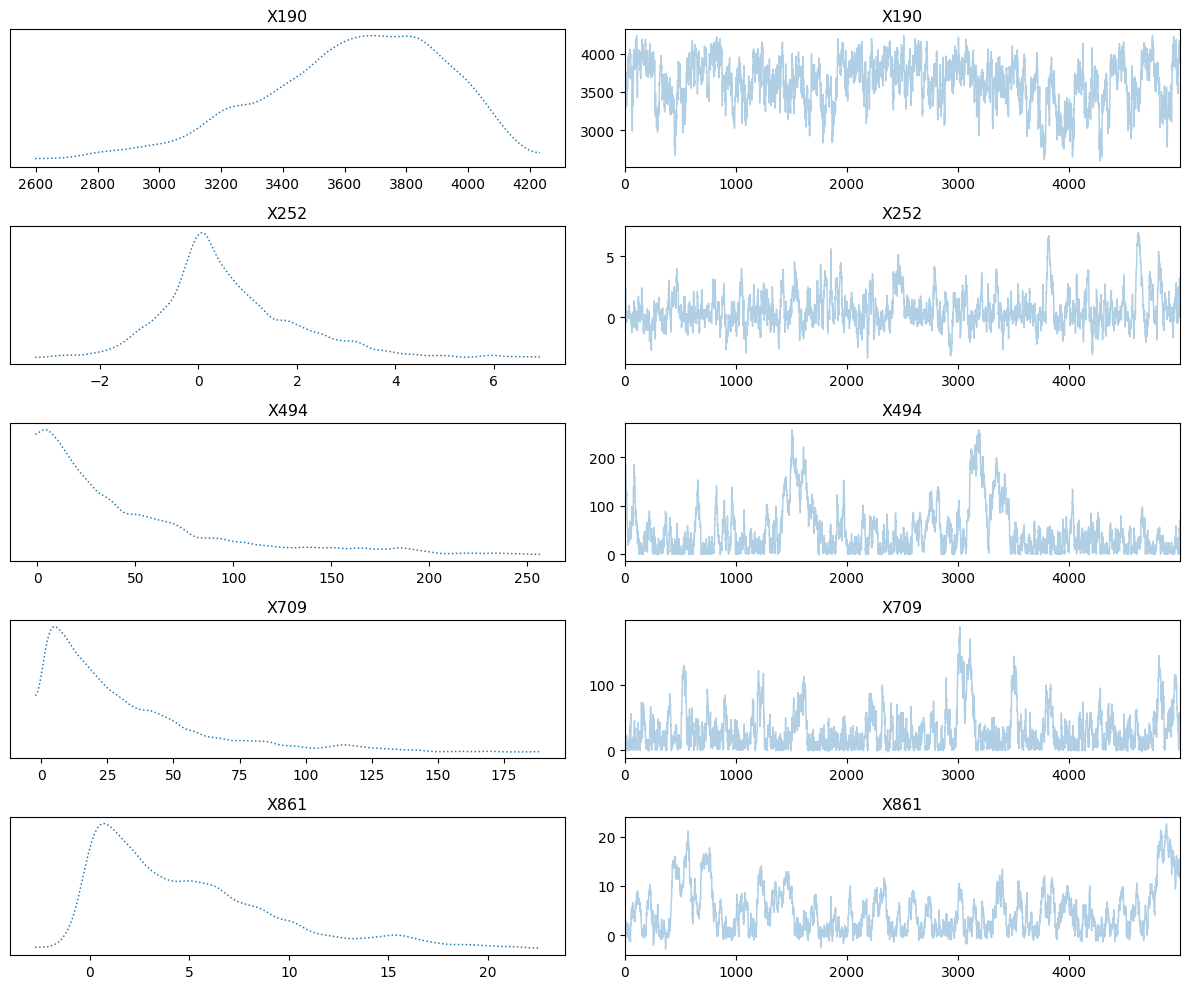

In [20]:
nuts_samples['X'].plot_trace()

Text(0.5, 1.0, 'Posterior mean of NUTS samples')

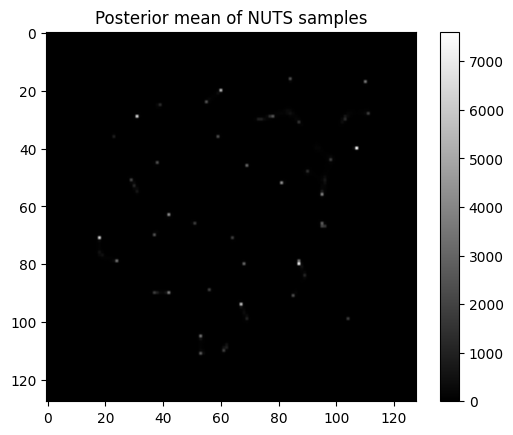

In [21]:
x_post = np.zeros(16384)
x_post[selected_set] = nuts_samples['X'].mean()
plt.imshow(unrav(x_post, 128), cmap='gray')
plt.colorbar()
plt.title("Posterior mean of NUTS samples")

Text(0.5, 1.0, 'The last NUTS sample')

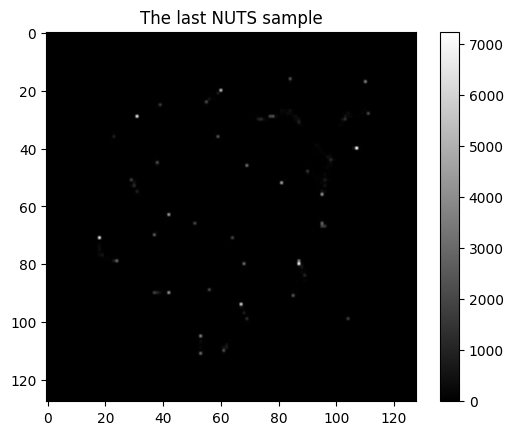

In [22]:
x_laplace = Laplace(0, 1/par['delta'])
x_last_sample = x_laplace.sample(16384).samples.flatten().numpy()
x_last_sample[selected_set] = nuts_samples['X'].samples[:,-1]
plt.imshow(unrav(x_last_sample, 128), cmap='gray')
plt.colorbar()
plt.title("The last NUTS sample")

### Sampling and sample statistics

[1]
Zhu, L., Zhang, W., Elnatan, D., Huang, B.: Faster STORM using compressed sensing. Nature Methods 9(7), 721–723 (2012) https://doi.org/10.1038/nmeth.1978

[2]
Flock, R., Dong, Y., Uribe, F., & Zahm, O.: Certified coordinate selection for high-dimensional Bayesian inversion with Laplace prior. Statistics and Computing. Under Review (2023). https://doi.org/10.21203/rs.3.rs-3471448/v1 